## Examining timing side-channel attacks

The idea is to show that time analysis can reveal meaningful information about a string used in a secret or a password if the amount of time it takes to perform the string match isn't buffered. 

This example will be to show how the libc strcmp method reveals information about a secret string and, possibly, the string itself in a brute force attack. We'll be using python code to demonstrate the action and analysis, but this can be performed with any language that uses similar methods.


Our secret string is 'apple'.

A client presents the secret string to the server, who knows the secret string, in an operation that will fail if the secret is incorrect.

So:

Client -> 'apple' -> Server  

Server: 
- receives a buffer containing the string. 
- gets a copy of the secret 
- strcmp's the two strings
    - analyze bytes from l to r
    - when a byte fails, return False
    - if no bytes fail move to next char. 
    - Return True if nothing fails or False when a match fails.
Server ->True/False -> Client 

The problem is that for every correct chunk of text on the LHS the "fail" takes longer to return. Also - longer strings also take longer to return.

So "b" or "broken" returns a failure instantly, but "a", "aplomb", "app", "application", etc will each take slightly longer for each character matched. The times are tiny, but it's possible to model the jitter window such that these lengths don't get lost in the noise. This can drastically cut down the time of a brute force attack and enhance its chances of success.

TL;DR - using sound hash functions which return in a constant time and not rolling-your-own solves this problem.

Also: for authentication purposes it's an antipattern to store the secret plaintext or decode an encrypted secret to compare in plaintext. Hashing the secret, storing the hash then comparing the hashes also obscures the size of your secret by making the compared strings the same lengh, and increasing the problem for a brute force attack.

In [29]:
# need to use attotime here to get fractional nanoseconds
import sys, os, time, string, attotime, secrets, hashlib
from datetime import datetime

# imports
import pandas as pd
import numpy as np

# Viz imports
import matplotlib.pyplot as plt
import seaborn as sns

# Config matplotlib
%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True # in matplotlib, edge borders are turned off by default.
sns.set_style("darkgrid") # set a grey grid as a background

# turn off warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# we only care about urlsafe characters - alpha, numeric, dash and underscore. Omitting . and ~ (RFC 3986)
valid_chars = list(string.ascii_letters)
for x in range(0,10):
    valid_chars.append(str(x))
valid_chars.append('-')
valid_chars.append('_')

In [3]:
def compare1(str1, str2):
    """
    Here we're going to amplify the lib strcmp delays to make the weakness easier to analyze:
    1. evaluate strings l-to-r
    2. dope a positive match with a tiny wait to emphasize the delay for demonstration
    3. return a False match immediately
    """

    one, two = list(str1), list(str2)
    for x in range(0,len(one)):
        if one[x] == two[x]:
            time.sleep(.001)
            pass
        else:
            return False
    return True

### First example - guess the first letter

Here we'll just run through each letter 1k times adding completion time to an array. Then we'll find the longest run of the letters.

The original code here found the longest completion of a string and added it to the "totals" array, then we sorted the longest variant of 'totals'. This would be better if averaged every run, then added that to the dict. 

TODO:
- add mean returns
- add an evaluation loop that then uses that builds the string from the statistical stubs

In [49]:
# in a long string we just want to guess the first character
# mysecret = secrets.token_urlsafe()
mysecret = 'rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUiQ'

In [5]:
totals=[]
for loop in range(1000):
    stash = {}
    for l in valid_chars:
        mystr = l *10
        start = attotime.attodatetime.now()
        compare1(mystr, mysecret)
        end = attotime.attodatetime.now()
        duration = end - start
        stash[mystr] = str(duration)


In [6]:
# fastest
sorted(stash.items(), key=lambda x: x[1])[:10]

[('eeeeeeeeee', '0:00:00.00020885467529297'),
 ('hhhhhhhhhh', '0:00:00.00020885467529297'),
 ('WWWWWWWWWW', '0:00:00.00020980834960937'),
 ('gggggggggg', '0:00:00.00021004676818848'),
 ('GGGGGGGGGG', '0:00:00.00021100044250488'),
 ('0000000000', '0:00:00.00021100044250488'),
 ('__________', '0:00:00.00021100044250489'),
 ('kkkkkkkkkk', '0:00:00.00021123886108399'),
 ('----------', '0:00:00.00021123886108399'),
 ('4444444444', '0:00:00.00021195411682128')]

In [7]:
# slowest returns at the bottom
# note how much slower lower case rrrrrrrrrr (leading character match) is compared to the rest
sorted(stash.items(), key=lambda x: x[1])[-10:]

[('DDDDDDDDDD', '0:00:00.0002288818359375'),
 ('vvvvvvvvvv', '0:00:00.00022983551025391'),
 ('uuuuuuuuuu', '0:00:00.00023078918457031'),
 ('tttttttttt', '0:00:00.00023198127746582'),
 ('LLLLLLLLLL', '0:00:00.00023794174194336'),
 ('QQQQQQQQQQ', '0:00:00.00024700164794922'),
 ('ssssssssss', '0:00:00.00025391578674317'),
 ('BBBBBBBBBB', '0:00:00.00028896331787109'),
 ('6666666666', '0:00:00.00030589103698731'),
 ('rrrrrrrrrr', '0:00:00.00162029266357422')]

### statistical analysis

We'll run each letter comparison 10 times, then get the mean of those runs. After a loop choose the longest timed character as the next spot on the stub.

In [56]:
totals=[]
for l in valid_chars:
    stash1 = {}
    for loop in range(10):
        mystr = l *10
        start = attotime.attodatetime.now()
        compare1(mystr, mysecret)
        end = attotime.attodatetime.now()
        ttime = end - start
        duration = str(ttime).split(':')[2]
        totals.append(float(duration))
        print(min(totals), max(totals), sum(totals) / len(totals))
    #stash1[mystr] = float(duration)
        
# sorted(stash.items(), key=lambda x: x[1])


0.0003509521484375 0.0003509521484375 0.0003509521484375
0.00027227401733398 0.0003509521484375 0.00031161308288574
0.00023913383483886 0.0003509521484375 0.00028745333353678
0.00023913383483886 0.0003509521484375 0.000287115573883055
0.00023913383483886 0.0003509521484375 0.00028247833251953005
0.00023913383483886 0.0003509521484375 0.00027922789255778
0.00023913383483886 0.0003509521484375 0.0002744197845458986
0.00023913383483886 0.0003509521484375 0.00027123093605041504
0.00023913383483886 0.0003509521484375 0.0002677705552842889
0.00023913383483886 0.0003509521484375 0.00026841163635254003
0.00023913383483886 0.0003509521484375 0.00026837262240323275
0.00023698806762695 0.0003509521484375 0.00026575724283854255
0.00023317337036133 0.0003509521484375 0.00026325079110952617
0.00023031234741211 0.0003509521484375 0.0002608980451311393
0.00023031234741211 0.0003509521484375 0.0002608458201090507
0.00023031234741211 0.0003509521484375 0.00026060640811920253
0.00023031234741211 0.000350

0.00022602081298828 0.00281596183776856 0.00030152778315350353
0.00022602081298828 0.00281596183776856 0.000302906461090212
0.00022602081298828 0.00281596183776856 0.0003026771929956257
0.00022602081298828 0.00281596183776856 0.0003023932736561486
0.00022602081298828 0.00281596183776856 0.0003021154403686529
0.00022602081298828 0.00281596183776856 0.00030195095624581804
0.00022602081298828 0.00281596183776856 0.0003016818137395955
0.00022602081298828 0.00281596183776856 0.0003015693468538674
0.00022602081298828 0.00281596183776856 0.00030134231086791086
0.00022602081298828 0.00281596183776856 0.00030108994128657374
0.00022602081298828 0.00281596183776856 0.0003009727224707609
0.00022602081298828 0.00281596183776856 0.00030074323661596447
0.00022602081298828 0.00281596183776856 0.0003004988958669269
0.00022602081298828 0.00281596183776856 0.0003002463160334412
0.00022602081298828 0.00281596183776856 0.00029999567912175157
0.00022602081298828 0.00281596183776856 0.0002999680252367514
0.0

0.00022506713867187 0.00387883186340332 0.00029616175957445853
0.00022506713867187 0.00387883186340332 0.00029608983329011473
0.00022506713867187 0.00387883186340332 0.00029598187683220223
0.00022506713867187 0.00387883186340332 0.0002959597625159862
0.00022506713867187 0.00387883186340332 0.00029584754272346666
0.00022506713867187 0.00387883186340332 0.0002957223731780723
0.00022506713867187 0.00387883186340332 0.00029566172343581496
0.00022506713867187 0.00387883186340332 0.00029554713371745725
0.00022506713867187 0.00387883186340332 0.00029542499315339863
0.00022506713867187 0.00387883186340332 0.0002953077291513421
0.00022506713867187 0.00387883186340332 0.0002951833936903214
0.00022506713867187 0.00387883186340332 0.0002950555515818149
0.00022506713867187 0.00387883186340332 0.00029493741883562964
0.00022506713867187 0.00387883186340332 0.0002948144522819732
0.00022506713867187 0.00387883186340332 0.0002947686349644383
0.00022506713867187 0.00387883186340332 0.00029465867838728347

0.00022387504577637 0.00417876243591309 0.0002931808186423493
0.00022387504577637 0.00417876243591309 0.0002931072742124149
0.00022387504577637 0.00417876243591309 0.0002930743052293319
0.00022387504577637 0.00417876243591309 0.0002929971675680143
0.00022387504577637 0.00417876243591309 0.00029292653818599533
0.00022387504577637 0.00417876243591309 0.0002928990260780009
0.00022387504577637 0.00417876243591309 0.0002928586875867545
0.00022387504577637 0.00417876243591309 0.0002927822084283112
0.00022387504577637 0.00417876243591309 0.00029274122029954267
0.00022387504577637 0.00417876243591309 0.0002926635861695561
0.00022387504577637 0.00417876243591309 0.0002925888319337773
0.00022387504577637 0.00417876243591309 0.0002925142645835878
0.00022387504577637 0.00417876243591309 0.0002924321444888837
0.00022387504577637 0.00417876243591309 0.00029235676934296967
0.00022387504577637 0.00417876243591309 0.0002922717839071197
0.00022387504577637 0.00417876243591309 0.00029218671333730535
0.00

0.00022387504577637 0.00417876243591309 0.00029241992965083215
0.00022387504577637 0.00417876243591309 0.0002924157011886115
0.00022387504577637 0.00417876243591309 0.00029236283795586957
0.00022387504577637 0.00417876243591309 0.00029231076035202987
0.00022387504577637 0.00417876243591309 0.000292255135384846
0.00022387504577637 0.00417876243591309 0.0002922385560976629
0.00022387504577637 0.00417876243591309 0.00029220198856965286
0.00022387504577637 0.00417876243591309 0.0002921529902630017
0.00022387504577637 0.00417876243591309 0.00029209568386986154
0.00022387504577637 0.00417876243591309 0.00029208589802459813
0.00022387504577637 0.00417876243591309 0.0002920346568292539
0.00022387504577637 0.00417876243591309 0.00029198645639736553
0.00022387504577637 0.00417876243591309 0.0002919313351162472
0.00022387504577637 0.00417876243591309 0.000291906600879832
0.00022387504577637 0.00417876243591309 0.00029185346581719147
0.00022387504577637 0.00417876243591309 0.0002918006568555012
0.

0.00022387504577637 0.00417876243591309 0.0002900979184590063
0.00022387504577637 0.00417876243591309 0.00029006107115947446
0.00022387504577637 0.00417876243591309 0.0002900204291710488
0.00022387504577637 0.00417876243591309 0.00028997655101779064
0.00022387504577637 0.00417876243591309 0.00028993219091412486
0.00022387504577637 0.00417876243591309 0.0002899521237049118
0.00022387504577637 0.00417876243591309 0.00028990839887981776
0.00022387504577637 0.00417876243591309 0.0002898963475136009
0.00022387504577637 0.00417876243591309 0.00028988796572955433
0.00022387504577637 0.00417876243591309 0.0002898507749386754
0.00022387504577637 0.00417876243591309 0.00028980744358961014
0.00022387504577637 0.00417876243591309 0.0002897639963078627
0.00022387504577637 0.00417876243591309 0.00028971661138170555
0.00022387504577637 0.00417876243591309 0.00028966802572312933
0.00022387504577637 0.00417876243591309 0.0002896247840509183
0.00022387504577637 0.00417876243591309 0.000289577068668781
0

0.00022387504577637 0.00417876243591309 0.0002873698639762087
0.00022387504577637 0.00417876243591309 0.0002873533779812843
0.00022387504577637 0.00417876243591309 0.0002873215610875059
0.00022387504577637 0.00417876243591309 0.0002889828025297463
0.00022387504577637 0.00417876243591309 0.00028896224460417825
0.00022387504577637 0.00417876243591309 0.00028892761637435175
0.00022387504577637 0.00417876243591309 0.0002888942576404099
0.00022387504577637 0.00417876243591309 0.0002888558917847464
0.00022387504577637 0.00417876243591309 0.0002888836411041202
0.00022387504577637 0.00417876243591309 0.00028887161841759324
0.00022387504577637 0.00417876243591309 0.00028883654822301294
0.00022387504577637 0.00417876243591309 0.0002888009123857135
0.00022387504577637 0.00417876243591309 0.00028879262664267754
0.00022387504577637 0.00417876243591309 0.0002887587413153686
0.00022387504577637 0.00417876243591309 0.00028872185240919225
0.00022387504577637 0.00417876243591309 0.0002889251039098202
0.

0.00022387504577637 0.00458884239196777 0.0002901314371857196
0.00022387504577637 0.00458884239196777 0.00029010709512964397
0.00022387504577637 0.00458884239196777 0.00029023014683333986
0.00022387504577637 0.00458884239196777 0.0002902233988556229
0.00022387504577637 0.00458884239196777 0.00029020653801427006
0.00022387504577637 0.00458884239196777 0.000290182208226732
0.00022387504577637 0.00458884239196777 0.000290150684407104
0.00022387504577637 0.00458884239196777 0.00029014635689650917
0.00022387504577637 0.00458884239196777 0.0002901154120500857
0.00022387504577637 0.00458884239196777 0.0002900867294387021
0.00022387504577637 0.00458884239196777 0.00029005480336618953
0.00022387504577637 0.00458884239196777 0.0002900236979216943
0.00022387504577637 0.00458884239196777 0.0002899906637901533
0.00022387504577637 0.00458884239196777 0.0002899610662748052
0.00022387504577637 0.00458884239196777 0.0002899277105666044
0.00022387504577637 0.00458884239196777 0.0002898959590964122
0.000

0.00022387504577637 0.00458884239196777 0.00028954678560388057
0.00022387504577637 0.00458884239196777 0.0002895262025667956
0.00022387504577637 0.00458884239196777 0.0002895003361213139
0.00022387504577637 0.00458884239196777 0.00028950053750172286
0.00022387504577637 0.00458884239196777 0.00028947724236382384
0.00022387504577637 0.00458884239196777 0.00028945385459999375
0.00022387504577637 0.00458884239196777 0.00028942853327423455
0.00022387504577637 0.00458884239196777 0.00028940220127574967
0.00022387504577637 0.00458884239196777 0.00028937635449342354
0.00022387504577637 0.00458884239196777 0.00028938787529267466
0.00022387504577637 0.00458884239196777 0.0002893641275247857
0.00022387504577637 0.00458884239196777 0.0002893389103558412
0.00022387504577637 0.00458884239196777 0.00028933058344939223
0.00022387504577637 0.00458884239196777 0.00028931503974800795
0.00022387504577637 0.00458884239196777 0.0002892893094282884
0.00022387504577637 0.00458884239196777 0.000289263718406607

0.00022387504577637 0.00458884239196777 0.00028878272545205565
0.00022387504577637 0.00458884239196777 0.0002887628918563655
0.00022387504577637 0.00458884239196777 0.0002887399273796017
0.00022387504577637 0.00458884239196777 0.0002887467213415907
0.00022387504577637 0.00458884239196777 0.0002887301749371468
0.00022387504577637 0.00458884239196777 0.0002887069494457562
0.00022387504577637 0.00458884239196777 0.00028868404780926354
0.00022387504577637 0.00458884239196777 0.0002886616722654902
0.00022387504577637 0.00458884239196777 0.0002886554196211071
0.00022387504577637 0.00458884239196777 0.00028863378391144384
0.00022387504577637 0.00458884239196777 0.00028861145819387133
0.00022387504577637 0.00458884239196777 0.00028858733065916317
0.00022387504577637 0.00458884239196777 0.0002885799068227676
0.00022387504577637 0.00458884239196777 0.0002885602600951476
0.00022387504577637 0.00458884239196777 0.0002885511365987487
0.00022387504577637 0.00458884239196777 0.00028853050887912884
0.

0.00022387504577637 0.00458884239196777 0.0002891687344919685
0.00022387504577637 0.00458884239196777 0.00028915723286720475
0.00022387504577637 0.00458884239196777 0.0002891360571557992
0.00022387504577637 0.00458884239196777 0.00028911453241226275
0.00022387504577637 0.00458884239196777 0.00028910306474881376
0.00022387504577637 0.00458884239196777 0.00028910027397030215
0.00022387504577637 0.00458884239196777 0.00028910624132689035
0.00022387504577637 0.00458884239196777 0.0002890866755527475
0.00022387504577637 0.00458884239196777 0.0002890686740933573
0.00022387504577637 0.00458884239196777 0.00028906672065568697
0.00022387504577637 0.00458884239196777 0.000289048649501582
0.00022387504577637 0.00458884239196777 0.0002890288624976509
0.00022387504577637 0.00458884239196777 0.0002890395754166232
0.00022387504577637 0.00458884239196777 0.0002890296311653193
0.00022387504577637 0.00458884239196777 0.00028900878289380577
0.00022387504577637 0.00458884239196777 0.0002889893139494861
0.

0.00022387504577637 0.00458884239196777 0.00028897970657480406
0.00022387504577637 0.00458884239196777 0.0002890273681661701
0.00022387504577637 0.00458884239196777 0.00028901014568314374
0.00022387504577637 0.00458884239196777 0.00028975747057781133
0.00022387504577637 0.00458884239196777 0.0002897427221050177
0.00022387504577637 0.00458884239196777 0.0002897307790558914
0.00022387504577637 0.00458884239196777 0.0002897119407035778
0.00022387504577637 0.00458884239196777 0.00028969130788812305
0.00022387504577637 0.00458884239196777 0.00028967208546931857
0.00022387504577637 0.00458884239196777 0.00028966461659791386
0.00022387504577637 0.00458884239196777 0.0002896482891141856
0.00022387504577637 0.00458884239196777 0.0002896287731687857
0.00022387504577637 0.00458884239196777 0.0002896110749876208
0.00022387504577637 0.00458884239196777 0.00028959363493991525
0.00022387504577637 0.00458884239196777 0.0002895756331699827
0.00022387504577637 0.00458884239196777 0.0002895555135720375
0

0.00022387504577637 0.00458884239196777 0.00028919474447768544
0.00022387504577637 0.00458884239196777 0.00028918852511140494
0.00022387504577637 0.00458884239196777 0.0002891826936780159
0.00022387504577637 0.00458884239196777 0.00028916427725296365
0.00022387504577637 0.00458884239196777 0.0002891459494186515
0.00022387504577637 0.00458884239196777 0.00028912724982203976
0.00022387504577637 0.00458884239196777 0.00028911339350933815
0.00022387504577637 0.00458884239196777 0.0002891036858512658
0.00022387504577637 0.00458884239196777 0.0002890873169906651
0.00022387504577637 0.00458884239196777 0.00028908628118068825
0.00022387504577637 0.00458884239196777 0.0002890701581916356
0.00022387504577637 0.00458884239196777 0.0002890521314715298
0.00022387504577637 0.00458884239196777 0.0002890331213202561
0.00022387504577637 0.00458884239196777 0.0002890145059421525
0.00022387504577637 0.00458884239196777 0.00028903085832837535
0.00022387504577637 0.00458884239196777 0.00028907121030698614


0.00022387504577637 0.00458884239196777 0.00028849808293872857
0.00022387504577637 0.00458884239196777 0.00028851590715013115
0.00022387504577637 0.00458884239196777 0.0002885662160167391
0.00022387504577637 0.00458884239196777 0.00028855102259714926
0.00022387504577637 0.00458884239196777 0.0002885369828181549
0.00022387504577637 0.00458884239196777 0.00028852094914574215
0.00022387504577637 0.00458884239196777 0.00028852201115781224
0.00022387504577637 0.00458884239196777 0.000288526931826731
0.00022387504577637 0.00458884239196777 0.0002885121301794467
0.00022387504577637 0.00458884239196777 0.00028849548033570876
0.00022387504577637 0.00458884239196777 0.0002884794831026026
0.00022387504577637 0.00458884239196777 0.000288468563628054
0.00022387504577637 0.00458884239196777 0.0002884519417747628
0.00022387504577637 0.00458884239196777 0.00028843597192952625
0.00022387504577637 0.00458884239196777 0.00028841944108849477
0.00022387504577637 0.00458884239196777 0.00028840256364722004
0

0.00022387504577637 0.00458884239196777 0.00028968372029485506
0.00022387504577637 0.00458884239196777 0.00028967797221624264
0.00022387504577637 0.00458884239196777 0.00028966320900397326
0.00022387504577637 0.00458884239196777 0.0002896481869267482
0.00022387504577637 0.00458884239196777 0.0002896721641478569
0.00022387504577637 0.00458884239196777 0.00028970367030093546
0.00022387504577637 0.00458884239196777 0.0002897065993019956
0.00022387504577637 0.00458884239196777 0.00028969405013619685
0.00022387504577637 0.00458884239196777 0.00028967964065658463
0.00022387504577637 0.00458884239196777 0.0002896663059857601
0.00022387504577637 0.00458884239196777 0.00028965577820609125
0.00022387504577637 0.00458884239196777 0.00028964272419656036
0.00022387504577637 0.00458884239196777 0.00028962807869837914
0.00022387504577637 0.00458884239196777 0.0002896231645978363
0.00022387504577637 0.00458884239196777 0.0002896168550876425
0.00022387504577637 0.00458884239196777 0.0002896024953180821

0.00022387504577637 0.006134033203125 0.0002910501402682484
0.00022387504577637 0.006134033203125 0.0002910414232095711
0.00022387504577637 0.006134033203125 0.00029102743488468536
0.00022387504577637 0.006134033203125 0.0002910142702148373
0.00022387504577637 0.006134033203125 0.00029099929200906136
0.00022387504577637 0.006134033203125 0.00029098482375460006
0.00022387504577637 0.006134033203125 0.00029096954747250204
0.00022387504577637 0.006134033203125 0.0002909560982599537
0.00022387504577637 0.006134033203125 0.00029094083756913894
0.00022387504577637 0.006134033203125 0.0002909263999030178
0.00022387504577637 0.006134033203125 0.0002909100895549722
0.00022387504577637 0.006134033203125 0.00029090932728269883
0.00022387504577637 0.006134033203125 0.00029089653798923705
0.00022387504577637 0.006134033203125 0.00029093911712301787
0.00022387504577637 0.006134033203125 0.0002909267649931066
0.00022387504577637 0.006134033203125 0.00029091291710534853
0.00022387504577637 0.006134033

0.00022387504577637 0.006134033203125 0.00029202855663535034
0.00022387504577637 0.006134033203125 0.00029201820672985595
0.00022387504577637 0.006134033203125 0.000292014510822202
0.00022387504577637 0.006134033203125 0.0002920142874257699
0.00022387504577637 0.006134033203125 0.00029200071411057536
0.00022387504577637 0.006134033203125 0.0002919873826747758
0.00022387504577637 0.006134033203125 0.0002919728233969423
0.00022387504577637 0.006134033203125 0.0002919585651325304
0.00022387504577637 0.006134033203125 0.00029194325634621234
0.00022387504577637 0.006134033203125 0.00029194745620385445
0.00022387504577637 0.006134033203125 0.0002919333321707589
0.00022387504577637 0.006134033203125 0.0002919429336619242
0.00022387504577637 0.006134033203125 0.000291929639424672
0.00022387504577637 0.006134033203125 0.00029193653779871324
0.00022387504577637 0.006134033203125 0.00029192301701373003
0.00022387504577637 0.006134033203125 0.0002919161891585347
0.00022387504577637 0.0061340332031

0.00022387504577637 0.006134033203125 0.00029162205302681846
0.00022387504577637 0.006134033203125 0.0002916240513756756
0.00022387504577637 0.006134033203125 0.0002916233736870165
0.00022387504577637 0.006134033203125 0.00029161857316136835
0.00022387504577637 0.006134033203125 0.00029161232654179367
0.00022387504577637 0.006134033203125 0.00029159811884686926
0.00022387504577637 0.006134033203125 0.0002915839734672108
0.00022387504577637 0.006134033203125 0.0002915683873702287
0.00022387504577637 0.006134033203125 0.0002915622139511322
0.00022387504577637 0.006134033203125 0.0002915490327387735
0.00022387504577637 0.006134033203125 0.0002915370258503966
0.00022387504577637 0.006134033203125 0.0002915235785912989
0.00022387504577637 0.006134033203125 0.0002915106380163734
0.00022387504577637 0.006134033203125 0.00029149725876868426
0.00022387504577637 0.006134033203125 0.0002914841080601121
0.00022387504577637 0.006134033203125 0.0002914711857308766
0.00022387504577637 0.0061340332031

0.00022387504577637 0.006134033203125 0.00029151918836146684
0.00022387504577637 0.006134033203125 0.0002915319746720788
0.00022387504577637 0.006134033203125 0.00029153760274251304
0.00022387504577637 0.006134033203125 0.0002915281847937058
0.00022387504577637 0.006134033203125 0.0002915155405682598
0.00022387504577637 0.006134033203125 0.00029151942130064873
0.00022387504577637 0.006134033203125 0.00029151154877237487
0.00022387504577637 0.006134033203125 0.0002914994458908775
0.00022387504577637 0.006134033203125 0.00029148777167214003
0.00022387504577637 0.006134033203125 0.0002914761026338857
0.00022387504577637 0.006134033203125 0.00029150151317904456
0.00022387504577637 0.006134033203125 0.0002915265423200907
0.00022387504577637 0.006134033203125 0.0002915211104500849
0.00022387504577637 0.006134033203125 0.0002915092329576205
0.00022387504577637 0.006134033203125 0.00029149561697709643
0.00022387504577637 0.006134033203125 0.00029148353908005456
0.00022387504577637 0.0061340332

0.00022387504577637 0.006134033203125 0.00029059184486128313
0.00022387504577637 0.006134033203125 0.0002905861840379719
0.00022387504577637 0.006134033203125 0.0002905748574198798
0.00022387504577637 0.006134033203125 0.0002905687472209056
0.00022387504577637 0.006134033203125 0.00029055758087138776
0.00022387504577637 0.006134033203125 0.0002905530448075215
0.00022387504577637 0.006134033203125 0.00029054148199702374
0.00022387504577637 0.006134033203125 0.0002905316935240767
0.00022387504577637 0.006134033203125 0.00029051902816284
0.00022387504577637 0.006134033203125 0.0002905078841852606
0.00022387504577637 0.006134033203125 0.00029049553237594925
0.00022387504577637 0.006134033203125 0.0002904837414369745
0.00022387504577637 0.006134033203125 0.00029047185448967936
0.00022387504577637 0.006134033203125 0.00029046542560685646
0.00022387504577637 0.006134033203125 0.0002904539009334928
0.00022387504577637 0.006134033203125 0.00029045000205496225
0.00022387504577637 0.0061340332031

0.00022387504577637 0.006134033203125 0.00029039739646556835
0.00022387504577637 0.006134033203125 0.0002903892508607598
0.00022387504577637 0.006134033203125 0.0002903994669717651
0.00022387504577637 0.006134033203125 0.0002904005738599634
0.00022387504577637 0.006134033203125 0.0002903918064001835
0.00022387504577637 0.006134033203125 0.0002903809717895286
0.00022387504577637 0.006134033203125 0.00029037062301389235
0.00022387504577637 0.006134033203125 0.00029036186691151707
0.00022387504577637 0.006134033203125 0.00029035917828051276
0.00022387504577637 0.006134033203125 0.00029034855146821886
0.00022387504577637 0.006134033203125 0.00029034302829252895
0.00022387504577637 0.006134033203125 0.00029033284190202734
0.00022387504577637 0.006134033203125 0.0002903218902181646
0.00022387504577637 0.006134033203125 0.00029031700077353044
0.00022387504577637 0.006134033203125 0.00029031028670649373
0.00022387504577637 0.006134033203125 0.0002902999228946722
0.00022387504577637 0.006134033

0.00022387504577637 0.006134033203125 0.0002898771941268939
0.00022387504577637 0.006134033203125 0.0002898771556270841
0.00022387504577637 0.006134033203125 0.0002898832162221273
0.00022387504577637 0.006134033203125 0.00028987338297636417
0.00022387504577637 0.006134033203125 0.0002898972240449476
0.00022387504577637 0.006134033203125 0.00028989491895860004
0.00022387504577637 0.006134033203125 0.00028988411960262
0.00022387504577637 0.006134033203125 0.00028987410915555707
0.00022387504577637 0.006134033203125 0.0002898631334027901
0.00022387504577637 0.006134033203125 0.000289852115755873
0.00022387504577637 0.006134033203125 0.00028984940642542886
0.00022387504577637 0.006134033203125 0.00028984596014806945
0.00022387504577637 0.006134033203125 0.00028983596676322894
0.00022387504577637 0.006134033203125 0.0002898286053346403
0.00022387504577637 0.006134033203125 0.0002898176050149279
0.00022387504577637 0.006134033203125 0.00028981628764558295
0.00022387504577637 0.00613403320312

0.00022387504577637 0.006134033203125 0.0002895366260034462
0.00022387504577637 0.006134033203125 0.00028953669698052854
0.00022387504577637 0.006134033203125 0.000289526537283143
0.00022387504577637 0.006134033203125 0.0002895163813759822
0.00022387504577637 0.006134033203125 0.0002895061847924386
0.00022387504577637 0.006134033203125 0.00028950532781262016
0.00022387504577637 0.006134033203125 0.0002894998041219804
0.00022387504577637 0.006134033203125 0.00028949072732063286
0.00022387504577637 0.006134033203125 0.00028948018766809125
0.00022387504577637 0.006134033203125 0.0002894692521355595
0.00022387504577637 0.006134033203125 0.00028946973527774726
0.00022387504577637 0.006134033203125 0.00028946129253044277
0.00022387504577637 0.006134033203125 0.00028946808152580615
0.00022387504577637 0.006134033203125 0.0002894594202803358
0.00022387504577637 0.006134033203125 0.00028945506728591977
0.00022387504577637 0.006134033203125 0.0002894460123254892
0.00022387504577637 0.00613403320

0.00022387504577637 0.006134033203125 0.00029070142085184825
0.00022387504577637 0.006134033203125 0.0002907121895252327
0.00022387504577637 0.006134033203125 0.00029070523059564115
0.00022387504577637 0.006134033203125 0.00029069584609142944
0.00022387504577637 0.006134033203125 0.0002906928960235258
0.00022387504577637 0.006134033203125 0.00029068705140958837
0.00022387504577637 0.006134033203125 0.00029067797320229667
0.00022387504577637 0.006134033203125 0.00029066966444525285
0.00022387504577637 0.006134033203125 0.00029066076282091287
0.00022387504577637 0.006134033203125 0.00029065118354281295
0.00022387504577637 0.006134033203125 0.00029064267129237783
0.00022387504577637 0.006134033203125 0.0002906327583660088
0.00022387504577637 0.006134033203125 0.00029062357197222945
0.00022387504577637 0.006134033203125 0.00029061307068578655
0.00022387504577637 0.006134033203125 0.00029060372102277594
0.00022387504577637 0.006134033203125 0.0002905929294748726
0.00022387504577637 0.006134

0.00022387504577637 0.006134033203125 0.0002913672212565216
0.00022387504577637 0.006134033203125 0.00029136212502544446
0.00022387504577637 0.006134033203125 0.00029135275987604754
0.00022387504577637 0.006134033203125 0.0002913433568950198
0.00022387504577637 0.006134033203125 0.00029133416240208736
0.00022387504577637 0.006134033203125 0.0002913246427310439
0.00022387504577637 0.006134033203125 0.00029132095343479804
0.00022387504577637 0.006134033203125 0.0002913188655330072
0.00022387504577637 0.006134033203125 0.00029130918932059513
0.00022387504577637 0.006134033203125 0.0002912991473048479
0.00022387504577637 0.006134033203125 0.0002912891087435265
0.00022387504577637 0.006134033203125 0.0002912795656422347
0.00022387504577637 0.006134033203125 0.00029127109165532716
0.00022387504577637 0.006134033203125 0.00029126180085157106
0.00022387504577637 0.006134033203125 0.00029125607845585714
0.00022387504577637 0.006134033203125 0.000291246055921629
0.00022387504577637 0.00613403320

0.00022387504577637 0.006134033203125 0.00029109680279410595
0.00022387504577637 0.006134033203125 0.0002910916716028184
0.00022387504577637 0.006134033203125 0.0002910878449446477
0.00022387504577637 0.006134033203125 0.0002910778617227314
0.00022387504577637 0.006134033203125 0.00029106855274055836
0.00022387504577637 0.006134033203125 0.0002910582997948079
0.00022387504577637 0.006134033203125 0.0002910705388391253
0.00022387504577637 0.006134033203125 0.0002910836022236267
0.00022387504577637 0.006134033203125 0.0002911795654801715
0.00022387504577637 0.006134033203125 0.00029121756829688614
0.00022387504577637 0.006134033203125 0.0002912397086571046
0.00022387504577637 0.006134033203125 0.00029166764210140895
0.00022387504577637 0.006134033203125 0.0002916734619443329
0.00022387504577637 0.006134033203125 0.0002916647777084477
0.00022387504577637 0.006134033203125 0.0002916553871156046
0.00022387504577637 0.006134033203125 0.0002916450147509023
0.00022387504577637 0.00613403320312

0.00022387504577637 0.006134033203125 0.000291454880098955
0.00022387504577637 0.006134033203125 0.0002914527187344349
0.00022387504577637 0.006134033203125 0.0002914441267343079
0.00022387504577637 0.006134033203125 0.00029145065634643733
0.00022387504577637 0.006134033203125 0.0002914438278296212
0.00022387504577637 0.006134033203125 0.0002914383024565578
0.00022387504577637 0.006134033203125 0.000291429565255847
0.00022387504577637 0.006134033203125 0.00029142614774980914
0.00022387504577637 0.006134033203125 0.0002914231902787347
0.00022387504577637 0.006134033203125 0.00029141801590908025
0.00022387504577637 0.006134033203125 0.0002914105492421188
0.00022387504577637 0.006134033203125 0.0002914016705895724
0.00022387504577637 0.006134033203125 0.0002913916481729882
0.00022387504577637 0.006134033203125 0.00029138327218110907
0.00022387504577637 0.006134033203125 0.00029137455500089204
0.00022387504577637 0.006134033203125 0.0002913655349983273
0.00022387504577637 0.006134033203125

0.00022387504577637 0.006134033203125 0.00029083687053181053
0.00022387504577637 0.006134033203125 0.0002908427845294295
0.00022387504577637 0.006134033203125 0.0002908381733415074
0.00022387504577637 0.006134033203125 0.0002908296871569253
0.00022387504577637 0.006134033203125 0.00029083061631683004
0.00022387504577637 0.006134033203125 0.000290822097022467
0.00022387504577637 0.006134033203125 0.0002908205915910691
0.00022387504577637 0.006134033203125 0.00029081536018232265
0.00022387504577637 0.006134033203125 0.00029081256511723056
0.00022387504577637 0.006134033203125 0.0002908054923657143
0.00022387504577637 0.006134033203125 0.0002908026996916426
0.00022387504577637 0.006134033203125 0.0002907961099980381
0.00022387504577637 0.006134033203125 0.0002907893380076177
0.00022387504577637 0.006134033203125 0.0002907813516898736
0.00022387504577637 0.006134033203125 0.0002907720778968423
0.00022387504577637 0.006134033203125 0.0002907634702679547
0.00022387504577637 0.006134033203125

0.00022387504577637 0.006134033203125 0.0002912295804182355
0.00022387504577637 0.006134033203125 0.0002912290980306904
0.00022387504577637 0.006134033203125 0.0002912264730203216
0.00022387504577637 0.006134033203125 0.0002912181713132243
0.00022387504577637 0.006134033203125 0.0002912174409361934
0.00022387504577637 0.006134033203125 0.00029121949512420575
0.00022387504577637 0.006134033203125 0.0002912131255258343
0.00022387504577637 0.006134033203125 0.0002912107189871062
0.00022387504577637 0.006134033203125 0.00029120756387353763
0.00022387504577637 0.006134033203125 0.0002912004854121501
0.00022387504577637 0.006134033203125 0.00029119237463749644
0.00022387504577637 0.006134033203125 0.0002911848369247448
0.00022387504577637 0.006134033203125 0.00029117822861050976
0.00022387504577637 0.006134033203125 0.00029116923345192427
0.00022387504577637 0.006134033203125 0.0002911611322010533
0.00022387504577637 0.006134033203125 0.00029116112442005197
0.00022387504577637 0.006134033203

0.00022387504577637 0.006134033203125 0.00029070253576867264
0.00022387504577637 0.006134033203125 0.0002906978242688029
0.00022387504577637 0.006134033203125 0.000290695395321734
0.00022387504577637 0.006134033203125 0.00029068792154865344
0.00022387504577637 0.006134033203125 0.00029068895008253017
0.00022387504577637 0.006134033203125 0.0002906810302800708
0.00022387504577637 0.006134033203125 0.000290673561836802
0.00022387504577637 0.006134033203125 0.0002906650594053416
0.00022387504577637 0.006134033203125 0.0002906669885230921
0.00022387504577637 0.006134033203125 0.00029065962894337494
0.00022387504577637 0.006134033203125 0.00029065144293348997
0.00022387504577637 0.006134033203125 0.0002906435354411455
0.00022387504577637 0.006134033203125 0.0002906350435103442
0.00022387504577637 0.006134033203125 0.0002906275892899547
0.00022387504577637 0.006134033203125 0.0002906220349147592
0.00022387504577637 0.006134033203125 0.00029062990203225964
0.00022387504577637 0.00613403320312

0.00022387504577637 0.00717711448669433 0.0002910679506644913
0.00022387504577637 0.00717711448669433 0.0002910605090168
0.00022387504577637 0.00717711448669433 0.0002910526334132515
0.00022387504577637 0.00717711448669433 0.0002910447600253743
0.00022387504577637 0.00717711448669433 0.0002910367547208247
0.00022387504577637 0.00717711448669433 0.0002910288857803484
0.00022387504577637 0.00717711448669433 0.00029102111962300186
0.00022387504577637 0.00717711448669433 0.00029101436121058534
0.00022387504577637 0.00717711448669433 0.000291006934418248
0.00022387504577637 0.00717711448669433 0.0002910036983744661
0.00022387504577637 0.00717711448669433 0.00029100042973561794
0.00022387504577637 0.00717711448669433 0.0002909931085309705
0.00022387504577637 0.00717711448669433 0.000290986057344733
0.00022387504577637 0.00717711448669433 0.0002909790751203625
0.00022387504577637 0.00717711448669433 0.00029097179348549145
0.00022387504577637 0.00717711448669433 0.0002909671588989309
0.0002238

0.00022387504577637 0.00717711448669433 0.0002927405001325896
0.00022387504577637 0.00717711448669433 0.00029273738484034834
0.00022387504577637 0.00717711448669433 0.0002927298829235713
0.00022387504577637 0.00717711448669433 0.0002927224155471259
0.00022387504577637 0.00717711448669433 0.000292714820242149
0.00022387504577637 0.00717711448669433 0.0002927061549518199
0.00022387504577637 0.00717711448669433 0.00029269827159289117
0.00022387504577637 0.00717711448669433 0.000292690974979793
0.00022387504577637 0.00717711448669433 0.00029268923327955946
0.00022387504577637 0.00717711448669433 0.0002926866803330945
0.00022387504577637 0.00717711448669433 0.00029267919349254865
0.00022387504577637 0.00717711448669433 0.0002926718709905428
0.00022387504577637 0.00717711448669433 0.00029266377154858405
0.00022387504577637 0.00717711448669433 0.0002926581405986486
0.00022387504577637 0.00717711448669433 0.00029265001278307753
0.00022387504577637 0.00717711448669433 0.00029264260091040636
0.0

0.00022387504577637 0.00717711448669433 0.0002926561062327443
0.00022387504577637 0.00717711448669433 0.0002926553646891804
0.00022387504577637 0.00717711448669433 0.00029264906771243307
0.00022387504577637 0.00717711448669433 0.0002926419833554204
0.00022387504577637 0.00717711448669433 0.000292634869316096
0.00022387504577637 0.00717711448669433 0.0002926268421070105
0.00022387504577637 0.00717711448669433 0.0002926266412658005
0.00022387504577637 0.00717711448669433 0.0002926252733055452
0.00022387504577637 0.00717711448669433 0.0002926180390772925
0.00022387504577637 0.00717711448669433 0.00029261187901572573
0.00022387504577637 0.00717711448669433 0.00029260427008039687
0.00022387504577637 0.00717711448669433 0.00029259663162897325
0.00022387504577637 0.00717711448669433 0.00029258836471071387
0.00022387504577637 0.00717711448669433 0.00029258589968991495
0.00022387504577637 0.00717711448669433 0.0002925794643041557
0.00022387504577637 0.00717711448669433 0.0002925774107652463
0.0

0.00022387504577637 0.00717711448669433 0.00029266258393081
0.00022387504577637 0.00717711448669433 0.00029265777698945833
0.00022387504577637 0.00717711448669433 0.00029265137445920523
0.00022387504577637 0.00717711448669433 0.00029264675442510776
0.00022387504577637 0.00717711448669433 0.0002926392190517177
0.00022387504577637 0.00717711448669433 0.0002926385002092028
0.00022387504577637 0.00717711448669433 0.00029263145891694406
0.00022387504577637 0.00717711448669433 0.0002926236829145149
0.00022387504577637 0.00717711448669433 0.00029261600096713625
0.00022387504577637 0.00717711448669433 0.00029260795283019963
0.00022387504577637 0.00717711448669433 0.00029260055097304113
0.00022387504577637 0.00717711448669433 0.0002925926295851827
0.00022387504577637 0.00717711448669433 0.0002925845568916747
0.00022387504577637 0.00717711448669433 0.00029257608763274656
0.00022387504577637 0.00717711448669433 0.000292579854221501
0.00022387504577637 0.00717711448669433 0.0002925734724133337
0.0

0.00022387504577637 0.00717711448669433 0.0002921247006057949
0.00022387504577637 0.00717711448669433 0.00029212082389171553
0.00022387504577637 0.00717711448669433 0.0002921143294690075
0.00022387504577637 0.00717711448669433 0.00029210682503221695
0.00022387504577637 0.00717711448669433 0.0002921130670881164
0.00022387504577637 0.00717711448669433 0.0002921064570778545
0.00022387504577637 0.00717711448669433 0.0002920993133457359
0.00022387504577637 0.00717711448669433 0.00029209689991691544
0.00022387504577637 0.00717711448669433 0.0002922691231982373
0.00022387504577637 0.00717711448669433 0.00029226960290294437
0.00022387504577637 0.00717711448669433 0.0002922620856553836
0.00022387504577637 0.00717711448669433 0.0002922556998054667
0.00022387504577637 0.00717711448669433 0.00029225389251861156
0.00022387504577637 0.00717711448669433 0.00029224789560130897
0.00022387504577637 0.00717711448669433 0.00029224415838064724
0.00022387504577637 0.00717711448669433 0.0002922402735439788
0

0.00022387504577637 0.00717711448669433 0.0002916817369436663
0.00022387504577637 0.00717711448669433 0.00029193803250571844
0.00022387504577637 0.00717711448669433 0.000291937699258117
0.00022387504577637 0.00717711448669433 0.00029193054334860686
0.00022387504577637 0.00717711448669433 0.00029193140130000646
0.00022387504577637 0.00717711448669433 0.0002919243349772403
0.00022387504577637 0.00717711448669433 0.0002919174154865546
0.00022387504577637 0.00717711448669433 0.0002919107298307781
0.00022387504577637 0.00717711448669433 0.00029190439398566983
0.00022387504577637 0.00717711448669433 0.0002918977405532313
0.00022387504577637 0.00717711448669433 0.000291890914690496
0.00022387504577637 0.00717711448669433 0.00029188351039468804
0.00022387504577637 0.00717711448669433 0.000291877296947966
0.00022387504577637 0.00717711448669433 0.0002918700121000601
0.00022387504577637 0.00717711448669433 0.0002918629609768689
0.00022387504577637 0.00717711448669433 0.0002918555636814132
0.0002

0.00022387504577637 0.00717711448669433 0.00029172436066126614
0.00022387504577637 0.00717711448669433 0.00029172191081125156
0.00022387504577637 0.00717711448669433 0.0002917153025856077
0.00022387504577637 0.00717711448669433 0.0002917149760568091
0.00022387504577637 0.00717711448669433 0.0002917087096480065
0.00022387504577637 0.00717711448669433 0.00029170185080061036
0.00022387504577637 0.00717711448669433 0.00029169465423464536
0.00022387504577637 0.00717711448669433 0.00029169184207011444
0.00022387504577637 0.00717711448669433 0.00029168583582576507
0.00022387504577637 0.00717711448669433 0.000291678756793472
0.00022387504577637 0.00717711448669433 0.0002916720468897613
0.00022387504577637 0.00717711448669433 0.00029166497117029427
0.00022387504577637 0.00717711448669433 0.0002916578123520601
0.00022387504577637 0.00717711448669433 0.00029165478051061965
0.00022387504577637 0.00717711448669433 0.0002916519754036638
0.00022387504577637 0.00717711448669433 0.00029164821050743357


0.00022387504577637 0.00717711448669433 0.00029134700672667354
0.00022387504577637 0.00717711448669433 0.0002913433630129412
0.00022387504577637 0.00717711448669433 0.0002913369600296462
0.00022387504577637 0.00717711448669433 0.0002913301997555118
0.00022387504577637 0.00717711448669433 0.00029132366180419924
0.00022387504577637 0.00717711448669433 0.0002913165735351365
0.00022387504577637 0.00717711448669433 0.00029130934896471326
0.00022387504577637 0.00717711448669433 0.0002913065396924269
0.00022387504577637 0.00717711448669433 0.000291300007503709
0.00022387504577637 0.00717711448669433 0.0002912971999619033
0.00022387504577637 0.00717711448669433 0.0002912908909691999
0.00022387504577637 0.00717711448669433 0.00029128425256687876
0.00022387504577637 0.00717711448669433 0.00029127800166882595
0.00022387504577637 0.00717711448669433 0.00029127100793346943
0.00022387504577637 0.00717711448669433 0.0002912648151375655
0.00022387504577637 0.00717711448669433 0.0002912573835888621
0.0

0.00022387504577637 0.00717711448669433 0.00029147913621246517
0.00022387504577637 0.00717711448669433 0.00029147558377544934
0.00022387504577637 0.00717711448669433 0.00029147295017609647
0.00022387504577637 0.00717711448669433 0.00029146632148190624
0.00022387504577637 0.00717711448669433 0.0002914599372424941
0.00022387504577637 0.00717711448669433 0.00029145331152241485
0.00022387504577637 0.00717711448669433 0.0002914464444036745
0.00022387504577637 0.00717711448669433 0.0002914392280254785
0.00022387504577637 0.00717711448669433 0.0002914322561244179
0.00022387504577637 0.00717711448669433 0.00029142652686208544
0.00022387504577637 0.00717711448669433 0.00029141980076462037
0.00022387504577637 0.00717711448669433 0.0002914128334277598
0.00022387504577637 0.00717711448669433 0.00029140578675593726
0.00022387504577637 0.00717711448669433 0.0002914029216216223
0.00022387504577637 0.00717711448669433 0.00029139690230912523
0.00022387504577637 0.00717711448669433 0.0002913898328681695

0.00022387504577637 0.00717711448669433 0.00029178692476592794
0.00022387504577637 0.00717711448669433 0.00029178207774585715
0.00022387504577637 0.00717711448669433 0.00029177609822856595
0.00022387504577637 0.00717711448669433 0.0002917834050487984
0.00022387504577637 0.00717711448669433 0.00029177766391299555
0.00022387504577637 0.00717711448669433 0.00029177595610590655
0.00022387504577637 0.00717711448669433 0.00029176979545573025
0.00022387504577637 0.00717711448669433 0.0002917685894982461
0.00022387504577637 0.00717711448669433 0.00029176219392217984
0.00022387504577637 0.00717711448669433 0.0002917636759227685
0.00022387504577637 0.00717711448669433 0.0002917580461270294
0.00022387504577637 0.00717711448669433 0.0002917525755902173
0.00022387504577637 0.00717711448669433 0.000291746711267497
0.00022387504577637 0.00717711448669433 0.00029174398151568325
0.00022387504577637 0.00717711448669433 0.00029173793514710014
0.00022387504577637 0.00717711448669433 0.0002917318901136983


0.00022387504577637 0.00717711448669433 0.0002919933045610143
0.00022387504577637 0.00717711448669433 0.00029198866504943883
0.00022387504577637 0.00717711448669433 0.0002919826067696923
0.00022387504577637 0.00717711448669433 0.0002919884746023312
0.00022387504577637 0.00717711448669433 0.0002919887149197169
0.00022387504577637 0.00717711448669433 0.00029198544561404895
0.00022387504577637 0.00717711448669433 0.00029197972574275294
0.00022387504577637 0.00717711448669433 0.000291976483917484
0.00022387504577637 0.00717711448669433 0.00029197099842929243
0.00022387504577637 0.00717711448669433 0.0002919655657170539
0.00022387504577637 0.00717711448669433 0.0002919594120123024
0.00022387504577637 0.00717711448669433 0.0002919532338498798
0.00022387504577637 0.00717711448669433 0.00029194638658441456
0.00022387504577637 0.00717711448669433 0.0002919405463503234
0.00022387504577637 0.00717711448669433 0.00029193460425703583
0.00022387504577637 0.00717711448669433 0.0002919296430038599
0.0

0.00022387504577637 0.00717711448669433 0.00029197149966746005
0.00022387504577637 0.00717711448669433 0.0002919668052157807
0.00022387504577637 0.00717711448669433 0.00029196476703687496
0.00022387504577637 0.00717711448669433 0.0002919639430024336
0.00022387504577637 0.00717711448669433 0.0002919604644289957
0.00022387504577637 0.00717711448669433 0.00029195728995693587
0.00022387504577637 0.00717711448669433 0.0002919535853278344
0.00022387504577637 0.00717711448669433 0.00029195127160630297
0.00022387504577637 0.00717711448669433 0.00029194534444091226
0.00022387504577637 0.00717711448669433 0.0002919400502716857
0.00022387504577637 0.00717711448669433 0.00029193940633633926
0.00022387504577637 0.00717711448669433 0.00029193368442636863
0.00022387504577637 0.00717711448669433 0.00029192932785302556
0.00022387504577637 0.00717711448669433 0.0002919231788222221
0.00022387504577637 0.00717711448669433 0.00029191821813583373
0.00022387504577637 0.00717711448669433 0.0002919119705702841

0.00022387504577637 0.00717711448669433 0.0002918697786717882
0.00022387504577637 0.00717711448669433 0.00029186481670550566
0.00022387504577637 0.00717711448669433 0.00029185898834355406
0.00022387504577637 0.00717711448669433 0.0002918555897370828
0.00022387504577637 0.00717711448669433 0.000291851968830674
0.00022387504577637 0.00717711448669433 0.0002918496122482127
0.00022387504577637 0.00717711448669433 0.0002918469093287873
0.00022387504577637 0.00717711448669433 0.0002918416060410537
0.00022387504577637 0.00717711448669433 0.0002918402667652909
0.00022387504577637 0.00717711448669433 0.00029183548534722595
0.00022387504577637 0.00717711448669433 0.00029182949153328024
0.00022387504577637 0.00717711448669433 0.00029182411797606993
0.00022387504577637 0.00717711448669433 0.0002918181018294575
0.00022387504577637 0.00717711448669433 0.0002918129533687097
0.00022387504577637 0.00717711448669433 0.0002918120634516212
0.00022387504577637 0.00717711448669433 0.0002918103074626513
0.00

0.00022387504577637 0.00717711448669433 0.00029158137746299566
0.00022387504577637 0.00717711448669433 0.0002915776598503339
0.00022387504577637 0.00717711448669433 0.00029157474485164847
0.00022387504577637 0.00717711448669433 0.0002915705427486428
0.00022387504577637 0.00717711448669433 0.00029156485958499727
0.00022387504577637 0.00717711448669433 0.00029155959053058986
0.00022387504577637 0.00717711448669433 0.000291562289266734
0.00022387504577637 0.00717711448669433 0.0002915568515435248
0.00022387504577637 0.00717711448669433 0.0002915529448089009
0.00022387504577637 0.00717711448669433 0.00029154789764656045
0.00022387504577637 0.00717711448669433 0.0002915425601656228
0.00022387504577637 0.00717711448669433 0.00029153732087726006
0.00022387504577637 0.00717711448669433 0.0002915319855600092
0.00022387504577637 0.00717711448669433 0.0002915271610297679
0.00022387504577637 0.00717711448669433 0.000291521730756915
0.00022387504577637 0.00717711448669433 0.0002915302305731155
0.00

0.00022387504577637 0.00717711448669433 0.0002912027774871149
0.00022387504577637 0.00717711448669433 0.00029119987392900004
0.00022387504577637 0.00717711448669433 0.00029119476490667857
0.00022387504577637 0.00717711448669433 0.00029118915881192213
0.00022387504577637 0.00717711448669433 0.00029118345896782455
0.00022387504577637 0.00717711448669433 0.0002911779736818033
0.00022387504577637 0.00717711448669433 0.00029117246577539354
0.00022387504577637 0.00717711448669433 0.0002911701596911786
0.00022387504577637 0.00717711448669433 0.0002911651752051272
0.00022387504577637 0.00717711448669433 0.0002911760025267147
0.00022387504577637 0.00717711448669433 0.00029117123176900086
0.00022387504577637 0.00717711448669433 0.00029116575096994933
0.00022387504577637 0.00717711448669433 0.0002911626646881513
0.00022387504577637 0.00717711448669433 0.00029115979227434924
0.00022387504577637 0.00717711448669433 0.00029115471702013886
0.00022387504577637 0.00717711448669433 0.0002911523197716863

0.00022387504577637 0.00717711448669433 0.00029085935866459295
0.00022387504577637 0.00717711448669433 0.0002908541949627271
0.00022387504577637 0.00717711448669433 0.00029084854375351836
0.00022387504577637 0.00717711448669433 0.00029084300994873047
0.00022387504577637 0.00717711448669433 0.00029083738419128367
0.00022387504577637 0.00717711448669433 0.00029083173627551996
0.00022387504577637 0.00717711448669433 0.00029082588017957683
0.00022387504577637 0.00717711448669433 0.000290820350743698
0.00022387504577637 0.00717711448669433 0.00029081812374537195
0.00022387504577637 0.00717711448669433 0.0002908131773125921
0.00022387504577637 0.00717711448669433 0.0002908116255376473
0.00022387504577637 0.00717711448669433 0.0002910490504573674
0.00022387504577637 0.00717711448669433 0.0002910454541180424
0.00022387504577637 0.00717711448669433 0.0002910406733581662
0.00022387504577637 0.00717711448669433 0.00029103714824245635
0.00022387504577637 0.00717711448669433 0.0002910351804347792
0

0.00022387504577637 0.00717711448669433 0.00029084586640864467
0.00022387504577637 0.00717711448669433 0.0002908420818249651
0.00022387504577637 0.00717711448669433 0.0002908368380736721
0.00022387504577637 0.00717711448669433 0.00029083196026371346
0.00022387504577637 0.00717711448669433 0.0002908276763545274
0.00022387504577637 0.00717711448669433 0.0002908228003539747
0.00022387504577637 0.00717711448669433 0.00029081756045276554
0.00022387504577637 0.00717711448669433 0.00029081243555324873
0.00022387504577637 0.00717711448669433 0.0002908070152634347
0.00022387504577637 0.00717711448669433 0.0002908064970517434
0.00022387504577637 0.00717711448669433 0.0002908017165802177
0.00022387504577637 0.00717711448669433 0.00029079992266779775
0.00022387504577637 0.00717711448669433 0.0002907950981605397
0.00022387504577637 0.00717711448669433 0.00029079006949403506
0.00022387504577637 0.00717711448669433 0.00029078570254352114
0.00022387504577637 0.00717711448669433 0.0002907807668657663
0

0.00022387504577637 0.00717711448669433 0.00029055185772635197
0.00022387504577637 0.00717711448669433 0.00029054888979158407
0.00022387504577637 0.00717711448669433 0.00029054659351127683
0.00022387504577637 0.00717711448669433 0.00029054700416788977
0.00022387504577637 0.00717711448669433 0.0002905454241983439
0.00022387504577637 0.00717711448669433 0.00029054010980024804
0.00022387504577637 0.00717711448669433 0.0002905348858451378
0.00022387504577637 0.00717711448669433 0.0002905294839944332
0.00022387504577637 0.00717711448669433 0.0002905271908258551
0.00022387504577637 0.00717711448669433 0.0002905248086663741
0.00022387504577637 0.00717711448669433 0.0002905199681083011
0.00022387504577637 0.00717711448669433 0.0002905181458486527
0.00022387504577637 0.00717711448669433 0.00029051332917158013
0.00022387504577637 0.00717711448669433 0.0002905082005414892
0.00022387504577637 0.00717711448669433 0.0002905026930118121
0.00022387504577637 0.00717711448669433 0.0002904971865143775
0.

0.00022387504577637 0.00717711448669433 0.0002902897629765986
0.00022387504577637 0.00717711448669433 0.0002902870695100247
0.00022387504577637 0.00717711448669433 0.0002902821571596207
0.00022387504577637 0.00717711448669433 0.0002902779048757612
0.00022387504577637 0.00717711448669433 0.0002902729063951525
0.00022387504577637 0.00717711448669433 0.00029028625210605874
0.00022387504577637 0.00717711448669433 0.00029028733834962015
0.00022387504577637 0.00717711448669433 0.0002902831530472146
0.00022387504577637 0.00717711448669433 0.0002902795395257285
0.00022387504577637 0.00717711448669433 0.00029027454319652013
0.00022387504577637 0.00717711448669433 0.0002902693721246359
0.00022387504577637 0.00717711448669433 0.0002902646630780123
0.00022387504577637 0.00717711448669433 0.00029025920846844245
0.00022387504577637 0.00717711448669433 0.0002902616136103262
0.00022387504577637 0.00717711448669433 0.00029025662123136287
0.00022387504577637 0.00717711448669433 0.0002902515200327238
0.0

0.00022387504577637 0.00717711448669433 0.0002904819349249888
0.00022387504577637 0.00717711448669433 0.00029047944319184483
0.00022387504577637 0.00717711448669433 0.0002904852879220161
0.00022387504577637 0.00717711448669433 0.00029048087447679254
0.00022387504577637 0.00717711448669433 0.00029047892331602004
0.00022387504577637 0.00717711448669433 0.000290480858712031
0.00022387504577637 0.00717711448669433 0.000290476360514474
0.00022387504577637 0.00717711448669433 0.0002904713450648117
0.00022387504577637 0.00717711448669433 0.00029046661111727025
0.00022387504577637 0.00717711448669433 0.0002904618564445832
0.00022387504577637 0.00717711448669433 0.0002904570163116345
0.00022387504577637 0.00717711448669433 0.0002904524359943446
0.00022387504577637 0.00717711448669433 0.0002904477917770455
0.00022387504577637 0.00717711448669433 0.0002904425011685656
0.00022387504577637 0.00717711448669433 0.00029043768611111334
0.00022387504577637 0.00717711448669433 0.000290435934933906
0.0002

0.00022387504577637 0.00717711448669433 0.00029054353944957256
0.00022387504577637 0.00717711448669433 0.0002905429547170613
0.00022387504577637 0.00717711448669433 0.00029054139660578436
0.00022387504577637 0.00717711448669433 0.00029053710902965596
0.00022387504577637 0.00717711448669433 0.0002905331395981707
0.00022387504577637 0.00717711448669433 0.0002905281130196367
0.00022387504577637 0.00717711448669433 0.00029052317195374453
0.00022387504577637 0.00717711448669433 0.00029051861252360397
0.00022387504577637 0.00717711448669433 0.0002905168035844271
0.00022387504577637 0.00717711448669433 0.0002905121609300261
0.00022387504577637 0.00717711448669433 0.00029051086042755056
0.00022387504577637 0.00717711448669433 0.0002905061133949297
0.00022387504577637 0.00717711448669433 0.0002905014729237633
0.00022387504577637 0.00717711448669433 0.0002904967275654856
0.00022387504577637 0.00717711448669433 0.0002904941816240322
0.00022387504577637 0.00717711448669433 0.00029049681501086696
0

0.00022387504577637 0.00717711448669433 0.0002907787861962605
0.00022387504577637 0.00717711448669433 0.0002907761936620476
0.00022387504577637 0.00717711448669433 0.000290772457437338
0.00022387504577637 0.00717711448669433 0.00029076768182539187
0.00022387504577637 0.00717711448669433 0.00029076257426316726
0.00022387504577637 0.00717711448669433 0.0002907570932432229
0.00022387504577637 0.00717711448669433 0.00029075335998801334
0.00022387504577637 0.00717711448669433 0.00029074831739179797
0.00022387504577637 0.00717711448669433 0.00029074362913420967
0.00022387504577637 0.00717711448669433 0.00029073848431643436
0.00022387504577637 0.00717711448669433 0.000290733714581409
0.00022387504577637 0.00717711448669433 0.00029072971477026304
0.00022387504577637 0.00717711448669433 0.0002907285007745841
0.00022387504577637 0.00717711448669433 0.00029072348376530814
0.00022387504577637 0.00717711448669433 0.0002907188209048916
0.00022387504577637 0.00717711448669433 0.00029096174098814905
0

0.00022387504577637 0.00717711448669433 0.000291269386924779
0.00022387504577637 0.00717711448669433 0.00029126618418104394
0.00022387504577637 0.00717711448669433 0.00029126322727308023
0.00022387504577637 0.00717711448669433 0.00029125910586059935
0.00022387504577637 0.00717711448669433 0.0002914923205703482
0.00022387504577637 0.00717711448669433 0.00029149680392258044
0.00022387504577637 0.00717711448669433 0.0002914937465289786
0.00022387504577637 0.00717711448669433 0.0002914902810235595
0.00022387504577637 0.00717711448669433 0.0002914869999824269
0.00022387504577637 0.00717711448669433 0.0002914827593738934
0.00022387504577637 0.00717711448669433 0.0002914780088284802
0.00022387504577637 0.00717711448669433 0.00029147505647856523
0.00022387504577637 0.00717711448669433 0.0002914709813672017
0.00022387504577637 0.00717711448669433 0.0002914706032077046
0.00022387504577637 0.00717711448669433 0.0002914677543483315
0.00022387504577637 0.00717711448669433 0.0002914656614352755
0.00

0.00022387504577637 0.00717711448669433 0.00029116382157927303
0.00022387504577637 0.00717711448669433 0.0002911614434362856
0.00022387504577637 0.00717711448669433 0.0002911573762090769
0.00022387504577637 0.00717711448669433 0.0002911529074435192
0.00022387504577637 0.00717711448669433 0.0002911482383365091
0.00022387504577637 0.00717711448669433 0.0002911463650058934
0.00022387504577637 0.00717711448669433 0.0002913049791811851
0.00022387504577637 0.00717711448669433 0.00029130588746692086
0.00022387504577637 0.00717711448669433 0.00029130170960450455
0.00022387504577637 0.00717711448669433 0.000291297050021308
0.00022387504577637 0.00717711448669433 0.000291292974105112
0.00022387504577637 0.00717711448669433 0.00029128849692281557
0.00022387504577637 0.00717711448669433 0.0002912840807831778
0.00022387504577637 0.00717711448669433 0.0002912793438795293
0.00022387504577637 0.00717711448669433 0.0002912748689778474
0.00022387504577637 0.00717711448669433 0.0002912717208290116
0.0002

0.00022387504577637 0.00717711448669433 0.00029117419482050456
0.00022387504577637 0.00717711448669433 0.0002911805710194018
0.00022387504577637 0.00717711448669433 0.00029126320205496965
0.00022387504577637 0.00717711448669433 0.0002912607717704266
0.00022387504577637 0.00717711448669433 0.000291256182193558
0.00022387504577637 0.00717711448669433 0.00029125200943315227
0.00022387504577637 0.00717711448669433 0.00029124742134705985
0.00022387504577637 0.00717711448669433 0.0002912426557442642
0.00022387504577637 0.00717711448669433 0.0002912414760261593
0.00022387504577637 0.00717711448669433 0.0002912405143645262
0.00022387504577637 0.00717711448669433 0.00029123624561929915
0.00022387504577637 0.00717711448669433 0.00029123126470369357
0.00022387504577637 0.00717711448669433 0.00029122616581203593
0.00022387504577637 0.00717711448669433 0.00029122100837047346
0.00022387504577637 0.00717711448669433 0.0002912167624600512
0.00022387504577637 0.00717711448669433 0.0002912135862187665
0

0.00022387504577637 0.00717711448669433 0.00029140544189843446
0.00022387504577637 0.00717711448669433 0.00029141122267898684
0.00022387504577637 0.00717711448669433 0.000291418253334734
0.00022387504577637 0.00717711448669433 0.0002914144758318291
0.00022387504577637 0.00717711448669433 0.00029140993685285025
0.00022387504577637 0.00717711448669433 0.0002914056526287875
0.00022387504577637 0.00717711448669433 0.0002914012128052668
0.00022387504577637 0.00717711448669433 0.00029139683231765113
0.00022387504577637 0.00717711448669433 0.000291395343653934
0.00022387504577637 0.00717711448669433 0.00029139065183851734
0.00022387504577637 0.00717711448669433 0.0002913858631353096
0.00022387504577637 0.00717711448669433 0.0002913813291027224
0.00022387504577637 0.00717711448669433 0.00029137687392527333
0.00022387504577637 0.00717711448669433 0.00029137587566828747
0.00022387504577637 0.00717711448669433 0.0002913719293145912
0.00022387504577637 0.00717711448669433 0.00029136737838480223
0.

0.00022387504577637 0.00717711448669433 0.00029144567261334906
0.00022387504577637 0.00717711448669433 0.00029144709232575416
0.00022387504577637 0.00717711448669433 0.0002914427823547368
0.00022387504577637 0.00717711448669433 0.0002914381258696028
0.00022387504577637 0.00717711448669433 0.00029143372088147546
0.00022387504577637 0.00717711448669433 0.0002914343310721656
0.00022387504577637 0.00717711448669433 0.00029143019709147017
0.00022387504577637 0.00717711448669433 0.0002914285513237046
0.00022387504577637 0.00717711448669433 0.0002914241485348897
0.00022387504577637 0.00717711448669433 0.00029142022846239817
0.00022387504577637 0.00717711448669433 0.0002914159234516486
0.00022387504577637 0.00717711448669433 0.00029141152275179215
0.00022387504577637 0.00717711448669433 0.0002914110742396724
0.00022387504577637 0.00717711448669433 0.0002915203523134742
0.00022387504577637 0.00717711448669433 0.0002915172354886511
0.00022387504577637 0.00717711448669433 0.0002915131748975229
0.

0.00022387504577637 0.00717711448669433 0.0002916117909237309
0.00022387504577637 0.00717711448669433 0.0002916147793273609
0.00022387504577637 0.00717711448669433 0.0002916124343567333
0.00022387504577637 0.00717711448669433 0.00029160805199509833
0.00022387504577637 0.00717711448669433 0.0002916100878304186
0.00022387504577637 0.00717711448669433 0.00029161004781742063
0.00022387504577637 0.00717711448669433 0.00029160846557275993
0.00022387504577637 0.00717711448669433 0.0002916044847353916
0.00022387504577637 0.00717711448669433 0.0002916028270398569
0.00022387504577637 0.00717711448669433 0.0002916001416965873
0.00022387504577637 0.00717711448669433 0.00029160048317151694
0.00022387504577637 0.00717711448669433 0.000291596428112981
0.00022387504577637 0.00717711448669433 0.0002915960466572456
0.00022387504577637 0.00717711448669433 0.00029159313436041275
0.00022387504577637 0.00717711448669433 0.00029158909988707764
0.00022387504577637 0.00717711448669433 0.00029158873813377395
0.

0.00022387504577637 0.00717711448669433 0.0002917103357818579
0.00022387504577637 0.00717711448669433 0.00029171310637016195
0.00022387504577637 0.00717711448669433 0.00029170965870359213
0.00022387504577637 0.00717711448669433 0.0002917113394674507
0.00022387504577637 0.00717711448669433 0.0002917074980614823
0.00022387504577637 0.00717711448669433 0.0002917031126258973
0.00022387504577637 0.00717711448669433 0.0002916990283456477
0.00022387504577637 0.00717711448669433 0.000291694475269941
0.00022387504577637 0.00717711448669433 0.0002916909555954001
0.00022387504577637 0.00717711448669433 0.00029168627245030595
0.00022387504577637 0.00717711448669433 0.00029168179654699613
0.00022387504577637 0.00717711448669433 0.00029168055007029926
0.00022387504577637 0.00717711448669433 0.0002916765821165897
0.00022387504577637 0.00717711448669433 0.0002916728963178508
0.00022387504577637 0.00717711448669433 0.0002916726079635716
0.00022387504577637 0.00717711448669433 0.00029166847268036623
0.0

0.00022387504577637 0.00717711448669433 0.0002917788994716952
0.00022387504577637 0.00717711448669433 0.0002917762116357574
0.00022387504577637 0.00717711448669433 0.00029177231783438526
0.00022387504577637 0.00717711448669433 0.0002917686844555016
0.00022387504577637 0.00717711448669433 0.00029176488463044314
0.00022387504577637 0.00717711448669433 0.0002917760967308375
0.00022387504577637 0.00717711448669433 0.00029177292775551167
0.00022387504577637 0.00717711448669433 0.0002917734141220296
0.00022387504577637 0.00717711448669433 0.0002917701716442328
0.00022387504577637 0.00717711448669433 0.00029176566829516675
0.00022387504577637 0.00717711448669433 0.00029177309214020844
0.00022387504577637 0.00717711448669433 0.0002917695351492705
0.00022387504577637 0.00717711448669433 0.0002917659787116914
0.00022387504577637 0.00717711448669433 0.000291763201670021
0.00022387504577637 0.00717711448669433 0.0002917596462781998
0.00022387504577637 0.00717711448669433 0.0002917553127178166
0.00

0.00022387504577637 0.00717711448669433 0.00029242192065413703
0.00022387504577637 0.00717711448669433 0.0002924286503888763
0.00022387504577637 0.00717711448669433 0.00029242884254382124
0.00022387504577637 0.00717711448669433 0.00029244976272829764
0.00022387504577637 0.00717711448669433 0.00029245197263538325
0.00022387504577637 0.00717711448669433 0.0002924527136553314
0.00022387504577637 0.00717711448669433 0.0002924831536343177
0.00022387504577637 0.00717711448669433 0.00029248917809443075
0.00022387504577637 0.00717711448669433 0.0002925064517686204
0.00022387504577637 0.00717711448669433 0.00029251372138854904
0.00022387504577637 0.00717711448669433 0.00029252168718078326
0.00022387504577637 0.00717711448669433 0.00029254704599144166
0.00022387504577637 0.00717711448669433 0.0002925660895494004
0.00022387504577637 0.00717711448669433 0.00029258373591598273
0.00022387504577637 0.00717711448669433 0.0002926088456255643
0.00022387504577637 0.00717711448669433 0.0002926089686968818

0.00022387504577637 0.00717711448669433 0.0002929689535125437
0.00022387504577637 0.00717711448669433 0.0002929666677892726
0.00022387504577637 0.00717711448669433 0.0002929649092861676
0.00022387504577637 0.00717711448669433 0.00029296095289133267
0.00022387504577637 0.00717711448669433 0.0002929633185977028
0.00022387504577637 0.00717711448669433 0.00029296339529962526
0.00022387504577637 0.00717711448669433 0.00029296005744785874
0.00022387504577637 0.00717711448669433 0.00029295602998379017
0.00022387504577637 0.00717711448669433 0.00029295518107911456
0.00022387504577637 0.00717711448669433 0.00029295084590868283
0.00022387504577637 0.00717711448669433 0.0002929467111247191
0.00022387504577637 0.00717711448669433 0.00029294214123747097
0.00022387504577637 0.00717711448669433 0.0002929375720461624
0.00022387504577637 0.00717711448669433 0.000292932785717305
0.00022387504577637 0.00717711448669433 0.00029292898029259143
0.00022387504577637 0.00717711448669433 0.00029292472169692565


0.00022387504577637 0.00717711448669433 0.0002930076466578477
0.00022387504577637 0.00717711448669433 0.0002930069825007621
0.00022387504577637 0.00717711448669433 0.0002930035156330491
0.00022387504577637 0.00717711448669433 0.0002930011272107043
0.00022387504577637 0.00717711448669433 0.00029299834393966336
0.00022387504577637 0.00717711448669433 0.00029299751901953506
0.00022387504577637 0.00717711448669433 0.0002929937485670027
0.00022387504577637 0.00717711448669433 0.00029298952968331604
0.00022387504577637 0.00717711448669433 0.0002929853114351949
0.00022387504577637 0.00717711448669433 0.00029298394902729167
0.00022387504577637 0.00717711448669433 0.00029298328710510924
0.00022387504577637 0.00717711448669433 0.0002929791600528777
0.00022387504577637 0.00717711448669433 0.00029297767274351
0.00022387504577637 0.00717711448669433 0.0002929735467355121
0.00022387504577637 0.00717711448669433 0.0002929699239628876
0.00022387504577637 0.00717711448669433 0.0002929683299898554
0.000

0.00022387504577637 0.00717711448669433 0.0002927320154182973
0.00022387504577637 0.00717711448669433 0.00029273010454127516
0.00022387504577637 0.00717711448669433 0.0002927293991567548
0.00022387504577637 0.00717711448669433 0.0002927280913176948
0.00022387504577637 0.00717711448669433 0.0002927282722385815
0.00022387504577637 0.00717711448669433 0.00029272494463174594
0.00022387504577637 0.00717711448669433 0.0002927209442208978
0.00022387504577637 0.00717711448669433 0.00029271643060963567
0.00022387504577637 0.00717711448669433 0.000292807405567892
0.00022387504577637 0.00717711448669433 0.00029280391364051893
0.00022387504577637 0.00717711448669433 0.00029280242381443065
0.00022387504577637 0.00717711448669433 0.000292804635976507
0.00022387504577637 0.00717711448669433 0.00029280064913939975
0.00022387504577637 0.00717711448669433 0.0002927989296685407
0.00022387504577637 0.00717711448669433 0.00029279836146376776
0.00022387504577637 0.00717711448669433 0.000292797474625648
0.00

0.00022387504577637 0.00717711448669433 0.00029280070420149916
0.00022387504577637 0.00717711448669433 0.0002927991830597919
0.00022387504577637 0.00717711448669433 0.00029280124226169717
0.00022387504577637 0.00717711448669433 0.0002928033186246788
0.00022387504577637 0.00717711448669433 0.00029279989432813623
0.00022387504577637 0.00717711448669433 0.000292795807046796
0.00022387504577637 0.00717711448669433 0.0002927918774940567
0.00022387504577637 0.00717711448669433 0.00029278772156785156
0.00022387504577637 0.00717711448669433 0.0002927840026585105
0.00022387504577637 0.00717711448669433 0.0002927801621083294
0.00022387504577637 0.00717711448669433 0.00029277600795248764
0.00022387504577637 0.00717711448669433 0.00029277199402480967
0.00022387504577637 0.00717711448669433 0.00029276791087985303
0.00022387504577637 0.00717711448669433 0.0002927650847285277
0.00022387504577637 0.00717711448669433 0.0002927609154435455
0.00022387504577637 0.00717711448669433 0.000292756834005725
0.0

0.00022387504577637 0.00717711448669433 0.00029295449112651836
0.00022387504577637 0.00717711448669433 0.000292952891084166
0.00022387504577637 0.00717711448669433 0.00029294891053791846
0.00022387504577637 0.00717711448669433 0.00029294719037767445
0.00022387504577637 0.00717711448669433 0.0002929434523087751
0.00022387504577637 0.00717711448669433 0.0002929391111020525
0.00022387504577637 0.00717711448669433 0.00029293485675696974
0.00022387504577637 0.00717711448669433 0.00029293051680000953
0.00022387504577637 0.00717711448669433 0.0002929282985098469
0.00022387504577637 0.00717711448669433 0.00029292425278547557
0.00022387504577637 0.00717711448669433 0.00029291998350382335
0.00022387504577637 0.00717711448669433 0.0002929156631181742
0.00022387504577637 0.00717711448669433 0.00029291155022809407
0.00022387504577637 0.00717711448669433 0.00029291012705850566
0.00022387504577637 0.00717711448669433 0.00029291128960560347
0.00022387504577637 0.00717711448669433 0.0002929072641011287

0.00022387504577637 0.00717711448669433 0.00029278109337074526
0.00022387504577637 0.00717711448669433 0.00029278068501667015
0.00022387504577637 0.00717711448669433 0.00029277692685563593
0.00022387504577637 0.00717711448669433 0.00029277515860260886
0.00022387504577637 0.00717711448669433 0.0002927713333638038
0.00022387504577637 0.00717711448669433 0.0002927671346539303
0.00022387504577637 0.00717711448669433 0.00029276288554417685
0.00022387504577637 0.00717711448669433 0.0002927586370403138
0.00022387504577637 0.00717711448669433 0.00029275459310763185
0.00022387504577637 0.00717711448669433 0.0002927504307801546
0.00022387504577637 0.00717711448669433 0.0002927471697649125
0.00022387504577637 0.00717711448669433 0.0002927477497418948
0.00022387504577637 0.00717711448669433 0.00029274426848301653
0.00022387504577637 0.00717711448669433 0.0002927403799348438
0.00022387504577637 0.00717711448669433 0.00029273689969729554
0.00022387504577637 0.00717711448669433 0.0002929518259164528


0.00022387504577637 0.00717711448669433 0.0002925741902973195
0.00022387504577637 0.00717711448669433 0.00029275510509892654
0.00022387504577637 0.00717711448669433 0.00029275217402833506
0.00022387504577637 0.00717711448669433 0.00029274944445374375
0.00022387504577637 0.00717711448669433 0.0002927457434251895
0.00022387504577637 0.00717711448669433 0.0002927416910692913
0.00022387504577637 0.00717711448669433 0.0002927381418868936
0.00022387504577637 0.00717711448669433 0.00029273387285482357
0.00022387504577637 0.00717711448669433 0.0002927317150627613
0.00022387504577637 0.00717711448669433 0.00029273314206004227
0.00022387504577637 0.00717711448669433 0.0002927372319094541
0.00022387504577637 0.00717711448669433 0.0002927373185121601
0.00022387504577637 0.00717711448669433 0.00029273382137186315
0.00022387504577637 0.00717711448669433 0.00029273174806732294
0.00022387504577637 0.00717711448669433 0.000292732822936073
0.00022387504577637 0.00717711448669433 0.0002927357058846549
0.

0.00022387504577637 0.00717711448669433 0.00029254570985451725
0.00022387504577637 0.00717711448669433 0.0002925434398810157
0.00022387504577637 0.00717711448669433 0.00029254194877315477
0.00022387504577637 0.00717711448669433 0.00029253802300162064
0.00022387504577637 0.00717711448669433 0.00029253381621137847
0.00022387504577637 0.00717711448669433 0.00029253023934052965
0.00022387504577637 0.00717711448669433 0.0002925279712299427
0.00022387504577637 0.00717711448669433 0.00029252424622959754
0.00022387504577637 0.00717711448669433 0.0002925201077967586
0.00022387504577637 0.00717711448669433 0.00029251590371131897
0.00022387504577637 0.00717711448669433 0.0002925119154337884
0.00022387504577637 0.00717711448669433 0.00029250784493737577
0.00022387504577637 0.00717711448669433 0.00029250648976332413
0.00022387504577637 0.00717711448669433 0.0002925029664329607
0.00022387504577637 0.00717711448669433 0.0002924994601428778
0.00022387504577637 0.00717711448669433 0.0002924954743910279

0.00022387504577637 0.00717711448669433 0.00029257716940540244
0.00022387504577637 0.00717711448669433 0.00029257630145871434
0.00022387504577637 0.00717711448669433 0.0002925729029947443
0.00022387504577637 0.00717711448669433 0.000292568770345679
0.00022387504577637 0.00717711448669433 0.0002925645403158416
0.00022387504577637 0.00717711448669433 0.0002925602618952279
0.00022387504577637 0.00717711448669433 0.00029255583716049295
0.00022387504577637 0.00717711448669433 0.0002925516904901962
0.00022387504577637 0.00717711448669433 0.0002925477565473188
0.00022387504577637 0.00717711448669433 0.00029280399476559825
0.00022387504577637 0.00717711448669433 0.0002928033892309288
0.00022387504577637 0.00717711448669433 0.0002927999773189984
0.00022387504577637 0.00717711448669433 0.00029279720217901146
0.00022387504577637 0.00717711448669433 0.00029279822867302
0.00022387504577637 0.00717711448669433 0.00029279502988718083
0.00022387504577637 0.00717711448669433 0.00029279114642819225
0.00

0.00022387504577637 0.00717711448669433 0.00029250076286207587
0.00022387504577637 0.00717711448669433 0.00029250094279839297
0.00022387504577637 0.00717711448669433 0.00029252031933880935
0.00022387504577637 0.00717711448669433 0.000292525703715382
0.00022387504577637 0.00717711448669433 0.0002925239802534973
0.00022387504577637 0.00717711448669433 0.0002925226437799751
0.00022387504577637 0.00717711448669433 0.0002925228866315204
0.00022387504577637 0.00717711448669433 0.0002925221788050992
0.00022387504577637 0.00717711448669433 0.00029251821654312416
0.00022387504577637 0.00717711448669433 0.00029251446425250207
0.00022387504577637 0.00717711448669433 0.0002925103741723138
0.00022387504577637 0.00717711448669433 0.0002925093130005122
0.00022387504577637 0.00717711448669433 0.000292650671717831
0.00022387504577637 0.00717711448669433 0.0002926571710781496
0.00022387504577637 0.00717711448669433 0.00029265936952254415
0.00022387504577637 0.00717711448669433 0.00029265654324599514
0.0

0.00022387504577637 0.00717711448669433 0.0002928331883578035
0.00022387504577637 0.00717711448669433 0.00029283213077295044
0.00022387504577637 0.00717711448669433 0.0002928285186168753
0.00022387504577637 0.00717711448669433 0.00029282720603219934
0.00022387504577637 0.00717711448669433 0.0002928234669711035
0.00022387504577637 0.00717711448669433 0.0002928214205680262
0.00022387504577637 0.00717711448669433 0.0002928192786628956
0.00022387504577637 0.00717711448669433 0.000292815668576372
0.00022387504577637 0.00717711448669433 0.00029281207493373325
0.00022387504577637 0.00717711448669433 0.0002928086094479938
0.00022387504577637 0.00717711448669433 0.00029280466567400786
0.00022387504577637 0.00717711448669433 0.00029280338730329204
0.00022387504577637 0.00717711448669433 0.0002928024760978861
0.00022387504577637 0.00717711448669433 0.00029280081511995744
0.00022387504577637 0.00717711448669433 0.00029279739940957797
0.00022387504577637 0.00717711448669433 0.0002927936012827062
0.

0.00022387504577637 0.00717711448669433 0.00029279906043475475
0.00022387504577637 0.00717711448669433 0.0002927970841994035
0.00022387504577637 0.00717711448669433 0.00029279363904175
0.00022387504577637 0.00717711448669433 0.00029279207413992553
0.00022387504577637 0.00717711448669433 0.00029278858238393084
0.00022387504577637 0.00717711448669433 0.00029278714438075456
0.00022387504577637 0.00717711448669433 0.00029278366920742083
0.00022387504577637 0.00717711448669433 0.00029277997340020214
0.00022387504577637 0.00717711448669433 0.00029277602542013596
0.00022387504577637 0.00717711448669433 0.0002927721253340825
0.00022387504577637 0.00717711448669433 0.0002927682415539066
0.00022387504577637 0.00717711448669433 0.0002927642319819902
0.00022387504577637 0.00717711448669433 0.0002927602071538538
0.00022387504577637 0.00717711448669433 0.00029275861392942775
0.00022387504577637 0.00717711448669433 0.0002927573208334082
0.00022387504577637 0.00717711448669433 0.00029275364451201617
0

0.00022387504577637 0.00717711448669433 0.00029273822669583465
0.00022387504577637 0.00717711448669433 0.00029273623220662034
0.00022387504577637 0.00717711448669433 0.0002927347528202779
0.00022387504577637 0.00717711448669433 0.0002927311051931633
0.00022387504577637 0.00717711448669433 0.00029272870598148846
0.00022387504577637 0.00717711448669433 0.00029272513721829193
0.00022387504577637 0.00717711448669433 0.0002927212881726868
0.00022387504577637 0.00717711448669433 0.00029271739284215687
0.00022387504577637 0.00717711448669433 0.00029271368516296196
0.00022387504577637 0.00717711448669433 0.00029270989999815407
0.00022387504577637 0.00717711448669433 0.0002927067858319878
0.00022387504577637 0.00717711448669433 0.0002927032822710047
0.00022387504577637 0.00717711448669433 0.00029269951412012337
0.00022387504577637 0.00717711448669433 0.00029269607385301003
0.00022387504577637 0.00717711448669433 0.00029269230666621396
0.00022387504577637 0.00717711448669433 0.000292691080817290

0.00022387504577637 0.01396298408508301 0.0002935047086680875
0.00022387504577637 0.01396298408508301 0.0002935088752751027
0.00022387504577637 0.01396298408508301 0.0002935101861227738
0.00022387504577637 0.01396298408508301 0.00029350614168086985
0.00022387504577637 0.01396298408508301 0.0002935030545231594
0.00022387504577637 0.01396298408508301 0.0002935016497031253
0.00022387504577637 0.01396298408508301 0.0002934981929246792
0.00022387504577637 0.01396298408508301 0.00029350450291476543
0.00022387504577637 0.01396298408508301 0.0002935014320897828
0.00022387504577637 0.01396298408508301 0.000293509499689631
0.00022387504577637 0.01396298408508301 0.00029350618212859825
0.00022387504577637 0.01396298408508301 0.0002935025873534035
0.00022387504577637 0.01396298408508301 0.00029349907016149545
0.00022387504577637 0.01396298408508301 0.0002934978051299427
0.00022387504577637 0.01396298408508301 0.00029349951663887054
0.00022387504577637 0.01396298408508301 0.00029349754239245114
0.0

0.00022387504577637 0.01396298408508301 0.00029339006907867885
0.00022387504577637 0.01396298408508301 0.0002933884429931641
0.00022387504577637 0.01396298408508301 0.0002933868628892126
0.00022387504577637 0.01396298408508301 0.00029338307074624136
0.00022387504577637 0.01396298408508301 0.00029337906550653214
0.00022387504577637 0.01396298408508301 0.00029337519807331666
0.00022387504577637 0.01396298408508301 0.000293372414162429
0.00022387504577637 0.01396298408508301 0.0002933708508423
0.00022387504577637 0.01396298408508301 0.0002933676252589621
0.00022387504577637 0.01396298408508301 0.00029336395780985133
0.00022387504577637 0.01396298408508301 0.00029363514167109276
0.00022387504577637 0.01396298408508301 0.0002936322200324995
0.00022387504577637 0.01396298408508301 0.0002936285363648913
0.00022387504577637 0.01396298408508301 0.0002936259204639821
0.00022387504577637 0.01396298408508301 0.000293622557838519
0.00022387504577637 0.01396298408508301 0.00029361893647588636
0.0002

0.00022387504577637 0.01396298408508301 0.0002936281204827798
0.00022387504577637 0.01396298408508301 0.00029363018107417266
0.00022387504577637 0.01396298408508301 0.000293627046244498
0.00022387504577637 0.01396298408508301 0.00029362712837878376
0.00022387504577637 0.01396298408508301 0.00029362366193302284
0.00022387504577637 0.01396298408508301 0.00029361981844282963
0.00022387504577637 0.01396298408508301 0.0002936187082469052
0.00022387504577637 0.01396298408508301 0.0002936154392594141
0.00022387504577637 0.01396298408508301 0.00029361469179669256
0.00022387504577637 0.01396298408508301 0.00029361115175816955
0.00022387504577637 0.01396298408508301 0.0002936123216706916
0.00022387504577637 0.01396298408508301 0.00029361180095136485
0.00022387504577637 0.01396298408508301 0.00029360916732707913
0.00022387504577637 0.01396298408508301 0.0002936067453199194
0.00022387504577637 0.01396298408508301 0.00029360448961748684
0.00022387504577637 0.01396298408508301 0.00029360077049158794

0.00022387504577637 0.01396298408508301 0.00029373458861348264
0.00022387504577637 0.01396298408508301 0.00029373491718193015
0.00022387504577637 0.01396298408508301 0.00029373310896710185
0.00022387504577637 0.01396298408508301 0.0002937303746173187
0.00022387504577637 0.01396298408508301 0.0002937274463852929
0.00022387504577637 0.01396298408508301 0.0002937277753189233
0.00022387504577637 0.01396298408508301 0.00029372465341611015
0.00022387504577637 0.01396298408508301 0.0002937219053437765
0.00022387504577637 0.01396298408508301 0.0002937186198968843
0.00022387504577637 0.01396298408508301 0.0002937163803606249
0.00022387504577637 0.01396298408508301 0.0002937161871676635
0.00022387504577637 0.01396298408508301 0.0002937135000494704
0.00022387504577637 0.01396298408508301 0.000293711888436221
0.00022387504577637 0.01396298408508301 0.0002937089480805458
0.00022387504577637 0.01396298408508301 0.00029370527647301284
0.00022387504577637 0.01396298408508301 0.0002937039045589107
0.00

0.00022387504577637 0.01396298408508301 0.0002936185491612214
0.00022387504577637 0.01396298408508301 0.0002936167695422346
0.00022387504577637 0.01396298408508301 0.0002936203939831431
0.00022387504577637 0.01396298408508301 0.0002936185554156208
0.00022387504577637 0.01396298408508301 0.00029361969915336867
0.00022387504577637 0.01396298408508301 0.0002936203998940979
0.00022387504577637 0.01396298408508301 0.0002936182664490502
0.00022387504577637 0.01396298408508301 0.00029361564618754607
0.00022387504577637 0.01396298408508301 0.00029361307052776665
0.00022387504577637 0.01396298408508301 0.0002936096244535738
0.00022387504577637 0.01396298408508301 0.0002936076545337546
0.00022387504577637 0.01396298408508301 0.0002936042092213457
0.00022387504577637 0.01396298408508301 0.0002936028153430945
0.00022387504577637 0.01396298408508301 0.0002935995478110411
0.00022387504577637 0.01396298408508301 0.00029359893633587527
0.00022387504577637 0.01396298408508301 0.00029359562519008103
0.0

0.00022387504577637 0.01396298408508301 0.00029349562076023316
0.00022387504577637 0.01396298408508301 0.00029349413195973393
0.00022387504577637 0.01396298408508301 0.00029349276009173366
0.00022387504577637 0.01396298408508301 0.00029369043536308216
0.00022387504577637 0.01396298408508301 0.0002936875778572731
0.00022387504577637 0.01396298408508301 0.00029368403491950533
0.00022387504577637 0.01396298408508301 0.0002936828997995839
0.00022387504577637 0.01396298408508301 0.00029367937217098953
0.00022387504577637 0.01396298408508301 0.0002936761075656884
0.00022387504577637 0.01396298408508301 0.00029367228903376
0.00022387504577637 0.01396298408508301 0.00029366876270181
0.00022387504577637 0.01396298408508301 0.00029366530973004345
0.00022387504577637 0.01396298408508301 0.0002936617842564752
0.00022387504577637 0.01396298408508301 0.0002936579529510491
0.00022387504577637 0.01396298408508301 0.0002936551720952104
0.00022387504577637 0.01396298408508301 0.0002936514145737394
0.000

0.00022387504577637 0.01396298408508301 0.0002935247478495513
0.00022387504577637 0.01396298408508301 0.000293523676540797
0.00022387504577637 0.01396298408508301 0.0002935220706939004
0.00022387504577637 0.01396298408508301 0.00029351839874729966
0.00022387504577637 0.01396298408508301 0.00029351510291287093
0.00022387504577637 0.01396298408508301 0.0002935114318335393
0.00022387504577637 0.01396298408508301 0.00029350783343402674
0.00022387504577637 0.01396298408508301 0.000293506229033588
0.00022387504577637 0.01396298408508301 0.00029350323808514613
0.00022387504577637 0.01396298408508301 0.00029349951083683525
0.00022387504577637 0.01396298408508301 0.0002934966939795694
0.00022387504577637 0.01396298408508301 0.000293495393937455
0.00022387504577637 0.01396298408508301 0.00029349197111800437
0.00022387504577637 0.01396298408508301 0.0002934884909497543
0.00022387504577637 0.01396298408508301 0.0002934848379232515
0.00022387504577637 0.01396298408508301 0.0002934838276962901
0.000

0.00022387504577637 0.01396298408508301 0.0002935280378655751
0.00022387504577637 0.01396298408508301 0.00029352746351753097
0.00022387504577637 0.01396298408508301 0.00029352448588299977
0.00022387504577637 0.01396298408508301 0.00029352092210780295
0.00022387504577637 0.01396298408508301 0.00029351735876022495
0.00022387504577637 0.01396298408508301 0.0002935137815370765
0.00022387504577637 0.01396298408508301 0.00029351247880154193
0.00022387504577637 0.01396298408508301 0.0002935104611524758
0.00022387504577637 0.01396298408508301 0.0002935136062398753
0.00022387504577637 0.01396298408508301 0.00029351070218500076
0.00022387504577637 0.01396298408508301 0.0002935083275349203
0.00022387504577637 0.01396298408508301 0.0002935048665242574
0.00022387504577637 0.01396298408508301 0.00029350352190072145
0.00022387504577637 0.01396298408508301 0.00029350366424855164
0.00022387504577637 0.01396298408508301 0.0002935046643029444
0.00022387504577637 0.01396298408508301 0.00029350194765785426

0.00022387504577637 0.01396298408508301 0.0002933154909556356
0.00022387504577637 0.01396298408508301 0.00029331452421755926
0.00022387504577637 0.01396298408508301 0.0002933131468696862
0.00022387504577637 0.01396298408508301 0.0002933111748781762
0.00022387504577637 0.01396298408508301 0.0002933080843832352
0.00022387504577637 0.01396298408508301 0.0002933093131760304
0.00022387504577637 0.01396298408508301 0.0002933063364351769
0.00022387504577637 0.01396298408508301 0.0002933028078580442
0.00022387504577637 0.01396298408508301 0.0002932996336468042
0.00022387504577637 0.01396298408508301 0.0002932977905735523
0.00022387504577637 0.01396298408508301 0.0002932942206637903
0.00022387504577637 0.01396298408508301 0.0002932909342849551
0.00022387504577637 0.01396298408508301 0.0002932874784422045
0.00022387504577637 0.01396298408508301 0.00029328437685152654
0.00022387504577637 0.01396298408508301 0.0002932837240687179
0.00022387504577637 0.01396298408508301 0.0002932804532452154
0.0002

0.00022387504577637 0.01396298408508301 0.00029333075549594506
0.00022387504577637 0.01396298408508301 0.0002933298528180393
0.00022387504577637 0.01396298408508301 0.0002933288941115879
0.00022387504577637 0.01396298408508301 0.00029332576042206726
0.00022387504577637 0.01396298408508301 0.0002933229217744829
0.00022387504577637 0.01396298408508301 0.0002933271832609805
0.00022387504577637 0.01396298408508301 0.00029332915729079795
0.00022387504577637 0.01396298408508301 0.00029332615058955494
0.00022387504577637 0.01396298408508301 0.00029332248489097063
0.00022387504577637 0.01396298408508301 0.0002933191703218212
0.00022387504577637 0.01396298408508301 0.0002933158561426899
0.00022387504577637 0.01396298408508301 0.0002933132576934028
0.00022387504577637 0.01396298408508301 0.00029331252493432805
0.00022387504577637 0.01396298408508301 0.00029330915563246786
0.00022387504577637 0.01396298408508301 0.00029330578672697274
0.00022387504577637 0.01396298408508301 0.00029330241821777286

0.00022387504577637 0.01396298408508301 0.00029308932513524844
0.00022387504577637 0.01396298408508301 0.00029308600025577144
0.00022387504577637 0.01396298408508301 0.00029308325927175985
0.00022387504577637 0.01396298408508301 0.0002930798795642504
0.00022387504577637 0.01396298408508301 0.0002930784311590721
0.00022387504577637 0.01396298408508301 0.00029307714961009047
0.00022387504577637 0.01396298408508301 0.0002930771321830894
0.00022387504577637 0.01396298408508301 0.00029307404528905305
0.00022387504577637 0.01396298408508301 0.00029307048655614556
0.00022387504577637 0.01396298408508301 0.00029306692823781547
0.00022387504577637 0.01396298408508301 0.00029306360640573865
0.00022387504577637 0.01396298408508301 0.00029321799947553133
0.00022387504577637 0.01396298408508301 0.00029321582168366717
0.00022387504577637 0.01396298408508301 0.0002932129499380777
0.00022387504577637 0.01396298408508301 0.0002932127441280078
0.00022387504577637 0.01396298408508301 0.000293212427281661

0.00022387504577637 0.01396298408508301 0.0002931106173138696
0.00022387504577637 0.01396298408508301 0.0002931075423455226
0.00022387504577637 0.01396298408508301 0.0002931041236342741
0.00022387504577637 0.01396298408508301 0.000293100540160252
0.00022387504577637 0.01396298408508301 0.0002930970121492444
0.00022387504577637 0.01396298408508301 0.00029309341573784017
0.00022387504577637 0.01396298408508301 0.000293090163760079
0.00022387504577637 0.01396298408508301 0.0002930866369587692
0.00022387504577637 0.01396298408508301 0.0002930830555279169
0.00022387504577637 0.01396298408508301 0.00029308056142066146
0.00022387504577637 0.01396298408508301 0.00029307691196589134
0.00022387504577637 0.01396298408508301 0.00029307351055412695
0.00022387504577637 0.01396298408508301 0.0002930700407549825
0.00022387504577637 0.01396298408508301 0.0002930707804420668
0.00022387504577637 0.01396298408508301 0.0002930702133768499
0.00022387504577637 0.01396298408508301 0.00029307147560526735
0.000

0.00022387504577637 0.01396298408508301 0.0002931022567731581
0.00022387504577637 0.01396298408508301 0.00029310304219091717
0.00022387504577637 0.01396298408508301 0.0002931013340567954
0.00022387504577637 0.01396298408508301 0.00029309801840361163
0.00022387504577637 0.01396298408508301 0.00029309459413800923
0.00022387504577637 0.01396298408508301 0.000293091047655466
0.00022387504577637 0.01396298408508301 0.0002930873789769311
0.00022387504577637 0.01396298408508301 0.0002930851954702227
0.00022387504577637 0.01396298408508301 0.0002930817046156749
0.00022387504577637 0.01396298408508301 0.0002930782005399406
0.00022387504577637 0.01396298408508301 0.00029307476496078156
0.00022387504577637 0.01396298408508301 0.00029307122082633183
0.00022387504577637 0.01396298408508301 0.00029306785412675743
0.00022387504577637 0.01396298408508301 0.0002930641882396029
0.00022387504577637 0.01396298408508301 0.00029306075424551624
0.00022387504577637 0.01396298408508301 0.0002930608742527507
0.

0.00022387504577637 0.01396298408508301 0.00029320977524932297
0.00022387504577637 0.01396298408508301 0.0002932087389685655
0.00022387504577637 0.01396298408508301 0.00029320550384461045
0.00022387504577637 0.01396298408508301 0.0002932024849234116
0.00022387504577637 0.01396298408508301 0.000293198913293647
0.00022387504577637 0.01396298408508301 0.0002931978373971021
0.00022387504577637 0.01396298408508301 0.0002931947250094303
0.00022387504577637 0.01396298408508301 0.00029319131626561156
0.00022387504577637 0.01396298408508301 0.0002931879618513253
0.00022387504577637 0.01396298408508301 0.00029318455387564266
0.00022387504577637 0.01396298408508301 0.0002931811462854558
0.00022387504577637 0.01396298408508301 0.0002933153401212905
0.00022387504577637 0.01396298408508301 0.0002933135030226882
0.00022387504577637 0.01396298408508301 0.0002933112886312779
0.00022387504577637 0.01396298408508301 0.0002933081577550162
0.00022387504577637 0.01396298408508301 0.00029330723805758095
0.00

0.00022387504577637 0.01396298408508301 0.00029315298593944833
0.00022387504577637 0.01396298408508301 0.00029315152199003134
0.00022387504577637 0.01396298408508301 0.0002931509666695104
0.00022387504577637 0.01396298408508301 0.0002931496633056326
0.00022387504577637 0.01396298408508301 0.0002931465834365838
0.00022387504577637 0.01396298408508301 0.000293145614402609
0.00022387504577637 0.01396298408508301 0.00029314241489442457
0.00022387504577637 0.01396298408508301 0.00029313910889642913
0.00022387504577637 0.01396298408508301 0.00029313562965008433
0.00022387504577637 0.01396298408508301 0.00029313376669268617
0.00022387504577637 0.01396298408508301 0.00029313062198006907
0.00022387504577637 0.01396298408508301 0.0002931273707953597
0.00022387504577637 0.01396298408508301 0.00029312382622431683
0.00022387504577637 0.01396298408508301 0.0002931204689719305
0.00022387504577637 0.01396298408508301 0.00029311804665150973
0.00022387504577637 0.01396298408508301 0.0002931149170496034


0.00022387504577637 0.01396298408508301 0.00029306719397092417
0.00022387504577637 0.01396298408508301 0.00029306424429220815
0.00022387504577637 0.01396298408508301 0.0002930608588814213
0.00022387504577637 0.01396298408508301 0.00029305742099316307
0.00022387504577637 0.01396298408508301 0.00029305397027349435
0.00022387504577637 0.01396298408508301 0.00029305186753102316
0.00022387504577637 0.01396298408508301 0.00029305053125849563
0.00022387504577637 0.01396298408508301 0.00029304908945205365
0.00022387504577637 0.01396298408508301 0.0002930461551299141
0.00022387504577637 0.01396298408508301 0.0002930429965835529
0.00022387504577637 0.01396298408508301 0.00029303994405158017
0.00022387504577637 0.01396298408508301 0.00029303673336993503
0.00022387504577637 0.01396298408508301 0.0002930334041846701
0.00022387504577637 0.01396298408508301 0.0002930301281916444
0.00022387504577637 0.01396298408508301 0.00029302669409997774
0.00022387504577637 0.01396298408508301 0.000293025531544852

0.00022387504577637 0.01396298408508301 0.0002931245689898929
0.00022387504577637 0.01396298408508301 0.0002931233588529425
0.00022387504577637 0.01396298408508301 0.00029312060441581315
0.00022387504577637 0.01396298408508301 0.00029311735294859474
0.00022387504577637 0.01396298408508301 0.0002931300286914818
0.00022387504577637 0.01396298408508301 0.00029312897555567284
0.00022387504577637 0.01396298408508301 0.0002931257765065433
0.00022387504577637 0.01396298408508301 0.00029312240770583973
0.00022387504577637 0.01396298408508301 0.00029311901310667514
0.00022387504577637 0.01396298408508301 0.00029311561888007256
0.00022387504577637 0.01396298408508301 0.00029311231660466116
0.00022387504577637 0.01396298408508301 0.0002931104406244307
0.00022387504577637 0.01396298408508301 0.00029310966367375165
0.00022387504577637 0.01396298408508301 0.0002931068070061595
0.00022387504577637 0.01396298408508301 0.0002931060434198704
0.00022387504577637 0.01396298408508301 0.0002931049921775624


0.00022387504577637 0.01396298408508301 0.0002929794692930843
0.00022387504577637 0.01396298408508301 0.0002929790818179726
0.00022387504577637 0.01396298408508301 0.0002929762017976806
0.00022387504577637 0.01396298408508301 0.0002929728677378466
0.00022387504577637 0.01396298408508301 0.00029296954702187384
0.00022387504577637 0.01396298408508301 0.0002929662785878996
0.00022387504577637 0.01396298408508301 0.00029296420461449174
0.00022387504577637 0.01396298408508301 0.0002929610017206465
0.00022387504577637 0.01396298408508301 0.00029295756557174514
0.00022387504577637 0.01396298408508301 0.0002929542985015411
0.00022387504577637 0.01396298408508301 0.0002929510317869752
0.00022387504577637 0.01396298408508301 0.00029294788221079183
0.00022387504577637 0.01396298408508301 0.00029294662735089154
0.00022387504577637 0.01396298408508301 0.0002929452688319298
0.00022387504577637 0.01396298408508301 0.0002929421071097544
0.00022387504577637 0.01396298408508301 0.0002929389587046986
0.0

0.00022387504577637 0.01396298408508301 0.0002927626386798661
0.00022387504577637 0.01396298408508301 0.00029276145775573376
0.00022387504577637 0.01396298408508301 0.0002927587227810561
0.00022387504577637 0.01396298408508301 0.000292756257819852
0.00022387504577637 0.01396298408508301 0.0002927532665587222
0.00022387504577637 0.01396298408508301 0.00029275009582667476
0.00022387504577637 0.01396298408508301 0.0002927470923779944
0.00022387504577637 0.01396298408508301 0.00029274582278589163
0.00022387504577637 0.01396298408508301 0.00029274335918319684
0.00022387504577637 0.01396298408508301 0.0002927441314256816
0.00022387504577637 0.01396298408508301 0.00029274694497186007
0.00022387504577637 0.01396298408508301 0.00029274421210409937
0.00022387504577637 0.01396298408508301 0.0002927416977686228
0.00022387504577637 0.01396298408508301 0.00029273863171989413
0.00022387504577637 0.01396298408508301 0.000292735951085695
0.00022387504577637 0.01396298408508301 0.0002927333862592202
0.0

0.00022387504577637 0.01396298408508301 0.0002926864696433743
0.00022387504577637 0.01396298408508301 0.00029268518702930187
0.00022387504577637 0.01396298408508301 0.00029268255337779595
0.00022387504577637 0.01396298408508301 0.00029268079949903856
0.00022387504577637 0.01396298408508301 0.0002927388225177335
0.00022387504577637 0.01396298408508301 0.00029274022655025186
0.00022387504577637 0.01396298408508301 0.0002927402540585769
0.00022387504577637 0.01396298408508301 0.00029274117361059856
0.00022387504577637 0.01396298408508301 0.0002927388946109121
0.00022387504577637 0.01396298408508301 0.000292738692827109
0.00022387504577637 0.01396298408508301 0.00029273629953026413
0.00022387504577637 0.01396298408508301 0.0002927350913835529
0.00022387504577637 0.01396298408508301 0.00029273239277208463
0.00022387504577637 0.01396298408508301 0.00029272942692081205
0.00022387504577637 0.01396298408508301 0.0002927266779453435
0.00022387504577637 0.01396298408508301 0.00029273000532613835


0.00022387504577637 0.01396298408508301 0.0002926359989964101
0.00022387504577637 0.01396298408508301 0.00029263538657366356
0.00022387504577637 0.01396298408508301 0.0002926326487544488
0.00022387504577637 0.01396298408508301 0.00029263351672801144
0.00022387504577637 0.01396298408508301 0.0002926313738585872
0.00022387504577637 0.01396298408508301 0.0002926298510441351
0.00022387504577637 0.01396298408508301 0.00029262673463345307
0.00022387504577637 0.01396298408508301 0.00029262345412681845
0.00022387504577637 0.01396298408508301 0.00029262055339411547
0.00022387504577637 0.01396298408508301 0.00029262003057857445
0.00022387504577637 0.01396298408508301 0.00029261797762976865
0.00022387504577637 0.01396298408508301 0.0002926155075966724
0.00022387504577637 0.01396298408508301 0.00029261315162919683
0.00022387504577637 0.01396298408508301 0.00029261300864237875
0.00022387504577637 0.01396298408508301 0.00029261218292144084
0.00022387504577637 0.01396298408508301 0.000292609599934034

0.00022387504577637 0.01396298408508301 0.00029251091197930555
0.00022387504577637 0.01396298408508301 0.0002925108381406489
0.00022387504577637 0.01396298408508301 0.0002925085541723049
0.00022387504577637 0.01396298408508301 0.00029250590629334536
0.00022387504577637 0.01396298408508301 0.000292512713569527
0.00022387504577637 0.01396298408508301 0.0002925104173076392
0.00022387504577637 0.01396298408508301 0.0002925108582675928
0.00022387504577637 0.01396298408508301 0.00029250809783638263
0.00022387504577637 0.01396298408508301 0.0002925198245872041
0.00022387504577637 0.01396298408508301 0.0002925217964446721
0.00022387504577637 0.01396298408508301 0.0002925346760520361
0.00022387504577637 0.01396298408508301 0.000292536282922193
0.00022387504577637 0.01396298408508301 0.00029253919492598255
0.00022387504577637 0.01396298408508301 0.0002925394208530266
0.00022387504577637 0.01396298408508301 0.00029253766390885513
0.00022387504577637 0.01396298408508301 0.00029253521695426403
0.00

0.00022387504577637 0.01396298408508301 0.00029247163192658055
0.00022387504577637 0.01396298408508301 0.0002924707627462267
0.00022387504577637 0.01396298408508301 0.00029246812334521446
0.00022387504577637 0.01396298408508301 0.00029246631946439056
0.00022387504577637 0.01396298408508301 0.00029246692164827063
0.00022387504577637 0.01396298408508301 0.00029246501829867616
0.00022387504577637 0.01396298408508301 0.0002924637508312562
0.00022387504577637 0.01396298408508301 0.0002924608507484916
0.00022387504577637 0.01396298408508301 0.00029246019432199483
0.00022387504577637 0.01396298408508301 0.0002924575065894743
0.00022387504577637 0.01396298408508301 0.00029245565407649506
0.00022387504577637 0.01396298408508301 0.00029245307901229223
0.00022387504577637 0.01396298408508301 0.00029245049175678333
0.00022387504577637 0.01396298408508301 0.00029244922551219135
0.00022387504577637 0.01396298408508301 0.00029244696266675076
0.00022387504577637 0.01396298408508301 0.00029244448826306

0.00022387504577637 0.01396298408508301 0.00029233963977358716
0.00022387504577637 0.01396298408508301 0.00029233682877658444
0.00022387504577637 0.01396298408508301 0.0002923355647976626
0.00022387504577637 0.01396298408508301 0.0002923325439600415
0.00022387504577637 0.01396298408508301 0.00029232962241615727
0.00022387504577637 0.01396298408508301 0.0002923265898285221
0.00022387504577637 0.01396298408508301 0.00029232642768378474
0.00022387504577637 0.01396298408508301 0.0002923252140548501
0.00022387504577637 0.01396298408508301 0.00029232649928345603
0.00022387504577637 0.01396298408508301 0.00029232450650978334
0.00022387504577637 0.01396298408508301 0.00029232179655972346
0.00022387504577637 0.01396298408508301 0.0002923223520516298
0.00022387504577637 0.01396298408508301 0.0002923214481336742
0.00022387504577637 0.01396298408508301 0.00029231914686670665
0.00022387504577637 0.01396298408508301 0.0002923162769974515
0.00022387504577637 0.01396298408508301 0.00029231548482442716

0.00022387504577637 0.01396298408508301 0.0002923051700464295
0.00022387504577637 0.01396298408508301 0.000292303867879542
0.00022387504577637 0.01396298408508301 0.00029230313081975184
0.00022387504577637 0.01396298408508301 0.0002923004288138669
0.00022387504577637 0.01396298408508301 0.00029229778849011387
0.00022387504577637 0.01396298408508301 0.000292295516842025
0.00022387504577637 0.01396298408508301 0.0002922930857945628
0.00022387504577637 0.01396298408508301 0.0002922909496900884
0.00022387504577637 0.01396298408508301 0.00029228865418869776
0.00022387504577637 0.01396298408508301 0.0002922858678200039
0.00022387504577637 0.01396298408508301 0.00029228435854219384
0.00022387504577637 0.01396298408508301 0.0002922819778004756
0.00022387504577637 0.01396298408508301 0.0002922793026871986
0.00022387504577637 0.01396298408508301 0.00029228227437908113
0.00022387504577637 0.01396298408508301 0.0002922804587362626
0.00022387504577637 0.01396298408508301 0.0002922778209357341
0.000

0.00022387504577637 0.01396298408508301 0.0002921438326836851
0.00022387504577637 0.01396298408508301 0.00029214331675536014
0.00022387504577637 0.01396298408508301 0.0002921406076286715
0.00022387504577637 0.01396298408508301 0.0002921376307285524
0.00022387504577637 0.01396298408508301 0.0002921351902059325
0.00022387504577637 0.01396298408508301 0.0002921323722640531
0.00022387504577637 0.01396298408508301 0.00029212945715224127
0.00022387504577637 0.01396298408508301 0.00029212638397731346
0.00022387504577637 0.01396298408508301 0.0002921233598403802
0.00022387504577637 0.01396298408508301 0.0002921208475880181
0.00022387504577637 0.01396298408508301 0.0002921179214808828
0.00022387504577637 0.01396298408508301 0.0002921150078518224
0.00022387504577637 0.01396298408508301 0.00029211407961662476
0.00022387504577637 0.01396298408508301 0.0002921129566301351
0.00022387504577637 0.01396298408508301 0.0002921103359553439
0.00022387504577637 0.01396298408508301 0.0002921086896793104
0.00

0.00022387504577637 0.01396298408508301 0.0002920659863351174
0.00022387504577637 0.01396298408508301 0.0002920667958859013
0.00022387504577637 0.01396298408508301 0.0002920642095605724
0.00022387504577637 0.01396298408508301 0.00029214665905449275
0.00022387504577637 0.01396298408508301 0.00029214624396497145
0.00022387504577637 0.01396298408508301 0.0002921435090124353
0.00022387504577637 0.01396298408508301 0.0002921407985015484
0.00022387504577637 0.01396298408508301 0.0002921384023873412
0.00022387504577637 0.01396298408508301 0.0002921374803982356
0.00022387504577637 0.01396298408508301 0.0002921349397302882
0.00022387504577637 0.01396298408508301 0.0002921323510006809
0.00022387504577637 0.01396298408508301 0.00029212990748337525
0.00022387504577637 0.01396298408508301 0.0002921272226425705
0.00022387504577637 0.01396298408508301 0.0002921271227534177
0.00022387504577637 0.01396298408508301 0.0002921246798722905
0.00022387504577637 0.01396298408508301 0.00029212245461957914
0.00

0.00022387504577637 0.01396298408508301 0.0002920422820245992
0.00022387504577637 0.01396298408508301 0.0002920411068059435
0.00022387504577637 0.01396298408508301 0.0002920385994900392
0.00022387504577637 0.01396298408508301 0.0002920357803917718
0.00022387504577637 0.01396298408508301 0.00029203285357069705
0.00022387504577637 0.01396298408508301 0.00029202972304204206
0.00022387504577637 0.01396298408508301 0.0002920284647545365
0.00022387504577637 0.01396298408508301 0.0002920305662918283
0.00022387504577637 0.01396298408508301 0.00029202845620794653
0.00022387504577637 0.01396298408508301 0.00029202593841414523
0.00022387504577637 0.01396298408508301 0.00029202372080149746
0.00022387504577637 0.01396298408508301 0.0002920223071779825
0.00022387504577637 0.01396298408508301 0.00029201994602035425
0.00022387504577637 0.01396298408508301 0.00029201738118021797
0.00022387504577637 0.01396298408508301 0.00029201481659815287
0.00022387504577637 0.01396298408508301 0.00029202054019232895

0.00022387504577637 0.01396298408508301 0.00029192614394466567
0.00022387504577637 0.01396298408508301 0.00029192709224433596
0.00022387504577637 0.01396298408508301 0.0002919245488390892
0.00022387504577637 0.01396298408508301 0.00029192339987909254
0.00022387504577637 0.01396298408508301 0.0002919250035299057
0.00022387504577637 0.01396298408508301 0.0002919230682739075
0.00022387504577637 0.01396298408508301 0.00029192538664357773
0.00022387504577637 0.01396298408508301 0.00029192355878587107
0.00022387504577637 0.01396298408508301 0.00029192140945482606
0.00022387504577637 0.01396298408508301 0.0002919218096328542
0.00022387504577637 0.01396298408508301 0.00029191943427606907
0.00022387504577637 0.01396298408508301 0.00029191692813123157
0.00022387504577637 0.01396298408508301 0.0002919174356704028
0.00022387504577637 0.01396298408508301 0.00029191548965565393
0.00022387504577637 0.01396298408508301 0.00029191290071612145
0.00022387504577637 0.01396298408508301 0.000291913003473729

0.00022387504577637 0.01396298408508301 0.00029180269436269416
0.00022387504577637 0.01396298408508301 0.0002918014653164189
0.00022387504577637 0.01396298408508301 0.00029180008263469205
0.00022387504577637 0.01396298408508301 0.000291797753937738
0.00022387504577637 0.01396298408508301 0.0002917953308612581
0.00022387504577637 0.01396298408508301 0.00029179267151051465
0.00022387504577637 0.01396298408508301 0.0002917915496924557
0.00022387504577637 0.01396298408508301 0.00029178878437199836
0.00022387504577637 0.01396298408508301 0.0002917867760600563
0.00022387504577637 0.01396298408508301 0.0002917842122481592
0.00022387504577637 0.01396298408508301 0.0002917876901411885
0.00022387504577637 0.01396298408508301 0.0002917859659153805
0.00022387504577637 0.01396298408508301 0.00029178330795200325
0.00022387504577637 0.01396298408508301 0.0002917808039257302
0.00022387504577637 0.01396298408508301 0.000291778536556851
0.00022387504577637 0.01396298408508301 0.00029177739230034863
0.00

0.00022387504577637 0.01396298408508301 0.00029166414599555843
0.00022387504577637 0.01396298408508301 0.00029166313194315877
0.00022387504577637 0.01396298408508301 0.00029166049705442974
0.00022387504577637 0.01396298408508301 0.00029165755704656785
0.00022387504577637 0.01396298408508301 0.00029165458209408915
0.00022387504577637 0.01396298408508301 0.00029165170138812724
0.00022387504577637 0.01396298408508301 0.0002916487739915484
0.00022387504577637 0.01396298408508301 0.00029164569422405226
0.00022387504577637 0.01396298408508301 0.0002916428026390226
0.00022387504577637 0.01396298408508301 0.000291639911338808
0.00022387504577637 0.01396298408508301 0.00029176969686940446
0.00022387504577637 0.01396298408508301 0.00029177104974183996
0.00022387504577637 0.01396298408508301 0.0002917688921818894
0.00022387504577637 0.01396298408508301 0.0002917664413455905
0.00022387504577637 0.01396298408508301 0.0002917638968388357
0.00022387504577637 0.01396298408508301 0.0002917637472155997


0.00022387504577637 0.01396298408508301 0.00029173474863685664
0.00022387504577637 0.01396298408508301 0.0002917345080223539
0.00022387504577637 0.01396298408508301 0.0002917321325485887
0.00022387504577637 0.01396298408508301 0.0002917297923036466
0.00022387504577637 0.01396298408508301 0.000291727160665584
0.00022387504577637 0.01396298408508301 0.00029172454094933436
0.00022387504577637 0.01396298408508301 0.0002917242075831134
0.00022387504577637 0.01396298408508301 0.00029172197315233605
0.00022387504577637 0.01396298408508301 0.00029171905084662326
0.00022387504577637 0.01396298408508301 0.0002917162221230492
0.00022387504577637 0.01396298408508301 0.0002917151662183292
0.00022387504577637 0.01396298408508301 0.0002917130259540255
0.00022387504577637 0.01396298408508301 0.00029171581821476163
0.00022387504577637 0.01396298408508301 0.00029171388800341947
0.00022387504577637 0.01396298408508301 0.00029171154990954775
0.00022387504577637 0.01396298408508301 0.000291709083799628
0.0

0.00022387504577637 0.01396298408508301 0.00029165138522727985
0.00022387504577637 0.01396298408508301 0.00029165032904626237
0.00022387504577637 0.01396298408508301 0.00029164787288777776
0.00022387504577637 0.01396298408508301 0.00029164508142761036
0.00022387504577637 0.01396298408508301 0.0002916423365175102
0.00022387504577637 0.01396298408508301 0.00029163942990465935
0.00022387504577637 0.01396298408508301 0.00029163668553516494
0.00022387504577637 0.01396298408508301 0.00029163568821536403
0.00022387504577637 0.01396298408508301 0.0002916332797523866
0.00022387504577637 0.01396298408508301 0.00029163053608070226
0.00022387504577637 0.01396298408508301 0.00029162837099613756
0.00022387504577637 0.01396298408508301 0.00029162561626291835
0.00022387504577637 0.01396298408508301 0.0002916228733622504
0.00022387504577637 0.01396298408508301 0.00029162008446873645
0.00022387504577637 0.01396298408508301 0.0002916176196426426
0.00022387504577637 0.01396298408508301 0.00029161604545386

0.00022387504577637 0.01396298408508301 0.0002917107731462961
0.00022387504577637 0.01396298408508301 0.0002917103535077364
0.00022387504577637 0.01396298408508301 0.00029170840587998317
0.00022387504577637 0.01396298408508301 0.0002917087561181325
0.00022387504577637 0.01396298408508301 0.00029180413371418165
0.00022387504577637 0.01396298408508301 0.000291802262260494
0.00022387504577637 0.01396298408508301 0.0002917998166506082
0.00022387504577637 0.01396298408508301 0.00029179949621913715
0.00022387504577637 0.01396298408508301 0.0002917970509781338
0.00022387504577637 0.01396298408508301 0.0002917944107265152
0.00022387504577637 0.01396298408508301 0.0002917917247911869
0.00022387504577637 0.01396298408508301 0.0002917945284494562
0.00022387504577637 0.01396298408508301 0.0002917926006723192
0.00022387504577637 0.01396298408508301 0.0002917908338408867
0.00022387504577637 0.01396298408508301 0.0002917922937073154
0.00022387504577637 0.01396298408508301 0.00029179283489298024
0.000

0.00022387504577637 0.01396298408508301 0.00029189640335741863
0.00022387504577637 0.01396298408508301 0.0002918953169163958
0.00022387504577637 0.01396298408508301 0.00029189523372700305
0.00022387504577637 0.01396298408508301 0.0002918928137790361
0.00022387504577637 0.01396298408508301 0.0002918900977062348
0.00022387504577637 0.01396298408508301 0.00029188738189312114
0.00022387504577637 0.01396298408508301 0.0002918847119285634
0.00022387504577637 0.01396298408508301 0.00029188199663253406
0.00022387504577637 0.01396298408508301 0.00029187922461539653
0.00022387504577637 0.01396298408508301 0.0002918764072808763
0.00022387504577637 0.01396298408508301 0.00029187378393146873
0.00022387504577637 0.01396298408508301 0.00029187192426450713
0.00022387504577637 0.01396298408508301 0.00029186915325862107
0.00022387504577637 0.01396298408508301 0.00029186639391098743
0.00022387504577637 0.01396298408508301 0.0002918635778627183
0.00022387504577637 0.01396298408508301 0.0002918607165142666

0.00022387504577637 0.01396298408508301 0.00029196520395632816
0.00022387504577637 0.01396298408508301 0.0002919642469919732
0.00022387504577637 0.01396298408508301 0.0002919620231379366
0.00022387504577637 0.01396298408508301 0.0002919612134685608
0.00022387504577637 0.01396298408508301 0.00029195917094949414
0.00022387504577637 0.01396298408508301 0.0002919566648848748
0.00022387504577637 0.01396298408508301 0.00029195548234899765
0.00022387504577637 0.01396298408508301 0.00029195496719423326
0.00022387504577637 0.01396298408508301 0.00029195255215848126
0.00022387504577637 0.01396298408508301 0.0002919505670774833
0.00022387504577637 0.01396298408508301 0.00029194848041248555
0.00022387504577637 0.01396298408508301 0.00029194835014243755
0.00022387504577637 0.01396298408508301 0.00029195171373568664
0.00022387504577637 0.01396298408508301 0.0002919537089325181
0.00022387504577637 0.01396298408508301 0.00029195238000887116
0.00022387504577637 0.01396298408508301 0.0002919502485312259

0.00022387504577637 0.01396298408508301 0.00029186269721393453
0.00022387504577637 0.01396298408508301 0.0002918623359025159
0.00022387504577637 0.01396298408508301 0.0002918612556509645
0.00022387504577637 0.01396298408508301 0.00029185880502124935
0.00022387504577637 0.01396298408508301 0.0002918559839363233
0.00022387504577637 0.01396298408508301 0.0002918531631172113
0.00022387504577637 0.01396298408508301 0.00029185024147718386
0.00022387504577637 0.01396298408508301 0.00029184732011241924
0.00022387504577637 0.01396298408508301 0.0002918445001000472
0.00022387504577637 0.01396298408508301 0.00029184168035333805
0.00022387504577637 0.01396298408508301 0.000291839242683365
0.00022387504577637 0.01396298408508301 0.000291836468366725
0.00022387504577637 0.01396298408508301 0.00029183384028425637
0.00022387504577637 0.01396298408508301 0.00029183107771149934
0.00022387504577637 0.01396298408508301 0.00029182929220215306
0.00022387504577637 0.01396298408508301 0.00029182661992049885
0

0.00022387504577637 0.01396298408508301 0.00029182538837319814
0.00022387504577637 0.01396298408508301 0.0002918242851020187
0.00022387504577637 0.01396298408508301 0.0002918240622418643
0.00022387504577637 0.01396298408508301 0.0002918216777348143
0.00022387504577637 0.01396298408508301 0.0002918195385767574
0.00022387504577637 0.01396298408508301 0.0002918193159696571
0.00022387504577637 0.01396298408508301 0.00029181899311386534
0.00022387504577637 0.01396298408508301 0.0002918175116726563
0.00022387504577637 0.01396298408508301 0.0002918152282888806
0.00022387504577637 0.01396298408508301 0.00029181280030506
0.00022387504577637 0.01396298408508301 0.00029181158669617347
0.00022387504577637 0.01396298408508301 0.0002918199188546081
0.00022387504577637 0.01396298408508301 0.00029181833747479556
0.00022387504577637 0.01396298408508301 0.0002918163887081306
0.00022387504577637 0.01396298408508301 0.00029181397237407073
0.00022387504577637 0.01396298408508301 0.00029181430694952124
0.00

0.00022387504577637 0.01396298408508301 0.00029172235600244406
0.00022387504577637 0.01396298408508301 0.00029172171851903474
0.00022387504577637 0.01396298408508301 0.00029171930953617384
0.00022387504577637 0.01396298408508301 0.0002917230455857903
0.00022387504577637 0.01396298408508301 0.00029172218673489947
0.00022387504577637 0.01396298408508301 0.00029172201434712175
0.00022387504577637 0.01396298408508301 0.00029171980506127195
0.00022387504577637 0.01396298408508301 0.00029171796127972535
0.00022387504577637 0.01396298408508301 0.00029171523213679867
0.00022387504577637 0.01396298408508301 0.0002917133555328171
0.00022387504577637 0.01396298408508301 0.00029171095890098117
0.00022387504577637 0.01396298408508301 0.00029170841861264797
0.00022387504577637 0.01396298408508301 0.00029170577895623064
0.00022387504577637 0.01396298408508301 0.00029170351580886473
0.00022387504577637 0.01396298408508301 0.0002917010094179413
0.00022387504577637 0.01396298408508301 0.0002917000413726

0.00022387504577637 0.01396298408508301 0.00029164040315153415
0.00022387504577637 0.01396298408508301 0.0002916406425210444
0.00022387504577637 0.01396298408508301 0.00029163811134916057
0.00022387504577637 0.01396298408508301 0.0002916354594809136
0.00022387504577637 0.01396298408508301 0.0002916360398316814
0.00022387504577637 0.01396298408508301 0.0002916349932236034
0.00022387504577637 0.01396298408508301 0.0002916333531388054
0.00022387504577637 0.01396298408508301 0.00029163083387802845
0.00022387504577637 0.01396298408508301 0.00029162952386869095
0.00022387504577637 0.01396298408508301 0.00029162844478224
0.00022387504577637 0.01396298408508301 0.0002916277284675824
0.00022387504577637 0.01396298408508301 0.00029162599018955866
0.00022387504577637 0.01396298408508301 0.0002916236476736434
0.00022387504577637 0.01396298408508301 0.0002916218657897311
0.00022387504577637 0.01396298408508301 0.00029161966652439006
0.00022387504577637 0.01396298408508301 0.0002916174784492933
0.00

0.00022387504577637 0.01396298408508301 0.00029157245590552463
0.00022387504577637 0.01396298408508301 0.00029157224902143014
0.00022387504577637 0.01396298408508301 0.00029156998908314437
0.00022387504577637 0.01396298408508301 0.00029156912712488894
0.00022387504577637 0.01396298408508301 0.00029156952099976133
0.00022387504577637 0.01396298408508301 0.00029157017689699
0.00022387504577637 0.01396298408508301 0.00029156836513023846
0.00022387504577637 0.01396298408508301 0.00029156701208967893
0.00022387504577637 0.01396298408508301 0.0002915655718322245
0.00022387504577637 0.01396298408508301 0.00029156334567536165
0.00022387504577637 0.01396298408508301 0.00029156145813700915
0.00022387504577637 0.01396298408508301 0.00029156290018254486
0.00022387504577637 0.01396298408508301 0.00029161794861750815
0.00022387504577637 0.01396298408508301 0.00029161736865087955
0.00022387504577637 0.01396298408508301 0.00029161802208744504
0.00022387504577637 0.01396298408508301 0.00029161735485772

0.00022387504577637 0.01396298408508301 0.0002917204111556764
0.00022387504577637 0.01396298408508301 0.00029172247767334484
0.00022387504577637 0.01396298408508301 0.0002917205182750347
0.00022387504577637 0.01396298408508301 0.0002917184831013977
0.00022387504577637 0.01396298408508301 0.0002917165457632735
0.00022387504577637 0.01396298408508301 0.00029171610583759956
0.00022387504577637 0.01396298408508301 0.0002917156768010059
0.00022387504577637 0.01396298408508301 0.00029171373985503333
0.00022387504577637 0.01396298408508301 0.00029171202004644694
0.00022387504577637 0.01396298408508301 0.00029171230719344317
0.00022387504577637 0.01396298408508301 0.0002917136790212227
0.00022387504577637 0.01396298408508301 0.0002917114062747684
0.00022387504577637 0.01396298408508301 0.0002917089601977812
0.00022387504577637 0.01396298408508301 0.0002917063841962708
0.00022387504577637 0.01396298408508301 0.0002917053809679578
0.00022387504577637 0.01396298408508301 0.00029170344519512147
0.

0.00022387504577637 0.01396298408508301 0.0002916476766675588
0.00022387504577637 0.01396298408508301 0.0002916475662613018
0.00022387504577637 0.01396298408508301 0.00029164532510993766
0.00022387504577637 0.01396298408508301 0.00029164428938207785
0.00022387504577637 0.01396298408508301 0.0002916422315080087
0.00022387504577637 0.01396298408508301 0.0002916399801409043
0.00022387504577637 0.01396298408508301 0.0002916372125235602
0.00022387504577637 0.01396298408508301 0.0002916344236380787
0.00022387504577637 0.01396298408508301 0.00029163165652124165
0.00022387504577637 0.01396298408508301 0.0002916874023628906
0.00022387504577637 0.01396298408508301 0.00029168760217667403
0.00022387504577637 0.01396298408508301 0.0002916854139141089
0.00022387504577637 0.01396298408508301 0.00029168321509246174
0.00022387504577637 0.01396298408508301 0.00029168336128786263
0.00022387504577637 0.01396298408508301 0.0002916814424018552
0.00022387504577637 0.01396298408508301 0.0002916804701358736
0.

0.00022387504577637 0.01396298408508301 0.0002916277318605958
0.00022387504577637 0.01396298408508301 0.0002916272059176568
0.00022387504577637 0.01396298408508301 0.0002916258244400459
0.00022387504577637 0.01396298408508301 0.00029162827164343766
0.00022387504577637 0.01396298408508301 0.0002916274356264575
0.00022387504577637 0.01396298408508301 0.0002916287918179789
0.00022387504577637 0.01396298408508301 0.0002916297629450866
0.00022387504577637 0.01396298408508301 0.00029162808227607494
0.00022387504577637 0.01396298408508301 0.0002916256854008001
0.00022387504577637 0.01396298408508301 0.0002916240050653706
0.00022387504577637 0.01396298408508301 0.0002916256818347574
0.00022387504577637 0.01396298408508301 0.0002916269949782259
0.00022387504577637 0.01396298408508301 0.00029162603103862785
0.00022387504577637 0.01396298408508301 0.0002916238485826139
0.00022387504577637 0.01396298408508301 0.00029162134565170826
0.00022387504577637 0.01396298408508301 0.00029162038209501814
0.0

0.00022387504577637 0.01396298408508301 0.00029158774989160904
0.00022387504577637 0.01396298408508301 0.00029158675679603164
0.00022387504577637 0.01396298408508301 0.0002915843271501412
0.00022387504577637 0.01396298408508301 0.0002915835033029887
0.00022387504577637 0.01396298408508301 0.0002915811162668404
0.00022387504577637 0.01396298408508301 0.00029157861325894283
0.00022387504577637 0.01396298408508301 0.00029157629002077415
0.00022387504577637 0.01396298408508301 0.0002915736501531083
0.00022387504577637 0.01396298408508301 0.0002915710105193075
0.00022387504577637 0.01396298408508301 0.0002915774001260789
0.00022387504577637 0.01396298408508301 0.00029157547862464916
0.00022387504577637 0.01396298408508301 0.00029157325107353647
0.00022387504577637 0.01396298408508301 0.0002915708231017904
0.00022387504577637 0.01396298408508301 0.0002915683214364918
0.00022387504577637 0.01396298408508301 0.000291565767203238
0.00022387504577637 0.01396298408508301 0.0002915659581295747
0.0

0.00022387504577637 0.01396298408508301 0.000291421450436962
0.00022387504577637 0.01396298408508301 0.00029151972747958423
0.00022387504577637 0.01396298408508301 0.00029152049579617845
0.00022387504577637 0.01396298408508301 0.00029152007929148546
0.00022387504577637 0.01396298408508301 0.00029151794343346745
0.00022387504577637 0.01396298408508301 0.0002915156714761701
0.00022387504577637 0.01396298408508301 0.0002915133682691773
0.00022387504577637 0.01396298408508301 0.00029151136926308175
0.00022387504577637 0.01396298408508301 0.000291509318021555
0.00022387504577637 0.01396298408508301 0.0002915071097336815
0.00022387504577637 0.01396298408508301 0.00029150502741580515
0.00022387504577637 0.01396298408508301 0.00029150290335757
0.00022387504577637 0.01396298408508301 0.0002915054327828831
0.00022387504577637 0.01396298408508301 0.0002915034346528106
0.00022387504577637 0.01396298408508301 0.00029150217026177355
0.00022387504577637 0.01396298408508301 0.00029150051825827856
0.00

0.00022387504577637 0.01396298408508301 0.00029177040441974645
0.00022387504577637 0.01396298408508301 0.00029176981613157193
0.00022387504577637 0.01396298408508301 0.000291767601135864
0.00022387504577637 0.01396298408508301 0.0002917650858616457
0.00022387504577637 0.01396298408508301 0.00029176271585470775
0.00022387504577637 0.01396298408508301 0.00029176020101136897
0.00022387504577637 0.01396298408508301 0.0002917578210629296
0.00022387504577637 0.01396298408508301 0.0002917574924565957
0.00022387504577637 0.01396298408508301 0.0002917564594791215
0.00022387504577637 0.01396298408508301 0.00029175534372445313
0.00022387504577637 0.01396298408508301 0.0002917540934137843
0.00022387504577637 0.01396298408508301 0.00029175194211194464
0.00022387504577637 0.01396298408508301 0.0002917494699294209
0.00022387504577637 0.01396298408508301 0.000291747950766038
0.00022387504577637 0.01396298408508301 0.0002917454893277715
0.00022387504577637 0.01396298408508301 0.0002917429763249817
0.00

0.00022387504577637 0.01396298408508301 0.0002916463246340167
0.00022387504577637 0.01396298408508301 0.0002916455603384917
0.00022387504577637 0.01396298408508301 0.00029164475493841975
0.00022387504577637 0.01396298408508301 0.0002916425704544367
0.00022387504577637 0.01396298408508301 0.00029164017003238956
0.00022387504577637 0.01396298408508301 0.0002916388915694207
0.00022387504577637 0.01396298408508301 0.00029163731478195823
0.00022387504577637 0.01396298408508301 0.00029163530593326103
0.00022387504577637 0.01396298408508301 0.0002916328650792714
0.00022387504577637 0.01396298408508301 0.0002916302598035668
0.00022387504577637 0.01396298408508301 0.0002916283852774595
0.00022387504577637 0.01396298408508301 0.00029162793074500725
0.00022387504577637 0.01396298408508301 0.00029162592273467545
0.00022387504577637 0.01396298408508301 0.00029162351367543045
0.00022387504577637 0.01396298408508301 0.0002916213311447865
0.00022387504577637 0.01396298408508301 0.0002916188401966463
0

0.00022387504577637 0.01396298408508301 0.0002917639129493375
0.00022387504577637 0.01396298408508301 0.0002917638644112708
0.00022387504577637 0.01396298408508301 0.00029176246610671913
0.00022387504577637 0.01396298408508301 0.0002917605975676591
0.00022387504577637 0.01396298408508301 0.0002917618477096054
0.00022387504577637 0.01396298408508301 0.0002917615538871566
0.00022387504577637 0.01396298408508301 0.0002917632741748162
0.00022387504577637 0.01396298408508301 0.0002917637163970857
0.00022387504577637 0.01396298408508301 0.00029176209355471995
0.00022387504577637 0.01396298408508301 0.00029176621587751904
0.00022387504577637 0.01396298408508301 0.0002917643375164484
0.00022387504577637 0.01396298408508301 0.00029176357346971194
0.00022387504577637 0.01396298408508301 0.00029176404624781316
0.00022387504577637 0.01396298408508301 0.00029176255660842633
0.00022387504577637 0.01396298408508301 0.000291762651239403
0.00022387504577637 0.01396298408508301 0.0002917603850799028
0.0

0.00022387504577637 0.01396298408508301 0.0002916937656783212
0.00022387504577637 0.01396298408508301 0.0002916928766551762
0.00022387504577637 0.01396298408508301 0.00029169191655025383
0.00022387504577637 0.01396298408508301 0.00029169017382711014
0.00022387504577637 0.01396298408508301 0.00029168831944303004
0.00022387504577637 0.01396298408508301 0.0002916857740603308
0.00022387504577637 0.01396298408508301 0.0002916832187310114
0.00022387504577637 0.01396298408508301 0.0002916807144355619
0.00022387504577637 0.01396298408508301 0.00029167813921421895
0.00022387504577637 0.01396298408508301 0.0002916755032383884
0.00022387504577637 0.01396298408508301 0.0002916758144392645
0.00022387504577637 0.01396298408508301 0.0002916737376680786
0.00022387504577637 0.01396298408508301 0.0002916712749544931
0.00022387504577637 0.01396298408508301 0.00029166890389625133
0.00022387504577637 0.01396298408508301 0.0002916663501570112
0.00022387504577637 0.01396298408508301 0.00029166380679515445
0.

0.00022387504577637 0.01396298408508301 0.00029168062955790835
0.00022387504577637 0.01396298408508301 0.0002916812715053195
0.00022387504577637 0.01396298408508301 0.0002916792489398077
0.00022387504577637 0.01396298408508301 0.0002916767320268
0.00022387504577637 0.01396298408508301 0.00029167420523507255
0.00022387504577637 0.01396298408508301 0.00029167167865724435
0.00022387504577637 0.01396298408508301 0.00029166911192953843
0.00022387504577637 0.01396298408508301 0.00029167119714437615
0.00022387504577637 0.01396298408508301 0.00029167036614863404
0.00022387504577637 0.01396298408508301 0.0002916693636990683
0.00022387504577637 0.01396298408508301 0.0002916671304483621
0.00022387504577637 0.01396298408508301 0.0002916650285410897
0.00022387504577637 0.01396298408508301 0.0002916626241604302
0.00022387504577637 0.01396298408508301 0.00029179032425736374
0.00022387504577637 0.01396298408508301 0.00029178978097042877
0.00022387504577637 0.01396298408508301 0.00029178839041347896
0.

0.00022387504577637 0.01396298408508301 0.000291764721125126
0.00022387504577637 0.01396298408508301 0.0002917651450278326
0.00022387504577637 0.01396298408508301 0.00029176486660145566
0.00022387504577637 0.01396298408508301 0.00029176352477038557
0.00022387504577637 0.01396298408508301 0.0002917613504029861
0.00022387504577637 0.01396298408508301 0.000291761734250187
0.00022387504577637 0.01396298408508301 0.00029175994132191836
0.00022387504577637 0.01396298408508301 0.0002917598236634788
0.00022387504577637 0.01396298408508301 0.00029175924462433565
0.00022387504577637 0.01396298408508301 0.00029175886623008173
0.00022387504577637 0.01396298408508301 0.00029175711384169407
0.00022387504577637 0.01396298408508301 0.00029175629429445524
0.00022387504577637 0.01396298408508301 0.00029175479287524357
0.00022387504577637 0.01396298408508301 0.0002917564805248433
0.00022387504577637 0.01396298408508301 0.0002917569446531632
0.00022387504577637 0.01396298408508301 0.0002917564561510726
0.

0.00022387504577637 0.01396298408508301 0.00029187081722715304
0.00022387504577637 0.01396298408508301 0.00029187027650570685
0.00022387504577637 0.01396298408508301 0.0002918678900983716
0.00022387504577637 0.01396298408508301 0.0002918670602259411
0.00022387504577637 0.01396298408508301 0.00029186489362687543
0.00022387504577637 0.01396298408508301 0.000291862647403733
0.00022387504577637 0.01396298408508301 0.0002918618278300721
0.00022387504577637 0.01396298408508301 0.00029186123774626417
0.00022387504577637 0.01396298408508301 0.00029186325103564427
0.00022387504577637 0.01396298408508301 0.0002918628703957421
0.00022387504577637 0.01396298408508301 0.00029186195121402896
0.00022387504577637 0.01396298408508301 0.00029186015447033985
0.00022387504577637 0.01396298408508301 0.00029185810855816494
0.00022387504577637 0.01396298408508301 0.00029185606281713876
0.00022387504577637 0.01396298408508301 0.00029185468536572243
0.00022387504577637 0.01396298408508301 0.0002918547638686119

0.00022387504577637 0.01396298408508301 0.00029198111110325113
0.00022387504577637 0.01396298408508301 0.00029198052933829125
0.00022387504577637 0.01396298408508301 0.0002919792335561032
0.00022387504577637 0.01396298408508301 0.00029197797755037535
0.00022387504577637 0.01396298408508301 0.00029197584897485513
0.00022387504577637 0.01396298408508301 0.0002919734825842225
0.00022387504577637 0.01396298408508301 0.00029197106681078686
0.00022387504577637 0.01396298408508301 0.0002919716457240818
0.00022387504577637 0.01396298408508301 0.00029197015233259176
0.00022387504577637 0.01396298408508301 0.0002919680641838363
0.00022387504577637 0.01396298408508301 0.00029196564903754196
0.00022387504577637 0.01396298408508301 0.00029196590092222906
0.00022387504577637 0.01396298408508301 0.000291965984257244
0.00022387504577637 0.01396298408508301 0.0002919666524548217
0.00022387504577637 0.01396298408508301 0.00029196736024735714
0.00022387504577637 0.01396298408508301 0.00029196684877822804

0.00022387504577637 0.01396298408508301 0.00029195833105565716
0.00022387504577637 0.01396298408508301 0.0002919585819613671
0.00022387504577637 0.01396298408508301 0.0002919564262714906
0.00022387504577637 0.01396298408508301 0.00029195428062256547
0.00022387504577637 0.01396298408508301 0.000291951799836499
0.00022387504577637 0.01396298408508301 0.00029194931925565973
0.00022387504577637 0.01396298408508301 0.0002919472234738338
0.00022387504577637 0.01396298408508301 0.00029194491092398835
0.00022387504577637 0.01396298408508301 0.0002919424309358392
0.00022387504577637 0.01396298408508301 0.0002919411935325099
0.00022387504577637 0.01396298408508301 0.00029193903927491276
0.00022387504577637 0.01396298408508301 0.00029193722041307297
0.00022387504577637 0.01396298408508301 0.00029193672279869315
0.00022387504577637 0.01396298408508301 0.0002919345394176164
0.00022387504577637 0.01396298408508301 0.0002919320210410909
0.00022387504577637 0.01396298408508301 0.0002919294535842652
0.

0.00022387504577637 0.01396298408508301 0.0002919817311955306
0.00022387504577637 0.01396298408508301 0.0002919822638449355
0.00022387504577637 0.01396298408508301 0.0002919800323476291
0.00022387504577637 0.01396298408508301 0.00029197764421170933
0.00022387504577637 0.01396298408508301 0.00029197607955424535
0.00022387504577637 0.01396298408508301 0.0002919738191846179
0.00022387504577637 0.01396298408508301 0.0002919731172281282
0.00022387504577637 0.01396298408508301 0.0002919720429381233
0.00022387504577637 0.01396298408508301 0.0002919697438156561
0.00022387504577637 0.01396298408508301 0.0002919674938769931
0.00022387504577637 0.01396298408508301 0.0002919651951304631
0.00022387504577637 0.01396298408508301 0.0002919626908115554
0.00022387504577637 0.01396298408508301 0.0002919606863840002
0.00022387504577637 0.01396298408508301 0.0002919583882005988
0.00022387504577637 0.01396298408508301 0.0002919559138609656
0.00022387504577637 0.01396298408508301 0.00029195333196264847
0.000

0.00022387504577637 0.01396298408508301 0.000291935413123288
0.00022387504577637 0.01396298408508301 0.00029193582759693
0.00022387504577637 0.01396298408508301 0.0002919337378036202
0.00022387504577637 0.01396298408508301 0.0002919336553831855
0.00022387504577637 0.01396298408508301 0.0002919321017310139
0.00022387504577637 0.01396298408508301 0.000291930889207426
0.00022387504577637 0.01396298408508301 0.00029192877072998027
0.00022387504577637 0.01396298408508301 0.00029192651603616743
0.00022387504577637 0.01396298408508301 0.0002919307689880286
0.00022387504577637 0.01396298408508301 0.00029193045291764255
0.00022387504577637 0.01396298408508301 0.00029192881210895707
0.00022387504577637 0.01396298408508301 0.00029192831107456465
0.00022387504577637 0.01396298408508301 0.0002919269334705975
0.00022387504577637 0.01396298408508301 0.0002919278642925651
0.00022387504577637 0.01396298408508301 0.0002919280353714438
0.00022387504577637 0.01396298408508301 0.0002919260736121631
0.00022

0.00022387504577637 0.01396298408508301 0.00029184378201351353
0.00022387504577637 0.01396298408508301 0.00029184426553865214
0.00022387504577637 0.01396298408508301 0.00029184577573055227
0.00022387504577637 0.01396298408508301 0.00029184667561245613
0.00022387504577637 0.01396298408508301 0.0002918447667366843
0.00022387504577637 0.01396298408508301 0.00029184331319810354
0.00022387504577637 0.01396298408508301 0.00029184149177297465
0.00022387504577637 0.01396298408508301 0.00029183914756310074
0.00022387504577637 0.01396298408508301 0.00029183691006265334
0.00022387504577637 0.01396298408508301 0.0002918345952787346
0.00022387504577637 0.01396298408508301 0.00029183249370353563
0.00022387504577637 0.01396298408508301 0.00029183046975795755
0.00022387504577637 0.01396298408508301 0.000291829704633219
0.00022387504577637 0.01396298408508301 0.00029182747765210123
0.00022387504577637 0.01396298408508301 0.00029182525085184034
0.00022387504577637 0.01396298408508301 0.00029182289838210

0.00022387504577637 0.01396298408508301 0.0002918272974572403
0.00022387504577637 0.01396298408508301 0.00029182719140396216
0.00022387504577637 0.01396298408508301 0.0002918266423810365
0.00022387504577637 0.01396298408508301 0.00029183473112875995
0.00022387504577637 0.01396298408508301 0.0002918352603142019
0.00022387504577637 0.01396298408508301 0.00029183452808482883
0.00022387504577637 0.01396298408508301 0.0002918337285157581
0.00022387504577637 0.01396298408508301 0.0002918332852478853
0.00022387504577637 0.01396298408508301 0.00029183296717497553
0.00022387504577637 0.01396298408508301 0.0002918316093859181
0.00022387504577637 0.01396298408508301 0.00029182979924453727
0.00022387504577637 0.01396298408508301 0.0002918297605182991
0.00022387504577637 0.01396298408508301 0.00029182937525655566
0.00022387504577637 0.01396298408508301 0.00029183001997416086
0.00022387504577637 0.01396298408508301 0.000291828527824023
0.00022387504577637 0.01396298408508301 0.00029182833515684824
0

0.00022387504577637 0.01396298408508301 0.00029179156712473586
0.00022387504577637 0.01396298408508301 0.00029179072566816764
0.00022387504577637 0.01396298408508301 0.0002917886010172434
0.00022387504577637 0.01396298408508301 0.00029178768313782864
0.00022387504577637 0.01396298408508301 0.0002917860758736465
0.00022387504577637 0.01396298408508301 0.0002917860486841694
0.00022387504577637 0.01396298408508301 0.0002917842884140321
0.00022387504577637 0.01396298408508301 0.0002917829974435581
0.00022387504577637 0.01396298408508301 0.0002917810938232118
0.00022387504577637 0.01396298408508301 0.00029177885526960326
0.00022387504577637 0.01396298408508301 0.00029178022610731457
0.00022387504577637 0.01396298408508301 0.0002917780930726458
0.00022387504577637 0.01396298408508301 0.00029177641970062315
0.00022387504577637 0.01396298408508301 0.0002917743061347637
0.00022387504577637 0.01396298408508301 0.00029177194386744587
0.00022387504577637 0.01396298408508301 0.00029177762192013205


0.00022387504577637 0.01396298408508301 0.00029181881658030457
0.00022387504577637 0.01396298408508301 0.0002918173500786091
0.00022387504577637 0.01396298408508301 0.00029181519798113627
0.00022387504577637 0.01396298408508301 0.0002918128841576139
0.00022387504577637 0.01396298408508301 0.00029181054194984127
0.00022387504577637 0.01396298408508301 0.0002918081904065187
0.00022387504577637 0.01396298408508301 0.00029180568669472497
0.00022387504577637 0.01396298408508301 0.0002918032498361394
0.00022387504577637 0.01396298408508301 0.00029180306024825613
0.00022387504577637 0.01396298408508301 0.0002918011568723826
0.00022387504577637 0.01396298408508301 0.0002919175679877337
0.00022387504577637 0.01396298408508301 0.0002919188495147477
0.00022387504577637 0.01396298408508301 0.0002919168941435047
0.00022387504577637 0.01396298408508301 0.0002919147104578214
0.00022387504577637 0.01396298408508301 0.00029191272685029563
0.00022387504577637 0.01396298408508301 0.0002919109337781153
0.

0.00022387504577637 0.01396298408508301 0.000291900500600101
0.00022387504577637 0.01396298408508301 0.0002919005070481538
0.00022387504577637 0.01396298408508301 0.0002918998787233992
0.00022387504577637 0.01396298408508301 0.0002919002452014522
0.00022387504577637 0.01396298408508301 0.0002918981769710463
0.00022387504577637 0.01396298408508301 0.00029189631731284325
0.00022387504577637 0.01396298408508301 0.0002918966459978834
0.00022387504577637 0.01396298408508301 0.0002920356685318642
0.00022387504577637 0.01396298408508301 0.00029203590640701195
0.00022387504577637 0.01396298408508301 0.0002920358601158987
0.00022387504577637 0.01396298408508301 0.00029203585171327305
0.00022387504577637 0.01396298408508301 0.0002920345647497761
0.00022387504577637 0.01396298408508301 0.00029203288960007
0.00022387504577637 0.01396298408508301 0.00029203153656594976
0.00022387504577637 0.01396298408508301 0.00029202930295742474
0.00022387504577637 0.01396298408508301 0.00029202704111836033
0.000

0.00022387504577637 0.01396298408508301 0.00029207555894949957
0.00022387504577637 0.01396298408508301 0.0002920737487640543
0.00022387504577637 0.01396298408508301 0.000292071573048319
0.00022387504577637 0.01396298408508301 0.00029206936937614404
0.00022387504577637 0.01396298408508301 0.0002920671658772818
0.00022387504577637 0.01396298408508301 0.00029206747508284326
0.00022387504577637 0.01396298408508301 0.00029206645304993964
0.00022387504577637 0.01396298408508301 0.0002920654217230277
0.00022387504577637 0.01396298408508301 0.00029206377179253126
0.00022387504577637 0.01396298408508301 0.00029206187827708515
0.00022387504577637 0.01396298408508301 0.00029206199079100526
0.00022387504577637 0.01396298408508301 0.0002920599475279776
0.00022387504577637 0.01396298408508301 0.00029205802626856863
0.00022387504577637 0.01396298408508301 0.00029205581462300327
0.00022387504577637 0.01396298408508301 0.00029205353754871297
0.00022387504577637 0.01396298408508301 0.0002920528350538589

0.00022387504577637 0.01396298408508301 0.00029197028872926105
0.00022387504577637 0.01396298408508301 0.0002919699845891304
0.00022387504577637 0.01396298408508301 0.00029196908363366753
0.00022387504577637 0.01396298408508301 0.00029196771648635415
0.00022387504577637 0.01396298408508301 0.00029196740315763165
0.00022387504577637 0.01396298408508301 0.0002919652529235384
0.00022387504577637 0.01396298408508301 0.00029196361568601607
0.00022387504577637 0.01396298408508301 0.0002919617361580639
0.00022387504577637 0.01396298408508301 0.00029195966098522256
0.00022387504577637 0.01396298408508301 0.00029195821994266416
0.00022387504577637 0.01396298408508301 0.0002919586901650936
0.00022387504577637 0.01396298408508301 0.0002919573238518231
0.00022387504577637 0.01396298408508301 0.00029195533307373503
0.00022387504577637 0.01396298408508301 0.00029195998875255965
0.00022387504577637 0.01396298408508301 0.0002919591352167621
0.00022387504577637 0.01396298408508301 0.0002919588969252388

0.00022387504577637 0.01396298408508301 0.0002919260788231086
0.00022387504577637 0.01396298408508301 0.0002919254253990303
0.00022387504577637 0.01396298408508301 0.0002919252266335723
0.00022387504577637 0.01396298408508301 0.0002919230518083525
0.00022387504577637 0.01396298408508301 0.00029192067305865453
0.00022387504577637 0.01396298408508301 0.0002919239068531321
0.00022387504577637 0.01396298408508301 0.0002919218158195032
0.00022387504577637 0.01396298408508301 0.0002919196043618202
0.00022387504577637 0.01396298408508301 0.00029191735597403296
0.00022387504577637 0.01396298408508301 0.0002919152190633795
0.00022387504577637 0.01396298408508301 0.0002919128875477179
0.00022387504577637 0.01396298408508301 0.0002919111034066701
0.00022387504577637 0.01396298408508301 0.00029190884642529044
0.00022387504577637 0.01396298408508301 0.0002919066267144495
0.00022387504577637 0.01396298408508301 0.00029190425880221436
0.00022387504577637 0.01396298408508301 0.000291903365484118
0.000

0.00022387504577637 0.01396298408508301 0.0002920892053034885
0.00022387504577637 0.01396298408508301 0.0002920886237840146
0.00022387504577637 0.01396298408508301 0.00029208688135953494
0.00022387504577637 0.01396298408508301 0.00029208622626655367
0.00022387504577637 0.01396298408508301 0.000292084990794088
0.00022387504577637 0.01396298408508301 0.00029208371856582143
0.00022387504577637 0.01396298408508301 0.00029208317422056127
0.00022387504577637 0.01396298408508301 0.000292081367858507
0.00022387504577637 0.01396298408508301 0.0002920796169065525
0.00022387504577637 0.01396298408508301 0.0002920779121468785
0.00022387504577637 0.01396298408508301 0.0002920765206943135
0.00022387504577637 0.01396298408508301 0.0002920750832958343
0.00022387504577637 0.01396298408508301 0.0002920742999417773
0.00022387504577637 0.01396298408508301 0.0002920742166062129
0.00022387504577637 0.01396298408508301 0.0002920746398060519
0.00022387504577637 0.01396298408508301 0.0002920726225188168
0.0002

0.00022387504577637 0.01396298408508301 0.0002920247275304384
0.00022387504577637 0.01396298408508301 0.00029202314362828535
0.00022387504577637 0.01396298408508301 0.0002920218714103315
0.00022387504577637 0.01396298408508301 0.0002920207642286534
0.00022387504577637 0.01396298408508301 0.00029201962048048977
0.00022387504577637 0.01396298408508301 0.00029201827524424944
0.00022387504577637 0.01396298408508301 0.00029201735157226673
0.00022387504577637 0.01396298408508301 0.0002920152002846265
0.00022387504577637 0.01396298408508301 0.0002920129758704086
0.00022387504577637 0.01396298408508301 0.00029201074246599856
0.00022387504577637 0.01396298408508301 0.00029200889398616896
0.00022387504577637 0.01396298408508301 0.00029200674335410704
0.00022387504577637 0.01396298408508301 0.0002920044371659294
0.00022387504577637 0.01396298408508301 0.0002920022135925117
0.00022387504577637 0.01396298408508301 0.0002919999810305642
0.00022387504577637 0.01396298408508301 0.0002919976753679479
0

0.00022387504577637 0.01396298408508301 0.00029195008356021297
0.00022387504577637 0.01396298408508301 0.000291949505111037
0.00022387504577637 0.01396298408508301 0.0002919475609322461
0.00022387504577637 0.01396298408508301 0.00029194538928167184
0.00022387504577637 0.01396298408508301 0.0002919432177969547
0.00022387504577637 0.01396298408508301 0.0002919421935966402
0.00022387504577637 0.01396298408508301 0.0002919402499939778
0.00022387504577637 0.01396298408508301 0.0002919379515063449
0.00022387504577637 0.01396298408508301 0.00029193578063724815
0.00022387504577637 0.01396298408508301 0.000291934975342701
0.00022387504577637 0.01396298408508301 0.0002919342520310425
0.00022387504577637 0.01396298408508301 0.0002920389029782556
0.00022387504577637 0.01396298408508301 0.00029204177091903964
0.00022387504577637 0.01396298408508301 0.0002920435919873058
0.00022387504577637 0.01396298408508301 0.0002920419818441181
0.00022387504577637 0.01396298408508301 0.00029204018981104197
0.000

0.00022387504577637 0.01396298408508301 0.0002921349769866482
0.00022387504577637 0.01396298408508301 0.00029213428587888696
0.00022387504577637 0.01396298408508301 0.0002921341654196859
0.00022387504577637 0.01396298408508301 0.0002921322517358793
0.00022387504577637 0.01396298408508301 0.00029213015706961365
0.00022387504577637 0.01396298408508301 0.0002921293485213092
0.00022387504577637 0.01396298408508301 0.0002921282049733721
0.00022387504577637 0.01396298408508301 0.0002921296060685214
0.00022387504577637 0.01396298408508301 0.00029212949486952337
0.00022387504577637 0.01396298408508301 0.0002921292659682303
0.00022387504577637 0.01396298408508301 0.0002921276970436992
0.00022387504577637 0.01396298408508301 0.0002921259471586344
0.00022387504577637 0.01396298408508301 0.000292127538199956
0.00022387504577637 0.01396298408508301 0.0002921269382225487
0.00022387504577637 0.01396298408508301 0.00029212492602998403
0.00022387504577637 0.01396298408508301 0.00029212305883197644
0.00

0.00022387504577637 0.01396298408508301 0.000292214981319402
0.00022387504577637 0.01396298408508301 0.00029221407952364034
0.00022387504577637 0.01396298408508301 0.0002922156867103554
0.00022387504577637 0.01396298408508301 0.0002922158691246832
0.00022387504577637 0.01396298408508301 0.0002922165353510533
0.00022387504577637 0.01396298408508301 0.0002922179899545046
0.00022387504577637 0.01396298408508301 0.00029221611167727673
0.00022387504577637 0.01396298408508301 0.0002922141081190376
0.00022387504577637 0.01396298408508301 0.00029221658390613057
0.00022387504577637 0.01396298408508301 0.00029221653333624884
0.00022387504577637 0.01396298408508301 0.00029221552429451467
0.00022387504577637 0.01396298408508301 0.0002922136375053759
0.00022387504577637 0.01396298408508301 0.0002922116075453119
0.00022387504577637 0.01396298408508301 0.000292212658844917
0.00022387504577637 0.01396298408508301 0.0002922106917687236
0.00022387504577637 0.01396298408508301 0.00029220906516960315
0.00

0.00022387504577637 0.01396298408508301 0.0002922201497264873
0.00022387504577637 0.01396298408508301 0.0002922203656387599
0.00022387504577637 0.01396298408508301 0.00029221990738465713
0.00022387504577637 0.01396298408508301 0.00029222298832210056
0.00022387504577637 0.01396298408508301 0.0002922220953873226
0.00022387504577637 0.01396298408508301 0.00029222105173903033
0.00022387504577637 0.01396298408508301 0.0002922189970933897
0.00022387504577637 0.01396298408508301 0.0002922182817817049
0.00022387504577637 0.01396298408508301 0.00029221629833930344
0.00022387504577637 0.01396298408508301 0.0002922157694110867
0.00022387504577637 0.01396298408508301 0.0002922154976872384
0.00022387504577637 0.01396298408508301 0.0002922152259836024
0.00022387504577637 0.01396298408508301 0.00029221354443131014
0.00022387504577637 0.01396298408508301 0.00029221282948202384
0.00022387504577637 0.01396298408508301 0.000292210926482916
0.00022387504577637 0.01396298408508301 0.00029220880197257837
0.

0.00022387504577637 0.01396298408508301 0.0002922722758258508
0.00022387504577637 0.01396298408508301 0.00029227149435545
0.00022387504577637 0.01396298408508301 0.0002922695611621108
0.00022387504577637 0.01396298408508301 0.0002922713910419423
0.00022387504577637 0.01396298408508301 0.0002922713481824726
0.00022387504577637 0.01396298408508301 0.0002922695734507918
0.00022387504577637 0.01396298408508301 0.00029226760544971545
0.00022387504577637 0.01396298408508301 0.0002922654881536077
0.00022387504577637 0.01396298408508301 0.00029226337980389863
0.00022387504577637 0.01396298408508301 0.0002922626252618094
0.00022387504577637 0.01396298408508301 0.0002922607017552248
0.00022387504577637 0.01396298408508301 0.00029226021104652446
0.00022387504577637 0.01396298408508301 0.0002922597555299107
0.00022387504577637 0.01396298408508301 0.00029225922973765556
0.00022387504577637 0.01396298408508301 0.00029226217537414197
0.00022387504577637 0.01396298408508301 0.0002922612013431919
0.000

0.00022387504577637 0.01396298408508301 0.0002923233240965318
0.00022387504577637 0.01396298408508301 0.00029232427699311535
0.00022387504577637 0.01396298408508301 0.00029232312123709863
0.00022387504577637 0.01396298408508301 0.0002923221930395043
0.00022387504577637 0.01396298408508301 0.00029232046003298284
0.00022387504577637 0.01396298408508301 0.00029231821974977346
0.00022387504577637 0.01396298408508301 0.0002923185690453408
0.00022387504577637 0.01396298408508301 0.00029231778986190266
0.00022387504577637 0.01396298408508301 0.0002923170107356397
0.00022387504577637 0.01396298408508301 0.0002923154094430274
0.00022387504577637 0.01396298408508301 0.0002923136333331506
0.00022387504577637 0.01396298408508301 0.0002923147611640083
0.00022387504577637 0.01396298408508301 0.00029231394727879034
0.00022387504577637 0.01396298408508301 0.0002923121714180054
0.00022387504577637 0.01396298408508301 0.00029231622890561683
0.00022387504577637 0.01396298408508301 0.0002923170241607161
0

0.00022387504577637 0.01396298408508301 0.00029241965135481116
0.00022387504577637 0.01396298408508301 0.00029241887653630227
0.00022387504577637 0.01396298408508301 0.0002924171148561964
0.00022387504577637 0.01396298408508301 0.00029241662586243044
0.00022387504577637 0.01396298408508301 0.0002924176950823827
0.00022387504577637 0.01396298408508301 0.0002924161846677631
0.00022387504577637 0.01396298408508301 0.000292416500761313
0.00022387504577637 0.01396298408508301 0.00029241517226737997
0.00022387504577637 0.01396298408508301 0.00029241940922045736
0.00022387504577637 0.01396298408508301 0.00029242263323391666
0.00022387504577637 0.01396298408508301 0.00029242242976787285
0.00022387504577637 0.01396298408508301 0.00029242335138158565
0.00022387504577637 0.01396298408508301 0.00029242144305995934
0.00022387504577637 0.01396298408508301 0.0002924201579445447
0.00022387504577637 0.01396298408508301 0.00029241796431502676
0.00022387504577637 0.01396298408508301 0.0002924160304374280

0.00022387504577637 0.01396298408508301 0.0002923818741571858
0.00022387504577637 0.01396298408508301 0.0002923813996654204
0.00022387504577637 0.01396298408508301 0.00029238113098495723
0.00022387504577637 0.01396298408508301 0.0002923801849983092
0.00022387504577637 0.01396298408508301 0.000292378081666334
0.00022387504577637 0.01396298408508301 0.0002923759441931271
0.00022387504577637 0.01396298408508301 0.0002923737468639241
0.00022387504577637 0.01396298408508301 0.00029237147254016643
0.00022387504577637 0.01396298408508301 0.00029237066422603287
0.00022387504577637 0.01396298408508301 0.0002923687073366145
0.00022387504577637 0.01396298408508301 0.00029236653629833046
0.00022387504577637 0.01396298408508301 0.00029236447684271845
0.00022387504577637 0.01396298408508301 0.0002923623403964783
0.00022387504577637 0.01396298408508301 0.0002923613182894494
0.00022387504577637 0.01396298408508301 0.0002923610161653407
0.00022387504577637 0.01396298408508301 0.00029236061122244334
0.0

0.00022387504577637 0.01396298408508301 0.0002923437256061406
0.00022387504577637 0.01396298408508301 0.0002923436387696195
0.00022387504577637 0.01396298408508301 0.00029234491691489714
0.00022387504577637 0.01396298408508301 0.0002923460158220736
0.00022387504577637 0.01396298408508301 0.00029234565593734904
0.00022387504577637 0.01396298408508301 0.0002923465329547261
0.00022387504577637 0.01396298408508301 0.00029234462063972146
0.00022387504577637 0.01396298408508301 0.0002923424611039754
0.00022387504577637 0.01396298408508301 0.000292340293193475
0.00022387504577637 0.01396298408508301 0.0002923401382729041
0.00022387504577637 0.01396298408508301 0.00029234625192559315
0.00022387504577637 0.01396298408508301 0.0002923451757410562
0.00022387504577637 0.01396298408508301 0.00029234450897971085
0.00022387504577637 0.01396298408508301 0.0002923426398546009
0.00022387504577637 0.01396298408508301 0.00029234059178704264
0.00022387504577637 0.01396298408508301 0.0002923385779745077
0.0

0.00022387504577637 0.01396298408508301 0.0002925154097781402
0.00022387504577637 0.01396298408508301 0.0002925146159916758
0.00022387504577637 0.01396298408508301 0.00029251321361954544
0.00022387504577637 0.01396298408508301 0.00029251196350195033
0.00022387504577637 0.01396298408508301 0.0002925113727883617
0.00022387504577637 0.01396298408508301 0.0002925109342609627
0.00022387504577637 0.01396298408508301 0.00029250876307149404
0.00022387504577637 0.01396298408508301 0.0002925073696072781
0.00022387504577637 0.01396298408508301 0.0002925063227559184
0.00022387504577637 0.01396298408508301 0.00029250449001132006
0.00022387504577637 0.01396298408508301 0.0002925031221996347
0.00022387504577637 0.01396298408508301 0.0002925010446291494
0.00022387504577637 0.01396298408508301 0.00029249896720593647
0.00022387504577637 0.01396298408508301 0.0002924975997354256
0.00022387504577637 0.01396298408508301 0.0002924976857214837
0.00022387504577637 0.01396298408508301 0.00029249692675485775
0.

0.00022387504577637 0.01396298408508301 0.00029251617451293605
0.00022387504577637 0.01396298408508301 0.0002925155612054474
0.00022387504577637 0.01396298408508301 0.0002925140646290482
0.00022387504577637 0.01396298408508301 0.0002925127784632634
0.00022387504577637 0.01396298408508301 0.00029251145032871856
0.00022387504577637 0.01396298408508301 0.0002925106269842886
0.00022387504577637 0.01396298408508301 0.00029250990463367194
0.00022387504577637 0.01396298408508301 0.00029250942625340365
0.00022387504577637 0.01396298408508301 0.0002925082329959892
0.00022387504577637 0.01396298408508301 0.00029250712392695855
0.00022387504577637 0.01396298408508301 0.0002925054094073104
0.00022387504577637 0.01396298408508301 0.00029250387161497085
0.00022387504577637 0.01396298408508301 0.00029250244325500105
0.00022387504577637 0.01396298408508301 0.00029250174659907686
0.00022387504577637 0.01396298408508301 0.00029250095749399176
0.00022387504577637 0.01396298408508301 0.000292499453710166


0.00022387504577637 0.01396298408508301 0.00029257809222718026
0.00022387504577637 0.01396298408508301 0.0002925889684297155
0.00022387504577637 0.01396298408508301 0.0002925959669391896
0.00022387504577637 0.01396298408508301 0.0002926073273957977
0.00022387504577637 0.01396298408508301 0.00029261760694924104
0.00022387504577637 0.01396298408508301 0.00029262601031498854
0.00022387504577637 0.01396298408508301 0.0002926311143961591
0.00022387504577637 0.01396298408508301 0.0002926313037391425
0.00022387504577637 0.01396298408508301 0.0002926351515160731
0.00022387504577637 0.01396298408508301 0.0002926350560750854
0.00022387504577637 0.01396298408508301 0.0002926517113018294
0.00022387504577637 0.01396298408508301 0.0002926545283422905
0.00022387504577637 0.01396298408508301 0.00029266271908263226
0.00022387504577637 0.01396298408508301 0.0002926638280051325
0.00022387504577637 0.01396298408508301 0.0002926640161531357
0.00022387504577637 0.01396298408508301 0.0002926639615673367
0.00

0.00022387504577637 0.01396298408508301 0.000292757979613421
0.00022387504577637 0.01396298408508301 0.0002927570511592181
0.00022387504577637 0.01396298408508301 0.00029275556695735033
0.00022387504577637 0.01396298408508301 0.0002927539335412582
0.00022387504577637 0.01396298408508301 0.00029275297214422316
0.00022387504577637 0.01396298408508301 0.0002927520771728023
0.00022387504577637 0.01396298408508301 0.00029275010397199994
0.00022387504577637 0.01396298408508301 0.0002927480313773362
0.00022387504577637 0.01396298408508301 0.0002927474601361827
0.00022387504577637 0.01396298408508301 0.0002927469552842564
0.00022387504577637 0.01396298408508301 0.00029274578699568673
0.00022387504577637 0.01396298408508301 0.0002927436319084689
0.00022387504577637 0.01396298408508301 0.00029274204088293985
0.00022387504577637 0.01396298408508301 0.0002927436591778576
0.00022387504577637 0.01396298408508301 0.0002927453022369359
0.00022387504577637 0.01396298408508301 0.0002927439186181897
0.00

0.00022387504577637 0.01396298408508301 0.0002928312402057284
0.00022387504577637 0.01396298408508301 0.0002928307593944418
0.00022387504577637 0.01396298408508301 0.0002928301052031143
0.00022387504577637 0.01396298408508301 0.00029282855099042643
0.00022387504577637 0.01396298408508301 0.00029282811160826443
0.00022387504577637 0.01396298408508301 0.0002928275979442514
0.00022387504577637 0.01396298408508301 0.0002928269769795665
0.00022387504577637 0.01396298408508301 0.00029282510934924757
0.00022387504577637 0.01396298408508301 0.0002928235473225954
0.00022387504577637 0.01396298408508301 0.00029282149005751065
0.00022387504577637 0.01396298408508301 0.0002928215215741102
0.00022387504577637 0.01396298408508301 0.000292820034130785
0.00022387504577637 0.01396298408508301 0.0002928848255374872
0.00022387504577637 0.01396298408508301 0.0002928844421263097
0.00022387504577637 0.01396298408508301 0.000292885528015572
0.00022387504577637 0.01396298408508301 0.00029288542524472805
0.000

0.00022387504577637 0.01396298408508301 0.00029293646774633883
0.00022387504577637 0.01396298408508301 0.0002929359198824654
0.00022387504577637 0.01396298408508301 0.0002929356761197624
0.00022387504577637 0.01396298408508301 0.0002929347092209675
0.00022387504577637 0.01396298408508301 0.0002929372676376834
0.00022387504577637 0.01396298408508301 0.0002929383632377902
0.00022387504577637 0.01396298408508301 0.0002929378482701859
0.00022387504577637 0.01396298408508301 0.00029293725938945225
0.00022387504577637 0.01396298408508301 0.0002929407129347534
0.00022387504577637 0.01396298408508301 0.00029294175075348413
0.00022387504577637 0.01396298408508301 0.0002929424763054457
0.00022387504577637 0.01396298408508301 0.00029294188734640616
0.00022387504577637 0.01396298408508301 0.00029294041119735134
0.00022387504577637 0.01396298408508301 0.0002929395512611529
0.00022387504577637 0.01396298408508301 0.0002929380670797733
0.00022387504577637 0.01396298408508301 0.00029293817656498135
0.

0.00022387504577637 0.01396298408508301 0.00029293206695962316
0.00022387504577637 0.01396298408508301 0.00029293171951456627
0.00022387504577637 0.01396298408508301 0.0002929312743306384
0.00022387504577637 0.01396298408508301 0.0002929753259405812
0.00022387504577637 0.01396298408508301 0.0002929753599304706
0.00022387504577637 0.01396298408508301 0.00029297511695235156
0.00022387504577637 0.01396298408508301 0.00029297379060325764
0.00022387504577637 0.01396298408508301 0.0002929724236173275
0.00022387504577637 0.01396298408508301 0.00029297187124626805
0.00022387504577637 0.01396298408508301 0.00029297070804271716
0.00022387504577637 0.01396298408508301 0.0002929723466810553
0.00022387504577637 0.01396298408508301 0.0002929719328236904
0.00022387504577637 0.01396298408508301 0.0002929713479684623
0.00022387504577637 0.01396298408508301 0.0002929713820837808
0.00022387504577637 0.01396298408508301 0.00029297066699059056
0.00022387504577637 0.01396298408508301 0.000292970741843174
0.

0.00022387504577637 0.01396298408508301 0.00029298378658498266
0.00022387504577637 0.01396298408508301 0.00029298344838583684
0.00022387504577637 0.01396298408508301 0.00029298263358249057
0.00022387504577637 0.01396298408508301 0.0002929811725821963
0.00022387504577637 0.01396298408508301 0.0002929797601481726
0.00022387504577637 0.01396298408508301 0.0002929782024129714
0.00022387504577637 0.01396298408508301 0.0002929762409167686
0.00022387504577637 0.01396298408508301 0.00029297660574598665
0.00022387504577637 0.01396298408508301 0.0002929754521151441
0.00022387504577637 0.01396298408508301 0.00029297403203762645
0.00022387504577637 0.01396298408508301 0.0002929735488997562
0.00022387504577637 0.01396298408508301 0.0002930465409058105
0.00022387504577637 0.01396298408508301 0.0002930463137667188
0.00022387504577637 0.01396298408508301 0.0002930450610651942
0.00022387504577637 0.01396298408508301 0.0002930436065699669
0.00022387504577637 0.01396298408508301 0.0002930433472538595
0.0

0.00022387504577637 0.01396298408508301 0.0002931293726279924
0.00022387504577637 0.01396298408508301 0.00029312852746802344
0.00022387504577637 0.01396298408508301 0.0002931269772452199
0.00022387504577637 0.01396298408508301 0.00029312560340059846
0.00022387504577637 0.01396298408508301 0.0002931239492218513
0.00022387504577637 0.01396298408508301 0.00029312252749982674
0.00022387504577637 0.01396298408508301 0.0002931205450581176
0.00022387504577637 0.01396298408508301 0.0002931187229771768
0.00022387504577637 0.01396298408508301 0.0002931166686965575
0.00022387504577637 0.01396298408508301 0.000293115792147263
0.00022387504577637 0.01396298408508301 0.00029311424276903504
0.00022387504577637 0.01396298408508301 0.0002931126294125153
0.00022387504577637 0.01396298408508301 0.0002931108399437152
0.00022387504577637 0.01396298408508301 0.0002931092188001552
0.00022387504577637 0.01396298408508301 0.00029310759776551745
0.00022387504577637 0.01396298408508301 0.0002931066175777084
0.00

0.00022387504577637 0.01396298408508301 0.0002932663642466447
0.00022387504577637 0.01396298408508301 0.0002932666508536897
0.00022387504577637 0.01396298408508301 0.0002932661004096441
0.00022387504577637 0.01396298408508301 0.00029326511954323785
0.00022387504577637 0.01396298408508301 0.00029326413874241947
0.00022387504577637 0.01396298408508301 0.0002932636282922336
0.00022387504577637 0.01396298408508301 0.0002932629504921794
0.00022387504577637 0.01396298408508301 0.0002932653891638943
0.00022387504577637 0.01396298408508301 0.00029326617785489057
0.00022387504577637 0.01396298408508301 0.0002932664404819188
0.00022387504577637 0.01396298408508301 0.0002932658264352957
0.00022387504577637 0.01396298408508301 0.00029326550729509766
0.00022387504577637 0.01396298408508301 0.0002932652917741191
0.00022387504577637 0.01396298408508301 0.00029326454235783134
0.00022387504577637 0.01396298408508301 0.00029326459781371336
0.00022387504577637 0.01396298408508301 0.00029326516323510964
0

0.00022387504577637 0.01396298408508301 0.0002933374067445451
0.00022387504577637 0.01396298408508301 0.00029333738819031086
0.00022387504577637 0.01396298408508301 0.0002933361439364862
0.00022387504577637 0.01396298408508301 0.00029333459928076777
0.00022387504577637 0.01396298408508301 0.00029333295984083473
0.00022387504577637 0.01396298408508301 0.00029333272004164663
0.00022387504577637 0.01396298408508301 0.00029333184772250333
0.00022387504577637 0.01396298408508301 0.0002933309438354715
0.00022387504577637 0.01396298408508301 0.0002933294075144778
0.00022387504577637 0.01396298408508301 0.0002933277764244319
0.00022387504577637 0.01396298408508301 0.0002933268016114682
0.00022387504577637 0.01396298408508301 0.0002933268229419639
0.00022387504577637 0.01396298408508301 0.0002933263541532764
0.00022387504577637 0.01396298408508301 0.00029332495262181663
0.00022387504577637 0.01396298408508301 0.0002934030477567943
0.00022387504577637 0.01396298408508301 0.00029340196785352805
0

0.00022387504577637 0.01396298408508301 0.0002935592315109621
0.00022387504577637 0.01396298408508301 0.00029355955204184934
0.00022387504577637 0.01396298408508301 0.0002935587076912244
0.00022387504577637 0.01396298408508301 0.00029355750135710693
0.00022387504577637 0.01396298408508301 0.00029355636593405703
0.00022387504577637 0.01396298408508301 0.0002935550653180936
0.00022387504577637 0.01396298408508301 0.0002935552128015422
0.00022387504577637 0.01396298408508301 0.00029355406969707983
0.00022387504577637 0.01396298408508301 0.0002935528322386422
0.00022387504577637 0.01396298408508301 0.00029355136666495737
0.00022387504577637 0.01396298408508301 0.0002935523719284007
0.00022387504577637 0.01396298408508301 0.00029355172477403156
0.00022387504577637 0.01396298408508301 0.0002935534616908054
0.00022387504577637 0.01396298408508301 0.0002935543015613511
0.00022387504577637 0.01396298408508301 0.00029355310367807795
0.00022387504577637 0.01396298408508301 0.0002935519294757651
0

0.00022387504577637 0.01396298408508301 0.0002936856310523949
0.00022387504577637 0.01396298408508301 0.00029368839597399145
0.00022387504577637 0.01396298408508301 0.00029369070016068934
0.00022387504577637 0.01396298408508301 0.00029369057661079496
0.00022387504577637 0.01396298408508301 0.00029368914955277785
0.00022387504577637 0.01396298408508301 0.00029378255614205334
0.00022387504577637 0.01396298408508301 0.00029378272618631467
0.00022387504577637 0.01396298408508301 0.0002937819830672317
0.00022387504577637 0.01396298408508301 0.0002937833237887607
0.00022387504577637 0.01396298408508301 0.0002937850078077051
0.00022387504577637 0.01396298408508301 0.00029378445978574534
0.00022387504577637 0.01396298408508301 0.00029378302998179443
0.00022387504577637 0.01396298408508301 0.0002937823494019198
0.00022387504577637 0.01396298408508301 0.0002937812787072387
0.00022387504577637 0.01396298408508301 0.00029378456211854773
0.00022387504577637 0.01396298408508301 0.0002937845291774893

0.00022387504577637 0.01396298408508301 0.0002937848699942417
0.00022387504577637 0.01396298408508301 0.00029378487603297154
0.00022387504577637 0.01396298408508301 0.0002937847732611594
0.00022387504577637 0.01396298408508301 0.00029378467826794767
0.00022387504577637 0.01396298408508301 0.00029378452887940154
0.00022387504577637 0.01396298408508301 0.00029378457378543004
0.00022387504577637 0.01396298408508301 0.0002937841912758242
0.00022387504577637 0.01396298408508301 0.0002937844226912132
0.00022387504577637 0.01396298408508301 0.0002937843354955412
0.00022387504577637 0.01396298408508301 0.0002937835023490429
0.00022387504577637 0.01396298408508301 0.0002937912630173921
0.00022387504577637 0.01396298408508301 0.0002937943301761075
0.00022387504577637 0.01396298408508301 0.000293794592301864
0.00022387504577637 0.01396298408508301 0.00029379399201074925
0.00022387504577637 0.01396298408508301 0.00029379397444232786
0.00022387504577637 0.01396298408508301 0.0002937926750129656
0.0

0.00022387504577637 0.01396298408508301 0.00029397127398764466
0.00022387504577637 0.01396298408508301 0.0002939714978678454
0.00022387504577637 0.01396298408508301 0.0002939718529915477
0.00022387504577637 0.01396298408508301 0.0002939717988893776
0.00022387504577637 0.01396298408508301 0.0002939722852298337
0.00022387504577637 0.01396298408508301 0.0002939736207727709
0.00022387504577637 0.01396298408508301 0.0002939736129389685
0.00022387504577637 0.01396298408508301 0.0002939722850183458
0.00022387504577637 0.01396298408508301 0.00029397461625467095
0.00022387504577637 0.01396298408508301 0.00029397450803838107
0.00022387504577637 0.01396298408508301 0.00029397349669918113
0.00022387504577637 0.01396298408508301 0.00029397213807905067
0.00022387504577637 0.01396298408508301 0.00029398401687613673
0.00022387504577637 0.01396298408508301 0.0002939855369328295
0.00022387504577637 0.01396298408508301 0.0002939897813661468
0.00022387504577637 0.01396298408508301 0.0002939896186552995
0.

0.00022387504577637 0.01396298408508301 0.00029412072449515363
0.00022387504577637 0.01396298408508301 0.00029412007581717804
0.00022387504577637 0.01396298408508301 0.0002941193352073031
0.00022387504577637 0.01396298408508301 0.00029411833406153815
0.00022387504577637 0.01396298408508301 0.00029411765486706096
0.00022387504577637 0.01396298408508301 0.00029411607906006804
0.00022387504577637 0.01396298408508301 0.00029411446503696884
0.00022387504577637 0.01396298408508301 0.00029411340287057255
0.00022387504577637 0.01396298408508301 0.0002941120495788694
0.00022387504577637 0.01396298408508301 0.0002941107576760978
0.00022387504577637 0.01396298408508301 0.00029410936624391196
0.00022387504577637 0.01396298408508301 0.00029410782165615614
0.00022387504577637 0.01396298408508301 0.00029410756438435186
0.00022387504577637 0.01396298408508301 0.00029410755996709005
0.00022387504577637 0.01396298408508301 0.00029410677407593023
0.00022387504577637 0.01396298408508301 0.0002941061261380

0.00022387504577637 0.01396298408508301 0.0002941859640130497
0.00022387504577637 0.01396298408508301 0.00029418685011343623
0.00022387504577637 0.01396298408508301 0.0002941858128111038
0.00022387504577637 0.01396298408508301 0.0002941848137355873
0.00022387504577637 0.01396298408508301 0.00029418324233627805
0.00022387504577637 0.01396298408508301 0.0002941817626166766
0.00022387504577637 0.01396298408508301 0.00029418140479998034
0.00022387504577637 0.01396298408508301 0.000294181390405865
0.00022387504577637 0.01396298408508301 0.0002941816125693203
0.00022387504577637 0.01396298408508301 0.00029418106402639656
0.00022387504577637 0.01396298408508301 0.00029418088940677377
0.00022387504577637 0.01396298408508301 0.00029418123364696524
0.00022387504577637 0.01396298408508301 0.00029418251634071377
0.00022387504577637 0.01396298408508301 0.00029418388287839273
0.00022387504577637 0.01396298408508301 0.0002942484588623047
0.00022387504577637 0.01396298408508301 0.0002942488314128831
0

0.00022387504577637 0.01396298408508301 0.00029433889674137533
0.00022387504577637 0.01396298408508301 0.00029433843815172936
0.00022387504577637 0.01396298408508301 0.0002943381386429735
0.00022387504577637 0.01396298408508301 0.00029433783915324617
0.00022387504577637 0.01396298408508301 0.00029433633551005807
0.00022387504577637 0.01396298408508301 0.00029433508945021845
0.00022387504577637 0.01396298408508301 0.0002943339040529825
0.00022387504577637 0.01396298408508301 0.0002943331882378422
0.00022387504577637 0.01396298408508301 0.0002943345851816411
0.00022387504577637 0.01396298408508301 0.00029433349835208565
0.00022387504577637 0.01396298408508301 0.00029433453931477425
0.00022387504577637 0.01396298408508301 0.00029433386900076054
0.00022387504577637 0.01396298408508301 0.0002943325930102979
0.00022387504577637 0.01396298408508301 0.00029433220293681635
0.00022387504577637 0.01396298408508301 0.000294331555473873
0.00022387504577637 0.01396298408508301 0.00029433126387807504

0.00022387504577637 0.01396298408508301 0.00029437271727909966
0.00022387504577637 0.01396298408508301 0.0002943734931915759
0.00022387504577637 0.01396298408508301 0.0002943722488133194
0.00022387504577637 0.01396298408508301 0.00029437232626574537
0.00022387504577637 0.01396298408508301 0.00029437101441515893
0.00022387504577637 0.01396298408508301 0.0002943696425713465
0.00022387504577637 0.01396298408508301 0.00029436815066600407
0.00022387504577637 0.01396298408508301 0.00029436650867443537
0.00022387504577637 0.01396298408508301 0.0002943652046811043
0.00022387504577637 0.01396298408508301 0.0002943639608382037
0.00022387504577637 0.01396298408508301 0.0002943648644476339
0.00022387504577637 0.01396298408508301 0.0002943652649598504
0.00022387504577637 0.01396298408508301 0.00029436565793901473
0.00022387504577637 0.01396298408508301 0.0002943655854227651
0.00022387504577637 0.01396298408508301 0.00029436412405041304
0.00022387504577637 0.01396298408508301 0.0002943626927985642
0

0.00022387504577637 0.01396298408508301 0.000294502134607305
0.00022387504577637 0.01396298408508301 0.00029450221488417803
0.00022387504577637 0.01396298408508301 0.00029450150497470394
0.00022387504577637 0.01396298408508301 0.00029450146599731904
0.00022387504577637 0.01396298408508301 0.0002945025376795008
0.00022387504577637 0.01396298408508301 0.00029450167874968506
0.00022387504577637 0.01396298408508301 0.0002945015056055678
0.00022387504577637 0.01396298408508301 0.0002945021747037204
0.00022387504577637 0.01396298408508301 0.00029450259780633366
0.00022387504577637 0.01396298408508301 0.00029450255134918796
0.00022387504577637 0.01396298408508301 0.0002945014093514773
0.00022387504577637 0.01396298408508301 0.00029450036430692756
0.00022387504577637 0.01396298408508301 0.0002944988796472721
0.00022387504577637 0.01396298408508301 0.00029449729820471327
0.00022387504577637 0.01396298408508301 0.0002944961565139611
0.00022387504577637 0.01396298408508301 0.0002945007898164013
0

0.00022387504577637 0.01396298408508301 0.0002946082448761174
0.00022387504577637 0.01396298408508301 0.0002946072342311264
0.00022387504577637 0.01396298408508301 0.0002946064085038184
0.00022387504577637 0.01396298408508301 0.0002946053388266993
0.00022387504577637 0.01396298408508301 0.00029460420267225416
0.00022387504577637 0.01396298408508301 0.0002946028152088692
0.00022387504577637 0.01396298408508301 0.000294601553517339
0.00022387504577637 0.01396298408508301 0.00029460023275962847
0.00022387504577637 0.01396298408508301 0.00029459888990535294
0.00022387504577637 0.01396298408508301 0.00029459737710466917
0.00022387504577637 0.01396298408508301 0.00029459601963747675
0.00022387504577637 0.01396298408508301 0.00029459466964659704
0.00022387504577637 0.01396298408508301 0.0002945930979822073
0.00022387504577637 0.01396298408508301 0.0002945918072990402
0.00022387504577637 0.01396298408508301 0.0002945905462616966
0.00022387504577637 0.01396298408508301 0.0002945892557376604
0.0

0.00022387504577637 0.01396298408508301 0.0002946038179181207
0.00022387504577637 0.01396298408508301 0.00029460450486940194
0.00022387504577637 0.01396298408508301 0.0002946041099641832
0.00022387504577637 0.01396298408508301 0.0002946035311070333
0.00022387504577637 0.01396298408508301 0.00029460268000908234
0.00022387504577637 0.01396298408508301 0.00029460204236301374
0.00022387504577637 0.01396298408508301 0.00029460085287847905
0.00022387504577637 0.01396298408508301 0.0002946957313943061
0.00022387504577637 0.01396298408508301 0.00029469514979891756
0.00022387504577637 0.01396298408508301 0.00029469392812041614
0.00022387504577637 0.01396298408508301 0.0002946934349061236
0.00022387504577637 0.01396298408508301 0.0002946934420142962
0.00022387504577637 0.01396298408508301 0.00029469255892398434
0.00022387504577637 0.01396298408508301 0.00029469160967713606
0.00022387504577637 0.01396298408508301 0.000294690660488867
0.00022387504577637 0.01396298408508301 0.00029468952745098057


0.00022387504577637 0.01396298408508301 0.00029468746739842684
0.00022387504577637 0.01396298408508301 0.0002946869560509553
0.00022387504577637 0.01396298408508301 0.0002946858896445334
0.00022387504577637 0.01396298408508301 0.00029468537837672274
0.00022387504577637 0.01396298408508301 0.00029468434129745056
0.00022387504577637 0.01396298408508301 0.0002946830632778196
0.00022387504577637 0.01396298408508301 0.00029468389588168856
0.00022387504577637 0.01396298408508301 0.0002946831656565593
0.00022387504577637 0.01396298408508301 0.0002946818658829378
0.00022387504577637 0.01396298408508301 0.00029468254509965275
0.00022387504577637 0.01396298408508301 0.00029468163243223926
0.00022387504577637 0.01396298408508301 0.00029468084395143545
0.00022387504577637 0.01396298408508301 0.000294683479961201
0.00022387504577637 0.01396298408508301 0.00029468315145773276
0.00022387504577637 0.01396298408508301 0.0002946820928608362
0.00022387504577637 0.01396298408508301 0.0002946807276904729
0

0.00022387504577637 0.01396298408508301 0.0002947447744159191
0.00022387504577637 0.01396298408508301 0.00029474760816253616
0.00022387504577637 0.01396298408508301 0.00029474685933028133
0.00022387504577637 0.01396298408508301 0.0002947456826983276
0.00022387504577637 0.01396298408508301 0.00029474496297576125
0.00022387504577637 0.01396298408508301 0.0002947451569448132
0.00022387504577637 0.01396298408508301 0.00029474470556726753
0.00022387504577637 0.01396298408508301 0.00029474450074207405
0.00022387504577637 0.01396298408508301 0.00029474349837304176
0.00022387504577637 0.01396298408508301 0.0002947431485911904
0.00022387504577637 0.01396298408508301 0.00029474400959243996
0.00022387504577637 0.01396298408508301 0.0002947452040344435
0.00022387504577637 0.01396298408508301 0.0002947443902563207
0.00022387504577637 0.01396298408508301 0.00029474345328772456
0.00022387504577637 0.01396298408508301 0.00029474516957930314
0.00022387504577637 0.01396298408508301 0.0002947447545697313

0.00022387504577637 0.01396298408508301 0.00029482866985620866
0.00022387504577637 0.01396298408508301 0.00029482861511744826
0.00022387504577637 0.01396298408508301 0.00029482789786812246
0.00022387504577637 0.01396298408508301 0.00029482983783859145
0.00022387504577637 0.01396298408508301 0.0002948304455433681
0.00022387504577637 0.01396298408508301 0.0002948294546815062
0.00022387504577637 0.01396298408508301 0.00029482837027471173
0.00022387504577637 0.01396298408508301 0.00029482822915311273
0.00022387504577637 0.01396298408508301 0.0002948270872493596
0.00022387504577637 0.01396298408508301 0.00029482586621770176
0.00022387504577637 0.01396298408508301 0.00029482469565627337
0.00022387504577637 0.01396298408508301 0.00029482394992309905
0.00022387504577637 0.01396298408508301 0.00029482311064713647
0.00022387504577637 0.01396298408508301 0.0002948217531049477
0.00022387504577637 0.01396298408508301 0.0002948209139459951
0.00022387504577637 0.01396298408508301 0.000294820139623416

0.00022387504577637 0.01396298408508301 0.0002948075262974351
0.00022387504577637 0.01396298408508301 0.0002948072580657237
0.00022387504577637 0.01396298408508301 0.00029480597451186225
0.00022387504577637 0.01396298408508301 0.000294805234439156
0.00022387504577637 0.01396298408508301 0.00029480464455748634
0.00022387504577637 0.01396298408508301 0.00029481021768882986
0.00022387504577637 0.01396298408508301 0.00029481180826365356
0.00022387504577637 0.01396298408508301 0.00029481306988001405
0.00022387504577637 0.01396298408508301 0.0002948128944751562
0.00022387504577637 0.01396298408508301 0.00029481371275964216
0.00022387504577637 0.01396298408508301 0.0002948127295594045
0.00022387504577637 0.01396298408508301 0.00029481162489634655
0.00022387504577637 0.01396298408508301 0.0002948101914857527
0.00022387504577637 0.01396298408508301 0.0002948096873895676
0.00022387504577637 0.01396298408508301 0.00029480984805942313
0.00022387504577637 0.01396298408508301 0.0002948102517340557
0

0.00022387504577637 0.01396298408508301 0.00029482840638986134
0.00022387504577637 0.01396298408508301 0.0002948305338458596
0.00022387504577637 0.01396298408508301 0.0002948819805813069
0.00022387504577637 0.01396298408508301 0.00029488317551866516
0.00022387504577637 0.01396298408508301 0.0002948830843625471
0.00022387504577637 0.01396298408508301 0.0002948826166530309
0.00022387504577637 0.01396298408508301 0.00029488202108729543
0.00022387504577637 0.01396298408508301 0.0002948833082390008
0.00022387504577637 0.01396298408508301 0.00029488401986987146
0.00022387504577637 0.01396298408508301 0.0002948841631353898
0.00022387504577637 0.01396298408508301 0.00029488353917925643
0.00022387504577637 0.01396298408508301 0.00029488285132778295
0.00022387504577637 0.01396298408508301 0.0002948821422070915
0.00022387504577637 0.01396298408508301 0.00029488202979663044
0.00022387504577637 0.01396298408508301 0.00029488117158011615
0.00022387504577637 0.01396298408508301 0.00029488174107089864

0.00022387504577637 0.01396298408508301 0.0002948769032425821
0.00022387504577637 0.01396298408508301 0.000294876763474888
0.00022387504577637 0.01396298408508301 0.0002948757838655214
0.00022387504577637 0.01396298408508301 0.00029487439498763606
0.00022387504577637 0.01396298408508301 0.0002948728579919315
0.00022387504577637 0.01396298408508301 0.00029487223848887975
0.00022387504577637 0.01396298408508301 0.00029487099803052235
0.00022387504577637 0.01396298408508301 0.0002948700469628377
0.00022387504577637 0.01396298408508301 0.00029486901833204683
0.00022387504577637 0.01396298408508301 0.00029486991607757237
0.00022387504577637 0.01396298408508301 0.00029486995295117897
0.00022387504577637 0.01396298408508301 0.00029486978520780054
0.00022387504577637 0.01396298408508301 0.0002948691306466406
0.00022387504577637 0.01396298408508301 0.0002948684902347507
0.00022387504577637 0.01396298408508301 0.0002948681743933603
0.00022387504577637 0.01396298408508301 0.0002948672871279953
0.

0.00022387504577637 0.01396298408508301 0.0002949661745726861
0.00022387504577637 0.01396298408508301 0.00029496575972151314
0.00022387504577637 0.01396298408508301 0.00029496549911568564
0.00022387504577637 0.01396298408508301 0.00029496420807913025
0.00022387504577637 0.01396298408508301 0.0002949630082436921
0.00022387504577637 0.01396298408508301 0.0002949622430631483
0.00022387504577637 0.01396298408508301 0.00029496268351323707
0.00022387504577637 0.01396298408508301 0.0002949614557923849
0.00022387504577637 0.01396298408508301 0.00029496060661927985
0.00022387504577637 0.01396298408508301 0.0002949592879198518
0.00022387504577637 0.01396298408508301 0.00029495794126437226
0.00022387504577637 0.01396298408508301 0.0002949575548099112
0.00022387504577637 0.01396298408508301 0.00029495655167569197
0.00022387504577637 0.01396298408508301 0.00029495511411828666
0.00022387504577637 0.01396298408508301 0.000294954083084489
0.00022387504577637 0.01396298408508301 0.0002949526106473168
0

0.00022387504577637 0.01396298408508301 0.00029493827395312826
0.00022387504577637 0.01396298408508301 0.00029493793231512424
0.00022387504577637 0.01396298408508301 0.00029493670635000007
0.00022387504577637 0.01396298408508301 0.00029493527852486227
0.00022387504577637 0.01396298408508301 0.0002949348395228863
0.00022387504577637 0.01396298408508301 0.00029493355805347067
0.00022387504577637 0.01396298408508301 0.0002949331191273781
0.00022387504577637 0.01396298408508301 0.00029493233210961685
0.00022387504577637 0.01396298408508301 0.00029493212995781206
0.00022387504577637 0.01396298408508301 0.00029493263097369964
0.00022387504577637 0.01396298408508301 0.0002949316978426743
0.00022387504577637 0.01396298408508301 0.00029493152357322873
0.00022387504577637 0.01396298408508301 0.00029493118224204823
0.00022387504577637 0.01396298408508301 0.00029493331909179687
0.00022387504577637 0.01396298408508301 0.0002949322398702704
0.00022387504577637 0.01396298408508301 0.00029493154355135

0.00022387504577637 0.01396298408508301 0.0002949101314768863
0.00022387504577637 0.01396298408508301 0.00029491047868486427
0.00022387504577637 0.01396298408508301 0.00029491000742287217
0.00022387504577637 0.01396298408508301 0.0002949088703502308
0.00022387504577637 0.01396298408508301 0.00029490742124122936
0.00022387504577637 0.01396298408508301 0.00029490625656833233
0.00022387504577637 0.01396298408508301 0.00029490576467836385
0.00022387504577637 0.01396298408508301 0.0002949043712662015
0.00022387504577637 0.01396298408508301 0.00029490303341353475
0.00022387504577637 0.01396298408508301 0.00029490161242345936
0.00022387504577637 0.01396298408508301 0.00029490053823609866
0.00022387504577637 0.01396298408508301 0.00029489972761080006
0.00022387504577637 0.01396298408508301 0.00029489871594671764
0.00022387504577637 0.01396298408508301 0.00029489784995119674
0.00022387504577637 0.01396298408508301 0.00029502552591373886
0.00022387504577637 0.01396298408508301 0.0002950254744212

0.00022387504577637 0.01396298408508301 0.0002949686952819515
0.00022387504577637 0.01396298408508301 0.00029497402810030576
0.00022387504577637 0.01396298408508301 0.0002949766728990435
0.00022387504577637 0.01396298408508301 0.0002949780117281207
0.00022387504577637 0.01396298408508301 0.0002949792261197444
0.00022387504577637 0.01396298408508301 0.00029497853364505067
0.00022387504577637 0.01396298408508301 0.0002949777168578341
0.00022387504577637 0.01396298408508301 0.00029497730770650484
0.00022387504577637 0.01396298408508301 0.00029497736832835326
0.00022387504577637 0.01396298408508301 0.0002950183097820345
0.00022387504577637 0.01396298408508301 0.0002950197576561234
0.00022387504577637 0.01396298408508301 0.00029501865658620264
0.00022387504577637 0.01396298408508301 0.00029501813579158926
0.00022387504577637 0.01396298408508301 0.0002950169174120955
0.00022387504577637 0.01396298408508301 0.0002950158441476665
0.00022387504577637 0.01396298408508301 0.00029501595889430747
0

0.00022387504577637 0.01396298408508301 0.00029509481922565187
0.00022387504577637 0.01396298408508301 0.00029509412745062344
0.00022387504577637 0.01396298408508301 0.00029509279696547755
0.00022387504577637 0.01396298408508301 0.00029509134979960127
0.00022387504577637 0.01396298408508301 0.00029509093976752245
0.00022387504577637 0.01396298408508301 0.0002950901589040342
0.00022387504577637 0.01396298408508301 0.0002950888012165428
0.00022387504577637 0.01396298408508301 0.00029508718951752854
0.00022387504577637 0.01396298408508301 0.0002950857152532036
0.00022387504577637 0.01396298408508301 0.000295085483981717
0.00022387504577637 0.01396298408508301 0.0002950842982526989
0.00022387504577637 0.01396298408508301 0.0002950828585315153
0.00022387504577637 0.01396298408508301 0.0002950813364976425
0.00022387504577637 0.01396298408508301 0.0002950815928722496
0.00022387504577637 0.01396298408508301 0.00029508101159158245
0.00022387504577637 0.01396298408508301 0.00029508028616452353
0

0.00022387504577637 0.01396298408508301 0.00029511248392540055
0.00022387504577637 0.01396298408508301 0.0002951112812868663
0.00022387504577637 0.01396298408508301 0.00029511130327118174
0.00022387504577637 0.01396298408508301 0.00029511015546263036
0.00022387504577637 0.01396298408508301 0.0002951086930481908
0.00022387504577637 0.01396298408508301 0.0002951076001043457
0.00022387504577637 0.01396298408508301 0.00029510637041725877
0.00022387504577637 0.01396298408508301 0.000295106419899717
0.00022387504577637 0.01396298408508301 0.00029510555283202564
0.00022387504577637 0.01396298408508301 0.0002951048636465189
0.00022387504577637 0.01396298408508301 0.0002951045985503514
0.00022387504577637 0.01396298408508301 0.0002951060843344605
0.00022387504577637 0.01396298408508301 0.0002951063937046063
0.00022387504577637 0.01396298408508301 0.0002951054788895533
0.00022387504577637 0.01396298408508301 0.00029510541896799825
0.00022387504577637 0.01396298408508301 0.00029510547530492437
0.

0.00022387504577637 0.01396298408508301 0.0002951468445323893
0.00022387504577637 0.01396298408508301 0.0002951464981352435
0.00022387504577637 0.01396298408508301 0.00029514604294992707
0.00022387504577637 0.01396298408508301 0.0002951447173519537
0.00022387504577637 0.01396298408508301 0.0002951439358382199
0.00022387504577637 0.01396298408508301 0.0002951431339693235
0.00022387504577637 0.01396298408508301 0.00029514186976521223
0.00022387504577637 0.01396298408508301 0.0002951408164185148
0.00022387504577637 0.01396298408508301 0.0002951398787205423
0.00022387504577637 0.01396298408508301 0.00029513989975453377
0.00022387504577637 0.01396298408508301 0.0002951392748876189
0.00022387504577637 0.01396298408508301 0.00029513838490507577
0.00022387504577637 0.01396298408508301 0.00029513863033222995
0.00022387504577637 0.01396298408508301 0.0002951374276941374
0.00022387504577637 0.01396298408508301 0.00029513644946419935
0.00022387504577637 0.01396298408508301 0.00029513541690624545
0

0.00022387504577637 0.01396298408508301 0.0002951257057359743
0.00022387504577637 0.01396298408508301 0.00029512561213864737
0.00022387504577637 0.01396298408508301 0.00029512479530823085
0.00022387504577637 0.01396298408508301 0.0002951237149213443
0.00022387504577637 0.01396298408508301 0.000295123486211332
0.00022387504577637 0.01396298408508301 0.00029512279792523515
0.00022387504577637 0.01396298408508301 0.00029512202857650893
0.00022387504577637 0.01396298408508301 0.00029512145526150034
0.00022387504577637 0.01396298408508301 0.00029512258501711633
0.00022387504577637 0.01396298408508301 0.00029512192386618545
0.00022387504577637 0.01396298408508301 0.00029512112759863996
0.00022387504577637 0.01396298408508301 0.0002951648633879171
0.00022387504577637 0.01396298408508301 0.00029516517414925194
0.00022387504577637 0.01396298408508301 0.00029516485647987096
0.00022387504577637 0.01396298408508301 0.0002951645658562503
0.00022387504577637 0.01396298408508301 0.0002951649306535734

0.00022387504577637 0.01396298408508301 0.0002951904382419823
0.00022387504577637 0.01396298408508301 0.0002951902090826447
0.00022387504577637 0.01396298408508301 0.0002951896374000886
0.00022387504577637 0.01396298408508301 0.00029518923365487833
0.00022387504577637 0.01396298408508301 0.00029518813146671777
0.00022387504577637 0.01396298408508301 0.00029518696889820637
0.00022387504577637 0.01396298408508301 0.0002951857459544464
0.00022387504577637 0.01396298408508301 0.0002951852282017039
0.00022387504577637 0.01396298408508301 0.0002951839583690449
0.00022387504577637 0.01396298408508301 0.00029518252073115254
0.00022387504577637 0.01396298408508301 0.00029518113689329134
0.00022387504577637 0.01396298408508301 0.0002951799747182231
0.00022387504577637 0.01396298408508301 0.0002951789200406656
0.00022387504577637 0.01396298408508301 0.0002951778452795693
0.00022387504577637 0.01396298408508301 0.00029517779112600735
0.00022387504577637 0.01396298408508301 0.000295178428510897
0.0

0.00022387504577637 0.01396298408508301 0.00029531805114189436
0.00022387504577637 0.01396298408508301 0.00029531931125136897
0.00022387504577637 0.01396298408508301 0.0002953185441601901
0.00022387504577637 0.01396298408508301 0.00029531797112235253
0.00022387504577637 0.01396298408508301 0.0002953170167967983
0.00022387504577637 0.01396298408508301 0.0002953159421113739
0.00022387504577637 0.01396298408508301 0.00029531478052344516
0.00022387504577637 0.01396298408508301 0.0002953132845377335
0.00022387504577637 0.01396298408508301 0.0002953142569033856
0.00022387504577637 0.01396298408508301 0.00029531323592706424
0.00022387504577637 0.01396298408508301 0.00029531222169672494
0.00022387504577637 0.01396298408508301 0.00029531111388417036
0.00022387504577637 0.01396298408508301 0.00029531009977026455
0.00022387504577637 0.01396298408508301 0.0002953087446184518
0.00022387504577637 0.01396298408508301 0.0002953074229823954
0.00022387504577637 0.01396298408508301 0.0002953059877285951


0.00022387504577637 0.01396298408508301 0.0002953533930357679
0.00022387504577637 0.01396298408508301 0.0002953529092077594
0.00022387504577637 0.01396298408508301 0.0002953520931252828
0.00022387504577637 0.01396298408508301 0.00029535225396850495
0.00022387504577637 0.01396298408508301 0.00029535095949118214
0.00022387504577637 0.01396298408508301 0.0002953505821061103
0.00022387504577637 0.01396298408508301 0.000295349739599919
0.00022387504577637 0.01396298408508301 0.0002953485848396599
0.00022387504577637 0.01396298408508301 0.00029534810124003867
0.00022387504577637 0.01396298408508301 0.00029534681370315275
0.00022387504577637 0.01396298408508301 0.0002953456059677946
0.00022387504577637 0.01396298408508301 0.0002953456805844285
0.00022387504577637 0.01396298408508301 0.00029534647272481295
0.00022387504577637 0.01396298408508301 0.0002953452584563259
0.00022387504577637 0.01396298408508301 0.000295344861394531
0.00022387504577637 0.01396298408508301 0.0002953445175006359
0.000

0.00022387504577637 0.01396298408508301 0.00029538763203277
0.00022387504577637 0.01396298408508301 0.0002953871237416496
0.00022387504577637 0.01396298408508301 0.00029538597472835066
0.00022387504577637 0.01396298408508301 0.00029538499091598554
0.00022387504577637 0.01396298408508301 0.000295383822209519
0.00022387504577637 0.01396298408508301 0.00029538267998830645
0.00022387504577637 0.01396298408508301 0.00029538153783038016
0.00022387504577637 0.01396298408508301 0.0002953803296881479
0.00022387504577637 0.01396298408508301 0.0002953792140769108
0.00022387504577637 0.01396298408508301 0.00029537781453859113
0.00022387504577637 0.01396298408508301 0.00029537675189250743
0.00022387504577637 0.01396298408508301 0.0002953754647683783
0.00022387504577637 0.01396298408508301 0.0002953742701693677
0.00022387504577637 0.01396298408508301 0.00029537293035598915
0.00022387504577637 0.01396298408508301 0.00029537150477161204
0.00022387504577637 0.01396298408508301 0.00029537013869585904
0.

0.00022387504577637 0.01396298408508301 0.0002954462509556279
0.00022387504577637 0.01396298408508301 0.0002954458298103194
0.00022387504577637 0.01396298408508301 0.0002954446870227498
0.00022387504577637 0.01396298408508301 0.00029544362958345774
0.00022387504577637 0.01396298408508301 0.000295443444713461
0.00022387504577637 0.01396298408508301 0.00029544225616547445
0.00022387504577637 0.01396298408508301 0.0002954412841586959
0.00022387504577637 0.01396298408508301 0.0002954403384441732
0.00022387504577637 0.01396298408508301 0.0002954401340065335
0.00022387504577637 0.01396298408508301 0.0002954413857517219
0.00022387504577637 0.01396298408508301 0.0002954406565644396
0.00022387504577637 0.01396298408508301 0.0002954404849297735
0.00022387504577637 0.01396298408508301 0.0002954401230996375
0.00022387504577637 0.01396298408508301 0.000295440161364599
0.00022387504577637 0.01396298408508301 0.0002954406718343625
0.00022387504577637 0.01396298408508301 0.00029544055268415203
0.00022

0.00022387504577637 0.01396298408508301 0.00029558687219997004
0.00022387504577637 0.01396298408508301 0.00029558693232671325
0.00022387504577637 0.01396298408508301 0.0002955882577200089
0.00022387504577637 0.01396298408508301 0.0002955885917224681
0.00022387504577637 0.01396298408508301 0.00029558985830298974
0.00022387504577637 0.01396298408508301 0.000295591346544348
0.00022387504577637 0.01396298408508301 0.0002955915565302909
0.00022387504577637 0.01396298408508301 0.0002955914013221636
0.00022387504577637 0.01396298408508301 0.0002956507366508658
0.00022387504577637 0.01396298408508301 0.0002956499799226504
0.00022387504577637 0.01396298408508301 0.00029564949710029256
0.00022387504577637 0.01396298408508301 0.0002956497511100169
0.00022387504577637 0.01396298408508301 0.0002956496008518442
0.00022387504577637 0.01396298408508301 0.00029564903331884593
0.00022387504577637 0.01396298408508301 0.00029564918300250615
0.00022387504577637 0.01396298408508301 0.00029564861551197323
0.

0.00022387504577637 0.01396298408508301 0.00029593831003312286
0.00022387504577637 0.01396298408508301 0.0002959380099893735
0.00022387504577637 0.01396298408508301 0.0002959379759093262
0.00022387504577637 0.01396298408508301 0.00029593710509264246
0.00022387504577637 0.01396298408508301 0.0002959365067424138
0.00022387504577637 0.01396298408508301 0.0002959356879010132
0.00022387504577637 0.01396298408508301 0.0002959347069587749
0.00022387504577637 0.01396298408508301 0.00029593367418479237
0.00022387504577637 0.01396298408508301 0.00029593291385642955
0.00022387504577637 0.01396298408508301 0.00029593282803920247
0.00022387504577637 0.01396298408508301 0.00029593486934267985
0.00022387504577637 0.01396298408508301 0.00029593418686305295
0.00022387504577637 0.01396298408508301 0.0002959328883686283
0.00022387504577637 0.01396298408508301 0.0002959317455747744
0.00022387504577637 0.01396298408508301 0.0002959312058926874
0.00022387504577637 0.01396298408508301 0.00029593036148123993


0.00022387504577637 0.01396298408508301 0.0002961055894083865
0.00022387504577637 0.01396298408508301 0.00029610561548109427
0.00022387504577637 0.01396298408508301 0.0002961049580165849
0.00022387504577637 0.01396298408508301 0.0002961063317947689
0.00022387504577637 0.01396298408508301 0.0002961055195919963
0.00022387504577637 0.01396298408508301 0.00029610475901657756
0.00022387504577637 0.01396298408508301 0.0002961064034943313
0.00022387504577637 0.01396298408508301 0.0002961071323269125
0.00022387504577637 0.01396298408508301 0.00029610761611869566
0.00022387504577637 0.01396298408508301 0.0002961105885152368
0.00022387504577637 0.01396298408508301 0.0002961104726111862
0.00022387504577637 0.01396298408508301 0.00029610961532200805
0.00022387504577637 0.01396298408508301 0.0002961086613785804
0.00022387504577637 0.01396298408508301 0.00029610725622942455
0.00022387504577637 0.01396298408508301 0.0002961059027271237
0.00022387504577637 0.01396298408508301 0.0002961049747461884
0.0

0.00022387504577637 0.01396298408508301 0.0002961853333528526
0.00022387504577637 0.01396298408508301 0.00029618690799770246
0.00022387504577637 0.01396298408508301 0.0002961862844724115
0.00022387504577637 0.01396298408508301 0.00029618576992072334
0.00022387504577637 0.01396298408508301 0.0002961875110366412
0.00022387504577637 0.01396298408508301 0.00029618718871652006
0.00022387504577637 0.01396298408508301 0.00029618677670559403
0.00022387504577637 0.01396298408508301 0.0002961858585202552
0.00022387504577637 0.01396298408508301 0.0002961872726702876
0.00022387504577637 0.01396298408508301 0.00029618745656057185
0.00022387504577637 0.01396298408508301 0.0002961865640591258
0.00022387504577637 0.01396298408508301 0.00029618599194877846
0.00022387504577637 0.01396298408508301 0.00029618604131815364
0.00022387504577637 0.01396298408508301 0.00029618491188550565
0.00022387504577637 0.01396298408508301 0.00029618461533855594
0.00022387504577637 0.01396298408508301 0.00029618745783282
0

0.00022387504577637 0.01396298408508301 0.0002962942525727707
0.00022387504577637 0.01396298408508301 0.00029629405659515413
0.00022387504577637 0.01396298408508301 0.00029629310855914425
0.00022387504577637 0.01396298408508301 0.00029629181641590885
0.00022387504577637 0.01396298408508301 0.000296291626892253
0.00022387504577637 0.01396298408508301 0.0002962903412306549
0.00022387504577637 0.01396298408508301 0.00029628925956686104
0.00022387504577637 0.01396298408508301 0.0002962897583689733
0.00022387504577637 0.01396298408508301 0.00029628926941577033
0.00022387504577637 0.01396298408508301 0.00029628902263506264
0.00022387504577637 0.01396298408508301 0.00029628890968169414
0.00022387504577637 0.01396298408508301 0.00029628775810944957
0.00022387504577637 0.01396298408508301 0.0002962873457231134
0.00022387504577637 0.01396298408508301 0.0002962864809758284
0.00022387504577637 0.01396298408508301 0.0002962858265316595
0.00022387504577637 0.01396298408508301 0.0002962852613199802
0

0.00022387504577637 0.01396298408508301 0.00029638483381510964
0.00022387504577637 0.01396298408508301 0.00029638457946079593
0.00022387504577637 0.01396298408508301 0.00029638383072550493
0.00022387504577637 0.01396298408508301 0.0002963832911913672
0.00022387504577637 0.01396298408508301 0.00029638288478505006
0.00022387504577637 0.01396298408508301 0.000296383086837354
0.00022387504577637 0.01396298408508301 0.00029638839074117105
0.00022387504577637 0.01396298408508301 0.00029638882712567505
0.00022387504577637 0.01396298408508301 0.0002963886297489638
0.00022387504577637 0.01396298408508301 0.00029638795075465486
0.00022387504577637 0.01396298408508301 0.0002963869549442769
0.00022387504577637 0.01396298408508301 0.0002963861683037036
0.00022387504577637 0.01396298408508301 0.0002963851472468075
0.00022387504577637 0.01396298408508301 0.00029638443673454785
0.00022387504577637 0.01396298408508301 0.0002963839733784688
0.00022387504577637 0.01396298408508301 0.00029638523982994814


0.00022387504577637 0.01396298408508301 0.0002966058864067807
0.00022387504577637 0.01396298408508301 0.0002966053374187524
0.00022387504577637 0.01396298408508301 0.00029660416416227943
0.00022387504577637 0.01396298408508301 0.0002966028711563688
0.00022387504577637 0.01396298408508301 0.0002966043085876642
0.00022387504577637 0.01396298408508301 0.00029660391733781394
0.00022387504577637 0.01396298408508301 0.00029660329281003793
0.00022387504577637 0.01396298408508301 0.00029660232783442083
0.00022387504577637 0.01396298408508301 0.0002966021005988922
0.00022387504577637 0.01396298408508301 0.0002966010033036136
0.00022387504577637 0.01396298408508301 0.0002965995845266092
0.00022387504577637 0.01396298408508301 0.0002965980838656908
0.00022387504577637 0.01396298408508301 0.0002965989411176685
0.00022387504577637 0.01396298408508301 0.0002966000063629461
0.00022387504577637 0.01396298408508301 0.00029659938837471995
0.00022387504577637 0.01396298408508301 0.000296599426021411
0.00

0.00022387504577637 0.01396298408508301 0.00029664311803486354
0.00022387504577637 0.01396298408508301 0.00029664364978921936
0.00022387504577637 0.01396298408508301 0.0002966438115049168
0.00022387504577637 0.01396298408508301 0.000296642819310835
0.00022387504577637 0.01396298408508301 0.0002966423852912957
0.00022387504577637 0.01396298408508301 0.00029664129285295656
0.00022387504577637 0.01396298408508301 0.00029664045757109997
0.00022387504577637 0.01396298408508301 0.0002966395721688375
0.00022387504577637 0.01396298408508301 0.00029663850497218776
0.00022387504577637 0.01396298408508301 0.00029663835955298174
0.00022387504577637 0.01396298408508301 0.0002966379821496446
0.00022387504577637 0.01396298408508301 0.0002966374919082593
0.00022387504577637 0.01396298408508301 0.0002966368512194178
0.00022387504577637 0.01396298408508301 0.000296635696460888
0.00022387504577637 0.01396298408508301 0.0002966352063182803
0.00022387504577637 0.01396298408508301 0.000296634026586837
0.000

0.00022387504577637 0.01396298408508301 0.00029679509937647827
0.00022387504577637 0.01396298408508301 0.00029679437059990283
0.00022387504577637 0.01396298408508301 0.0002968007891799561
0.00022387504577637 0.01396298408508301 0.0002968010768567575
0.00022387504577637 0.01396298408508301 0.0002968011898985715
0.00022387504577637 0.01396298408508301 0.000296801165736681
0.00022387504577637 0.01396298408508301 0.0002968012475897563
0.00022387504577637 0.01396298408508301 0.0002968005437104885
0.00022387504577637 0.01396298408508301 0.00029680023272179556
0.00022387504577637 0.01396298408508301 0.000296800108817694
0.00022387504577637 0.01396298408508301 0.00029680199896968775
0.00022387504577637 0.01396298408508301 0.0002968022740840924
0.00022387504577637 0.01396298408508301 0.00029680244318704065
0.00022387504577637 0.01396298408508301 0.0002968014588138169
0.00022387504577637 0.01396298408508301 0.00029680143465058074
0.00022387504577637 0.01396298408508301 0.0002968004441205803
0.00

0.00022387504577637 0.01396298408508301 0.00029681005808368033
0.00022387504577637 0.01396298408508301 0.0002968111572496024
0.00022387504577637 0.01396298408508301 0.00029681090329422246
0.00022387504577637 0.01396298408508301 0.00029680963768370416
0.00022387504577637 0.01396298408508301 0.00029680969410074204
0.00022387504577637 0.01396298408508301 0.0002968084472062835
0.00022387504577637 0.01396298408508301 0.00029680775271694065
0.00022387504577637 0.01396298408508301 0.00029685015829581686
0.00022387504577637 0.01396298408508301 0.000296850108154586
0.00022387504577637 0.01396298408508301 0.00029684930714016965
0.00022387504577637 0.01396298408508301 0.00029684829518304847
0.00022387504577637 0.01396298408508301 0.00029684714676283776
0.00022387504577637 0.01396298408508301 0.0002968458494799912
0.00022387504577637 0.01396298408508301 0.0002968447135930853
0.00022387504577637 0.01396298408508301 0.00029684349089841526
0.00022387504577637 0.01396298408508301 0.0002968431245044090

0.00022387504577637 0.01396298408508301 0.00029695268678899813
0.00022387504577637 0.01396298408508301 0.0002969530479591403
0.00022387504577637 0.01396298408508301 0.0002969529645301932
0.00022387504577637 0.01396298408508301 0.0002969518499527766
0.00022387504577637 0.01396298408508301 0.0002969507354330892
0.00022387504577637 0.01396298408508301 0.0002969510719193613
0.00022387504577637 0.01396298408508301 0.0002969505316677216
0.00022387504577637 0.01396298408508301 0.00029695038040152835
0.00022387504577637 0.01396298408508301 0.000296951624414775
0.00022387504577637 0.01396298408508301 0.00029695079403120644
0.00022387504577637 0.01396298408508301 0.0002969499636906407
0.00022387504577637 0.01396298408508301 0.0002969489049813961
0.00022387504577637 0.01396298408508301 0.00029694769199875657
0.00022387504577637 0.01396298408508301 0.000296947534656616
0.00022387504577637 0.01396298408508301 0.00029695079705887033
0.00022387504577637 0.01396298408508301 0.00029695095444960115
0.00

0.00022387504577637 0.01396298408508301 0.0002970598173127971
0.00022387504577637 0.01396298408508301 0.0002970607201524411
0.00022387504577637 0.01396298408508301 0.00029706104579468824
0.00022387504577637 0.01396298408508301 0.0002970605793930544
0.00022387504577637 0.01396298408508301 0.00029705985515279056
0.00022387504577637 0.01396298408508301 0.0002970586704926639
0.00022387504577637 0.01396298408508301 0.000297057817414167
0.00022387504577637 0.01396298408508301 0.00029705678634533544
0.00022387504577637 0.01396298408508301 0.000297055374714417
0.00022387504577637 0.01396298408508301 0.000297054012266564
0.00022387504577637 0.01396298408508301 0.0002970546019758997
0.00022387504577637 0.01396298408508301 0.00029705379821981634
0.00022387504577637 0.01396298408508301 0.00029705245433275156
0.00022387504577637 0.01396298408508301 0.0002970511657583634
0.00022387504577637 0.01396298408508301 0.0002970500859425377
0.00022387504577637 0.01396298408508301 0.000297048975493068
0.00022

0.00022387504577637 0.01396298408508301 0.0002971606452954403
0.00022387504577637 0.01396298408508301 0.0002971604841667985
0.00022387504577637 0.01396298408508301 0.0002971598833174886
0.00022387504577637 0.01396298408508301 0.00029716010696957164
0.00022387504577637 0.01396298408508301 0.000297159951974134
0.00022387504577637 0.01396298408508301 0.00029715911301642924
0.00022387504577637 0.01396298408508301 0.00029715788327159404
0.00022387504577637 0.01396298408508301 0.0002971564764993966
0.00022387504577637 0.01396298408508301 0.0002971554483965325
0.00022387504577637 0.01396298408508301 0.00029715419441503544
0.00022387504577637 0.01396298408508301 0.00029715291607339
0.00022387504577637 0.01396298408508301 0.00029715157673783707
0.00022387504577637 0.01396298408508301 0.0002971514158868272
0.00022387504577637 0.01396298408508301 0.00029715058953085126
0.00022387504577637 0.01396298408508301 0.00029714976321719823
0.00022387504577637 0.01396298408508301 0.0002971484790473878
0.00

0.00022387504577637 0.01396298408508301 0.0002973657535139922
0.00022387504577637 0.01396298408508301 0.00029736579456121853
0.00022387504577637 0.01396298408508301 0.00029736825307793394
0.00022387504577637 0.01396298408508301 0.0002973682454682349
0.00022387504577637 0.01396298408508301 0.0002973674968626773
0.00022387504577637 0.01396298408508301 0.0002973666146763904
0.00022387504577637 0.01396298408508301 0.0002973668136056387
0.00022387504577637 0.01396298408508301 0.0002973660165075587
0.00022387504577637 0.01396298408508301 0.000297365164791999
0.00022387504577637 0.01396298408508301 0.0002973649507812774
0.00022387504577637 0.01396298408508301 0.00029736406877219404
0.00022387504577637 0.01396298408508301 0.00029736428595892423
0.00022387504577637 0.01396298408508301 0.0002973635922592697
0.00022387504577637 0.01396298408508301 0.0002973633297316223
0.00022387504577637 0.01396298408508301 0.0002973621988937732
0.00022387504577637 0.01396298408508301 0.0002973618089021823
0.000

0.00022387504577637 0.01396298408508301 0.0002973745046811996
0.00022387504577637 0.01396298408508301 0.00029737383837151276
0.00022387504577637 0.01396298408508301 0.0002973734137707482
0.00022387504577637 0.01396298408508301 0.0002973729710663261
0.00022387504577637 0.01396298408508301 0.0002973718698529281
0.00022387504577637 0.01396298408508301 0.0002973714574171616
0.00022387504577637 0.01396298408508301 0.00029737164912893794
0.00022387504577637 0.01396298408508301 0.00029737146024085855
0.00022387504577637 0.01396298408508301 0.00029737055852903886
0.00022387504577637 0.01396298408508301 0.00029736933670013014
0.00022387504577637 0.01396298408508301 0.0002973679820387433
0.00022387504577637 0.01396298408508301 0.000297367968437247
0.00022387504577637 0.01396298408508301 0.0002973680635627054
0.00022387504577637 0.01396298408508301 0.00029736922175767306
0.00022387504577637 0.01396298408508301 0.00029736842896038176
0.00022387504577637 0.01396298408508301 0.00029736808315504584
0

0.00022387504577637 0.01396298408508301 0.00029743358510884126
0.00022387504577637 0.01396298408508301 0.00029743241584572985
0.00022387504577637 0.01396298408508301 0.0002974320580797874
0.00022387504577637 0.01396298408508301 0.0002974316101743548
0.00022387504577637 0.01396298408508301 0.00029743192560600397
0.00022387504577637 0.01396298408508301 0.00029743773434352
0.00022387504577637 0.01396298408508301 0.0002974379233938938
0.00022387504577637 0.01396298408508301 0.0002974378359795266
0.00022387504577637 0.01396298408508301 0.0002974368110494427
0.00022387504577637 0.01396298408508301 0.0002974361948233449
0.00022387504577637 0.01396298408508301 0.0002974349957124933
0.00022387504577637 0.01396298408508301 0.00029743362239267965
0.00022387504577637 0.01396298408508301 0.00029743238134313966
0.00022387504577637 0.01396298408508301 0.0002974323421535669
0.00022387504577637 0.01396298408508301 0.0002974320806390522
0.00022387504577637 0.01396298408508301 0.0002974339341945461
0.000

0.00022387504577637 0.01396298408508301 0.0002975072710305009
0.00022387504577637 0.01396298408508301 0.00029750798340517123
0.00022387504577637 0.01396298408508301 0.0002975107700927618
0.00022387504577637 0.01396298408508301 0.00029751030471735954
0.00022387504577637 0.01396298408508301 0.0002975104969068176
0.00022387504577637 0.01396298408508301 0.0002975099359215941
0.00022387504577637 0.01396298408508301 0.0002975088190709035
0.00022387504577637 0.01396298408508301 0.00029750786963783014
0.00022387504577637 0.01396298408508301 0.00029750710554093517
0.00022387504577637 0.01396298408508301 0.0002975811961899129
0.00022387504577637 0.01396298408508301 0.0002975817332248994
0.00022387504577637 0.01396298408508301 0.0002975831966061632
0.00022387504577637 0.01396298408508301 0.0002975821557808893
0.00022387504577637 0.01396298408508301 0.00029758092974244295
0.00022387504577637 0.01396298408508301 0.0002975796858370043
0.00022387504577637 0.01396298408508301 0.0002975783941859063
0.0

0.00022387504577637 0.01396298408508301 0.00029759606593257224
0.00022387504577637 0.01396298408508301 0.00029759652280114977
0.00022387504577637 0.01396298408508301 0.0002976005968271161
0.00022387504577637 0.01396298408508301 0.00029760026232141353
0.00022387504577637 0.01396298408508301 0.00029760097485862663
0.00022387504577637 0.01396298408508301 0.00029760096159885075
0.00022387504577637 0.01396298408508301 0.00029760234628794103
0.00022387504577637 0.01396298408508301 0.0002976045220673917
0.00022387504577637 0.01396298408508301 0.00029760568055863635
0.00022387504577637 0.01396298408508301 0.00029765004722915375
0.00022387504577637 0.01396298408508301 0.0002976491048397116
0.00022387504577637 0.01396298408508301 0.00029764789483847226
0.00022387504577637 0.01396298408508301 0.0002976466313671765
0.00022387504577637 0.01396298408508301 0.0002976453144298261
0.00022387504577637 0.01396298408508301 0.0002976445744684541
0.00022387504577637 0.01396298408508301 0.0002976446077034303

0.00022387504577637 0.01396298408508301 0.0002976666226288918
0.00022387504577637 0.01396298408508301 0.00029766725276122053
0.00022387504577637 0.01396298408508301 0.0002976671077578221
0.00022387504577637 0.01396298408508301 0.0002976659569258441
0.00022387504577637 0.01396298408508301 0.00029766460498882044
0.00022387504577637 0.01396298408508301 0.0002976632945336055
0.00022387504577637 0.01396298408508301 0.0002976640666601111
0.00022387504577637 0.01396298408508301 0.00029766305800407164
0.00022387504577637 0.01396298408508301 0.0002976706866806741
0.00022387504577637 0.01396298408508301 0.0002976725056629182
0.00022387504577637 0.01396298408508301 0.00029767253802756924
0.00022387504577637 0.01396298408508301 0.0002976714109513153
0.00022387504577637 0.01396298408508301 0.0002976701301316324
0.00022387504577637 0.01396298408508301 0.0002976688671211436
0.00022387504577637 0.01396298408508301 0.00029766826074568845
0.00022387504577637 0.01396298408508301 0.0002976671338873959
0.0

0.00022387504577637 0.01396298408508301 0.0002977412937010332
0.00022387504577637 0.01396298408508301 0.0002977415715753215
0.00022387504577637 0.01396298408508301 0.0002977420025552147
0.00022387504577637 0.01396298408508301 0.0002977420330577623
0.00022387504577637 0.01396298408508301 0.0002977412979999609
0.00022387504577637 0.01396298408508301 0.00029774004476682307
0.00022387504577637 0.01396298408508301 0.00029773913902436476
0.00022387504577637 0.01396298408508301 0.0002977390518250659
0.00022387504577637 0.01396298408508301 0.00029773804605021895
0.00022387504577637 0.01396298408508301 0.00029773851825998346
0.00022387504577637 0.01396298408508301 0.0002977390198866322
0.00022387504577637 0.01396298408508301 0.0002977384322277159
0.00022387504577637 0.01396298408508301 0.0002977379446895869
0.00022387504577637 0.01396298408508301 0.00029773686252739537
0.00022387504577637 0.01396298408508301 0.00029773578041864923
0.00022387504577637 0.01396298408508301 0.00029773576396728595
0

0.00022387504577637 0.01396298408508301 0.0002977625308571625
0.00022387504577637 0.01396298408508301 0.0002977653332260685
0.00022387504577637 0.01396298408508301 0.0002977652633678996
0.00022387504577637 0.01396298408508301 0.00029776467772205605
0.00022387504577637 0.01396298408508301 0.0002977634766875622
0.00022387504577637 0.01396298408508301 0.0002977622581291944
0.00022387504577637 0.01396298408508301 0.0002977613268114238
0.00022387504577637 0.01396298408508301 0.00029776015525130156
0.00022387504577637 0.01396298408508301 0.00029776020860210184
0.00022387504577637 0.01396298408508301 0.00029776357893564854
0.00022387504577637 0.01396298408508301 0.00029776302859349746
0.00022387504577637 0.01396298408508301 0.0002977625954806021
0.00022387504577637 0.01396298408508301 0.00029776148849290033
0.00022387504577637 0.01396298408508301 0.0002977602409238846
0.00022387504577637 0.01396298408508301 0.00029775941531300966
0.00022387504577637 0.01396298408508301 0.00029775821473254
0.0

0.00022387504577637 0.01396298408508301 0.00029788278793696184
0.00022387504577637 0.01396298408508301 0.00029788262194331235
0.00022387504577637 0.01396298408508301 0.00029788887096465603
0.00022387504577637 0.01396298408508301 0.00029788931242968447
0.00022387504577637 0.01396298408508301 0.0002978887022841476
0.00022387504577637 0.01396298408508301 0.00029788767738526424
0.00022387504577637 0.01396298408508301 0.00029788645391287574
0.00022387504577637 0.01396298408508301 0.0002978851545579355
0.00022387504577637 0.01396298408508301 0.0002978872667541519
0.00022387504577637 0.01396298408508301 0.00029788677356238166
0.00022387504577637 0.01396298408508301 0.00029788630960128767
0.00022387504577637 0.01396298408508301 0.0002978893036289422
0.00022387504577637 0.01396298408508301 0.0002978884015524193
0.00022387504577637 0.01396298408508301 0.00029788730677129905
0.00022387504577637 0.01396298408508301 0.0002978860309812031
0.00022387504577637 0.01396298408508301 0.0002978848078188916

0.00022387504577637 0.01396298408508301 0.00029794098411546665
0.00022387504577637 0.01396298408508301 0.0002979412302529239
0.00022387504577637 0.01396298408508301 0.000297940331308896
0.00022387504577637 0.01396298408508301 0.00029794007177201087
0.00022387504577637 0.01396298408508301 0.00029793892297321617
0.00022387504577637 0.01396298408508301 0.00029793790209685974
0.00022387504577637 0.01396298408508301 0.0002979365674239668
0.00022387504577637 0.01396298408508301 0.0002979352037570084
0.00022387504577637 0.01396298408508301 0.00029793571733089394
0.00022387504577637 0.01396298408508301 0.0002979353998289974
0.00022387504577637 0.01396298408508301 0.00029793647126766075
0.00022387504577637 0.01396298408508301 0.0002979354970904438
0.00022387504577637 0.01396298408508301 0.0002979350633947568
0.00022387504577637 0.01396298408508301 0.00029793428687256235
0.00022387504577637 0.01396298408508301 0.00029793304552138214
0.00022387504577637 0.01396298408508301 0.00029793212381887133


0.00022387504577637 0.01396298408508301 0.00029811503537594577
0.00022387504577637 0.01396298408508301 0.0002981208304745746
0.00022387504577637 0.01396298408508301 0.0002981208512277314
0.00022387504577637 0.01396298408508301 0.00029812060611348755
0.00022387504577637 0.01396298408508301 0.0002981200431351008
0.00022387504577637 0.01396298408508301 0.0002981190698449026
0.00022387504577637 0.01396298408508301 0.0002981190212873179
0.00022387504577637 0.01396298408508301 0.0002981179267070522
0.00022387504577637 0.01396298408508301 0.0002981167108207704
0.00022387504577637 0.01396298408508301 0.00029811855201232067
0.00022387504577637 0.01396298408508301 0.00029811854392306007
0.00022387504577637 0.01396298408508301 0.00029811750146773434
0.00022387504577637 0.01396298408508301 0.00029811648217671367
0.00022387504577637 0.01396298408508301 0.00029811531269921
0.00022387504577637 0.01396298408508301 0.0002981141952818626
0.00022387504577637 0.01396298408508301 0.0002981130028043719
0.00

0.00022387504577637 0.01396298408508301 0.0002981941325105369
0.00022387504577637 0.01396298408508301 0.0002981935935203912
0.00022387504577637 0.01396298408508301 0.00029819337661916894
0.00022387504577637 0.01396298408508301 0.0002981944134431088
0.00022387504577637 0.01396298408508301 0.0002981941160207271
0.00022387504577637 0.01396298408508301 0.0002981937035985447
0.00022387504577637 0.01396298408508301 0.0002981929979172526
0.00022387504577637 0.01396298408508301 0.0002981918667381796
0.00022387504577637 0.01396298408508301 0.00029819063210842733
0.00022387504577637 0.01396298408508301 0.00029818956429265506
0.00022387504577637 0.01396298408508301 0.0002981894625307348
0.00022387504577637 0.01396298408508301 0.00029819353518318703
0.00022387504577637 0.01396298408508301 0.00029819280660911974
0.00022387504577637 0.01396298408508301 0.00029819246904285454
0.00022387504577637 0.01396298408508301 0.00029819164278882787
0.00022387504577637 0.01396298408508301 0.0002981903336317137
0

0.00022387504577637 0.01396298408508301 0.00029824591990907067
0.00022387504577637 0.01396298408508301 0.00029824804861501163
0.00022387504577637 0.01396298408508301 0.00029824815764356355
0.00022387504577637 0.01396298408508301 0.0002982484382980529
0.00022387504577637 0.01396298408508301 0.00029824762052594364
0.00022387504577637 0.01396298408508301 0.0002982469458121898
0.00022387504577637 0.01396298408508301 0.00029824670589848013
0.00022387504577637 0.01396298408508301 0.0002982456479662239
0.00022387504577637 0.01396298408508301 0.0002982445843643807
0.00022387504577637 0.01396298408508301 0.0002982446762970908
0.00022387504577637 0.01396298408508301 0.0002982454145942253
0.00022387504577637 0.01396298408508301 0.00029832726733869066
0.00022387504577637 0.01396298408508301 0.0002983268081800118
0.00022387504577637 0.01396298408508301 0.0002983256455243818
0.00022387504577637 0.01396298408508301 0.0002983248947306447
0.00022387504577637 0.01396298408508301 0.00029832437846800513
0

0.00022387504577637 0.01396298408508301 0.00029841052526924546
0.00022387504577637 0.01396298408508301 0.0002984112503706091
0.00022387504577637 0.01396298408508301 0.0002984105466222352
0.00022387504577637 0.01396298408508301 0.00029840967213682864
0.00022387504577637 0.01396298408508301 0.0002984084163145275
0.00022387504577637 0.01396298408508301 0.0002984070922471969
0.00022387504577637 0.01396298408508301 0.0002984065537317571
0.00022387504577637 0.01396298408508301 0.0002984053037656547
0.00022387504577637 0.01396298408508301 0.00029840901130826164
0.00022387504577637 0.01396298408508301 0.000298409474496484
0.00022387504577637 0.01396298408508301 0.00029840936283085073
0.00022387504577637 0.01396298408508301 0.0002984084657756303
0.00022387504577637 0.01396298408508301 0.0002984073126623107
0.00022387504577637 0.01396298408508301 0.0002984061083850778
0.00022387504577637 0.01396298408508301 0.00029840689027547013
0.00022387504577637 0.01396298408508301 0.0002984057600452218
0.00

0.00022387504577637 0.01396298408508301 0.00029845621576329146
0.00022387504577637 0.01396298408508301 0.0002984558259456031
0.00022387504577637 0.01396298408508301 0.0002984546714396623
0.00022387504577637 0.01396298408508301 0.0002984540381097043
0.00022387504577637 0.01396298408508301 0.0002984530536278588
0.00022387504577637 0.01396298408508301 0.0002984524713432452
0.00022387504577637 0.01396298408508301 0.0002984524611458901
0.00022387504577637 0.01396298408508301 0.00029845164102250063
0.00022387504577637 0.01396298408508301 0.00029845130235149305
0.00022387504577637 0.01396298408508301 0.0002984503576964339
0.00022387504577637 0.01396298408508301 0.00029845034755025547
0.00022387504577637 0.01396298408508301 0.0002984498390355963
0.00022387504577637 0.01396298408508301 0.00029844875290388164
0.00022387504577637 0.01396298408508301 0.00029844809721287565
0.00022387504577637 0.01396298408508301 0.00029844965573914696
0.00022387504577637 0.01396298408508301 0.0002984490963245201
0

0.00022387504577637 0.01396298408508301 0.00029867012708726135
0.00022387504577637 0.01396298408508301 0.00029867358715355533
0.00022387504577637 0.01396298408508301 0.00029867499347439435
0.00022387504577637 0.01396298408508301 0.0002986747636720801
0.00022387504577637 0.01396298408508301 0.0002986740374338339
0.00022387504577637 0.01396298408508301 0.0002986729558275824
0.00022387504577637 0.01396298408508301 0.0002986724665957871
0.00022387504577637 0.01396298408508301 0.0002986747245738933
0.00022387504577637 0.01396298408508301 0.0002986747260823171
0.00022387504577637 0.01396298408508301 0.0002986761547063984
0.00022387504577637 0.01396298408508301 0.0002986761166964347
0.00022387504577637 0.01396298408508301 0.0002986759771591483
0.00022387504577637 0.01396298408508301 0.00029867749589821226
0.00022387504577637 0.01396298408508301 0.0002986772209691436
0.00022387504577637 0.01396298408508301 0.0002986776792669188
0.00022387504577637 0.01396298408508301 0.0002986775961056021
0.00

0.00022387504577637 0.01396298408508301 0.00029874501486036814
0.00022387504577637 0.01396298408508301 0.0002987494949501076
0.00022387504577637 0.01396298408508301 0.0002987493599497253
0.00022387504577637 0.01396298408508301 0.00029874918004309286
0.00022387504577637 0.01396298408508301 0.000298749022600708
0.00022387504577637 0.01396298408508301 0.000298748438516055
0.00022387504577637 0.01396298408508301 0.000298747618684371
0.00022387504577637 0.01396298408508301 0.00029874738831375477
0.00022387504577637 0.01396298408508301 0.00029875412981552766
0.00022387504577637 0.01396298408508301 0.0002987550837051601
0.00022387504577637 0.01396298408508301 0.000298754802656707
0.00022387504577637 0.01396298408508301 0.00029875401083679227
0.00022387504577637 0.01396298408508301 0.00029875326395725174
0.00022387504577637 0.01396298408508301 0.0002987528482653831
0.00022387504577637 0.01396298408508301 0.00029875169172695364
0.00022387504577637 0.01396298408508301 0.00029875275778905145
0.00

0.00022387504577637 0.01396298408508301 0.00029895254354725837
0.00022387504577637 0.01396298408508301 0.00029895310828336255
0.00022387504577637 0.01396298408508301 0.00029895362272200907
0.00022387504577637 0.01396298408508301 0.0002989538802019226
0.00022387504577637 0.01396298408508301 0.0002989540203762765
0.00022387504577637 0.01396298408508301 0.0002989540209122199
0.00022387504577637 0.01396298408508301 0.0002989536975098514
0.00022387504577637 0.01396298408508301 0.0002989530446069239
0.00022387504577637 0.01396298408508301 0.00029895190026503753
0.00022387504577637 0.01396298408508301 0.0002989574800162369
0.00022387504577637 0.01396298408508301 0.0002989579272406467
0.00022387504577637 0.01396298408508301 0.0002989583074302406
0.00022387504577637 0.01396298408508301 0.0002989582129315972
0.00022387504577637 0.01396298408508301 0.0002989575991042535
0.00022387504577637 0.01396298408508301 0.00029895921894421574
0.00022387504577637 0.01396298408508301 0.0002989607661167492
0.0

0.00022387504577637 0.01396298408508301 0.00029911294504748025
0.00022387504577637 0.01396298408508301 0.00029911409346541516
0.00022387504577637 0.01396298408508301 0.0002991140457592317
0.00022387504577637 0.01396298408508301 0.0002991140926260861
0.00022387504577637 0.01396298408508301 0.00029911368889916465
0.00022387504577637 0.01396298408508301 0.0002991135021375264
0.00022387504577637 0.01396298408508301 0.0002991128258758429
0.00022387504577637 0.01396298408508301 0.00029911245558155185
0.00022387504577637 0.01396298408508301 0.00029911303646467757
0.00022387504577637 0.01396298408508301 0.00029911364513175086
0.00022387504577637 0.01396298408508301 0.0002991137420590222
0.00022387504577637 0.01396298408508301 0.00029911371661885556
0.00022387504577637 0.01396298408508301 0.0002991127790412384
0.00022387504577637 0.01396298408508301 0.0002991130094625194
0.00022387504577637 0.01396298408508301 0.0002991161541312661
0.00022387504577637 0.01396298408508301 0.0002991161063914814
0

0.00022387504577637 0.01396298408508301 0.0002992156822752534
0.00022387504577637 0.01396298408508301 0.00029921526139453625
0.00022387504577637 0.01396298408508301 0.0002992142313903477
0.00022387504577637 0.01396298408508301 0.0002992132291216812
0.00022387504577637 0.01396298408508301 0.00029921219921253816
0.00022387504577637 0.01396298408508301 0.00029921161233347496
0.00022387504577637 0.01396298408508301 0.0002992107486242014
0.00022387504577637 0.01396298408508301 0.0002992100732137529
0.00022387504577637 0.01396298408508301 0.00029920939229778284
0.00022387504577637 0.01396298408508301 0.00029920841242820186
0.00022387504577637 0.01396298408508301 0.00029920818004986415
0.00022387504577637 0.01396298408508301 0.00029920717257140997
0.00022387504577637 0.01396298408508301 0.0002992060987032104
0.00022387504577637 0.01396298408508301 0.00029920486433365116
0.00022387504577637 0.01396298408508301 0.0002992037241354703
0.00022387504577637 0.01396298408508301 0.00029920234594257183

0.00022387504577637 0.01396298408508301 0.0002993172159784657
0.00022387504577637 0.01396298408508301 0.00029931682247572006
0.00022387504577637 0.01396298408508301 0.00029931582300096336
0.00022387504577637 0.01396298408508301 0.00029931514308711467
0.00022387504577637 0.01396298408508301 0.0002993144907484213
0.00022387504577637 0.01396298408508301 0.0002993148960948985
0.00022387504577637 0.01396298408508301 0.0002993671473555157
0.00022387504577637 0.01396298408508301 0.00029936628454265796
0.00022387504577637 0.01396298408508301 0.000299365912002861
0.00022387504577637 0.01396298408508301 0.00029936541830183827
0.00022387504577637 0.01396298408508301 0.00029936573429721917
0.00022387504577637 0.01396298408508301 0.0002993656977751918
0.00022387504577637 0.01396298408508301 0.0002993647690027308
0.00022387504577637 0.01396298408508301 0.00029936418174449856
0.00022387504577637 0.01396298408508301 0.00029936317594532165
0.00022387504577637 0.01396298408508301 0.00029936339833109627


0.00022387504577637 0.01396298408508301 0.00029938318436913613
0.00022387504577637 0.01396298408508301 0.00029938595951114615
0.00022387504577637 0.01396298408508301 0.00029938500186997867
0.00022387504577637 0.01396298408508301 0.00029938382503232665
0.00022387504577637 0.01396298408508301 0.0002993831744139222
0.00022387504577637 0.01396298408508301 0.0002993820908453209
0.00022387504577637 0.01396298408508301 0.00029938093607828294
0.00022387504577637 0.01396298408508301 0.00029938205029502276
0.00022387504577637 0.01396298408508301 0.00029938451811512327
0.00022387504577637 0.01396298408508301 0.0002993834565362907
0.00022387504577637 0.01396298408508301 0.00029938321702590903
0.00022387504577637 0.01396298408508301 0.0002993820842857167
0.00022387504577637 0.01396298408508301 0.00029938097351711113
0.00022387504577637 0.01396298408508301 0.00029938087655389454
0.00022387504577637 0.01396298408508301 0.00029938185360206456
0.00022387504577637 0.01396298408508301 0.00029938135661948

0.00022387504577637 0.01396298408508301 0.00029945103907442144
0.00022387504577637 0.01396298408508301 0.0002994506407075511
0.00022387504577637 0.01396298408508301 0.0002994498002770379
0.00022387504577637 0.01396298408508301 0.0002994488998505648
0.00022387504577637 0.01396298408508301 0.00029944840878164987
0.00022387504577637 0.01396298408508301 0.00029944753025795484
0.00022387504577637 0.01396298408508301 0.0002994463570802078
0.00022387504577637 0.01396298408508301 0.0002994505101603187
0.00022387504577637 0.01396298408508301 0.0002994501828110499
0.00022387504577637 0.01396298408508301 0.00029944904785163235
0.00022387504577637 0.01396298408508301 0.0002994479184009692
0.00022387504577637 0.01396298408508301 0.0002994473346696847
0.00022387504577637 0.01396298408508301 0.00029944716566306437
0.00022387504577637 0.01396298408508301 0.00029944638008792525
0.00022387504577637 0.01396298408508301 0.00029944624930500153
0.00022387504577637 0.01396298408508301 0.00029944630949426895


0.00022387504577637 0.01396298408508301 0.0002994534582785869
0.00022387504577637 0.01396298408508301 0.0002994540450143025
0.00022387504577637 0.01396298408508301 0.000299453990681688
0.00022387504577637 0.01396298408508301 0.0002994530019732318
0.00022387504577637 0.01396298408508301 0.00029945206220060525
0.00022387504577637 0.01396298408508301 0.0002994524370594594
0.00022387504577637 0.01396298408508301 0.00029945136154100753
0.00022387504577637 0.01396298408508301 0.000299450937904004
0.00022387504577637 0.01396298408508301 0.0002994497212415687
0.00022387504577637 0.01396298408508301 0.00029945060126671853
0.00022387504577637 0.01396298408508301 0.0002994496834035044
0.00022387504577637 0.01396298408508301 0.0002994507915099853
0.00022387504577637 0.01396298408508301 0.0002994497867831636
0.00022387504577637 0.01396298408508301 0.0002994487277901717
0.00022387504577637 0.01396298408508301 0.00029944763082793074
0.00022387504577637 0.01396298408508301 0.0002994482772496947
0.0002

0.00022387504577637 0.01396298408508301 0.0002994485766723658
0.00022387504577637 0.01396298408508301 0.00029944838212663937
0.00022387504577637 0.01396298408508301 0.0002994472197053643
0.00022387504577637 0.01396298408508301 0.00029944605192976125
0.00022387504577637 0.01396298408508301 0.0002994449490902848
0.00022387504577637 0.01396298408508301 0.00029944389496209487
0.00022387504577637 0.01396298408508301 0.0002994436302576935
0.00022387504577637 0.01396298408508301 0.00029944371699183926
0.00022387504577637 0.01396298408508301 0.000299444144327745
0.00022387504577637 0.01396298408508301 0.00029944327412819376
0.00022387504577637 0.01396298408508301 0.00029944723169970293
0.00022387504577637 0.01396298408508301 0.0002994486049894119
0.00022387504577637 0.01396298408508301 0.0002994478915204397
0.00022387504577637 0.01396298408508301 0.00029944695644492834
0.00022387504577637 0.01396298408508301 0.00029944644846244267
0.00022387504577637 0.01396298408508301 0.00029944657295603107


0.00022387504577637 0.01396298408508301 0.0002995008670454882
0.00022387504577637 0.01396298408508301 0.0002995000697109799
0.00022387504577637 0.01396298408508301 0.00029949904106869245
0.00022387504577637 0.01396298408508301 0.00029949890016723983
0.00022387504577637 0.01396298408508301 0.000299498414962083
0.00022387504577637 0.01396298408508301 0.00029949730035119164
0.00022387504577637 0.01396298408508301 0.00029949658926074643
0.00022387504577637 0.01396298408508301 0.0002994963784940837
0.00022387504577637 0.01396298408508301 0.0002994972059532574
0.00022387504577637 0.01396298408508301 0.00029949662939401895
0.00022387504577637 0.01396298408508301 0.0002994972039917204
0.00022387504577637 0.01396298408508301 0.0002994989458054328
0.00022387504577637 0.01396298408508301 0.00029949879417699135
0.00022387504577637 0.01396298408508301 0.0002994997505783868
0.00022387504577637 0.01396298408508301 0.0002994992439489812
0.00022387504577637 0.01396298408508301 0.00029949866742180737
0.

0.00022387504577637 0.01396298408508301 0.00029955430814840723
0.00022387504577637 0.01396298408508301 0.0002995540702608872
0.00022387504577637 0.01396298408508301 0.00029955302376796615
0.00022387504577637 0.01396298408508301 0.0002995518702229911
0.00022387504577637 0.01396298408508301 0.0002995505507300136
0.00022387504577637 0.01396298408508301 0.000299550516427333
0.00022387504577637 0.01396298408508301 0.00029954969500111734
0.00022387504577637 0.01396298408508301 0.0002995487397499949
0.00022387504577637 0.01396298408508301 0.00029954753824159306
0.00022387504577637 0.01396298408508301 0.00029954752542657253
0.00022387504577637 0.01396298408508301 0.0002995465060391909
0.00022387504577637 0.01396298408508301 0.0002995457972290782
0.00022387504577637 0.01396298408508301 0.000299545045619832
0.00022387504577637 0.01396298408508301 0.0002995454129782334
0.00022387504577637 0.01396298408508301 0.0002995450843481765
0.00022387504577637 0.01396298408508301 0.00029954536067953655
0.00

0.00022387504577637 0.01396298408508301 0.00029953973216904293
0.00022387504577637 0.01396298408508301 0.0002995400821160332
0.00022387504577637 0.01396298408508301 0.0002995397549793392
0.00022387504577637 0.01396298408508301 0.00029953939053939903
0.00022387504577637 0.01396298408508301 0.0002995417929078445
0.00022387504577637 0.01396298408508301 0.00029954157770346385
0.00022387504577637 0.01396298408508301 0.0002995406481858537
0.00022387504577637 0.01396298408508301 0.000299540257105294
0.00022387504577637 0.01396298408508301 0.0002995399993054517
0.00022387504577637 0.01396298408508301 0.0002995388886515345
0.00022387504577637 0.01396298408508301 0.00029953778337756963
0.00022387504577637 0.01396298408508301 0.0002995365182478743
0.00022387504577637 0.01396298408508301 0.00029953586080073193
0.00022387504577637 0.01396298408508301 0.0002995347769883156
0.00022387504577637 0.01396298408508301 0.0002995345833033295
0.00022387504577637 0.01396298408508301 0.00029953427770340634
0.0

0.00022387504577637 0.01396298408508301 0.0002995608345668582
0.00022387504577637 0.01396298408508301 0.0002995629119397674
0.00022387504577637 0.01396298408508301 0.00029956211900835207
0.00022387504577637 0.01396298408508301 0.0002995612200069385
0.00022387504577637 0.01396298408508301 0.0002995601406705594
0.00022387504577637 0.01396298408508301 0.0002995597457308555
0.00022387504577637 0.01396298408508301 0.000299558666475311
0.00022387504577637 0.01396298408508301 0.00029955751300070284
0.00022387504577637 0.01396298408508301 0.00029955674151396083
0.00022387504577637 0.01396298408508301 0.0002996165374832585
0.00022387504577637 0.01396298408508301 0.000299616629341053
0.00022387504577637 0.01396298408508301 0.00029961666284723934
0.00022387504577637 0.01396298408508301 0.0002996165796594892
0.00022387504577637 0.01396298408508301 0.0002996160986691349
0.00022387504577637 0.01396298408508301 0.00029961637616733014
0.00022387504577637 0.01396298408508301 0.0002996160967491301
0.000

0.00022387504577637 0.01396298408508301 0.00029970396974796765
0.00022387504577637 0.01396298408508301 0.00029970382159368795
0.00022387504577637 0.01396298408508301 0.0002997029445632982
0.00022387504577637 0.01396298408508301 0.0002997024214417465
0.00022387504577637 0.01396298408508301 0.00029970185080965107
0.00022387504577637 0.01396298408508301 0.0002997007995947535
0.00022387504577637 0.01396298408508301 0.0002997001233980543
0.00022387504577637 0.01396298408508301 0.0002997012586738332
0.00022387504577637 0.01396298408508301 0.0002997011317268026
0.00022387504577637 0.01396298408508301 0.0002997004502867402
0.00022387504577637 0.01396298408508301 0.0002996993992192821
0.00022387504577637 0.01396298408508301 0.0002997018651483426
0.00022387504577637 0.01396298408508301 0.00029970107812554074
0.00022387504577637 0.01396298408508301 0.00029970028585712895
0.00022387504577637 0.01396298408508301 0.00029970291001335433
0.00022387504577637 0.01396298408508301 0.0002997056449383403
0.

0.00022387504577637 0.01396298408508301 0.0002997407153253714
0.00022387504577637 0.01396298408508301 0.0002997406301677939
0.00022387504577637 0.01396298408508301 0.00029973982503369114
0.00022387504577637 0.01396298408508301 0.0002997386836013431
0.00022387504577637 0.01396298408508301 0.00029973785227014406
0.00022387504577637 0.01396298408508301 0.00029973677399139034
0.00022387504577637 0.01396298408508301 0.0002997355696433558
0.00022387504577637 0.01396298408508301 0.00029973429178188984
0.00022387504577637 0.01396298408508301 0.00029973387573698206
0.00022387504577637 0.01396298408508301 0.00029973374345447924
0.00022387504577637 0.01396298408508301 0.00029973300166694913
0.00022387504577637 0.01396298408508301 0.0002997325909322677
0.00022387504577637 0.01396298408508301 0.0002997324481784797
0.00022387504577637 0.01396298408508301 0.0002997326101662646
0.00022387504577637 0.01396298408508301 0.00029973312416094314
0.00022387504577637 0.01396298408508301 0.00029973348577204336

0.00022387504577637 0.01396298408508301 0.0002998975950550879
0.00022387504577637 0.01396298408508301 0.0002998967696607143
0.00022387504577637 0.01396298408508301 0.00029989659786224367
0.00022387504577637 0.01396298408508301 0.00029989703778977357
0.00022387504577637 0.01396298408508301 0.00029989642682010044
0.00022387504577637 0.01396298408508301 0.0002998970026635623
0.00022387504577637 0.01396298408508301 0.000299896809962975
0.00022387504577637 0.01396298408508301 0.00029989637678723733
0.00022387504577637 0.01396298408508301 0.00029989652914294747
0.00022387504577637 0.01396298408508301 0.0002998956150462523
0.00022387504577637 0.01396298408508301 0.0002998954433032325
0.00022387504577637 0.01396298408508301 0.00029989531338731084
0.00022387504577637 0.01396298408508301 0.00029989441505938973
0.00022387504577637 0.01396298408508301 0.0002998954403865905
0.00022387504577637 0.01396298408508301 0.00029989631930997496
0.00022387504577637 0.01396298408508301 0.0002998962521100905
0

0.00022387504577637 0.01396298408508301 0.0002999608472238841
0.00022387504577637 0.01396298408508301 0.00029996053944991995
0.00022387504577637 0.01396298408508301 0.00029995970596508026
0.00022387504577637 0.01396298408508301 0.00029995848213581393
0.00022387504577637 0.01396298408508301 0.00029995809115421635
0.00022387504577637 0.01396298408508301 0.00029995721613860886
0.00022387504577637 0.01396298408508301 0.00029995640882278215
0.00022387504577637 0.01396298408508301 0.0002999559034103417
0.00022387504577637 0.01396298408508301 0.00029995534077036253
0.00022387504577637 0.01396298408508301 0.00029995492387803127
0.00022387504577637 0.01396298408508301 0.0002999556675588451
0.00022387504577637 0.01396298408508301 0.0002999554068026404
0.00022387504577637 0.01396298408508301 0.0002999558017687582
0.00022387504577637 0.01396298408508301 0.00029995582723778876
0.00022387504577637 0.01396298408508301 0.000299955566495173
0.00022387504577637 0.01396298408508301 0.00029995547748651183

0.00022387504577637 0.01396298408508301 0.00030005899122302485
0.00022387504577637 0.01396298408508301 0.0003000583197059041
0.00022387504577637 0.01396298408508301 0.00030005716612445133
0.00022387504577637 0.01396298408508301 0.00030005633916555034
0.00022387504577637 0.01396298408508301 0.0003000551182908304
0.00022387504577637 0.01396298408508301 0.00030005387673534323
0.00022387504577637 0.01396298408508301 0.00030005274926755423
0.00022387504577637 0.01396298408508301 0.00030005240451771775
0.00022387504577637 0.01396298408508301 0.00030005211679724866
0.00022387504577637 0.01396298408508301 0.0003000511190165644
0.00022387504577637 0.01396298408508301 0.0003000520545009302
0.00022387504577637 0.01396298408508301 0.00030005144547402384
0.00022387504577637 0.01396298408508301 0.00030005081056022224
0.00022387504577637 0.01396298408508301 0.0003000499787366698
0.00022387504577637 0.01396298408508301 0.0003000490433002941
0.00022387504577637 0.01396298408508301 0.0003000485224915147

0.00022387504577637 0.01396298408508301 0.00030016313396267336
0.00022387504577637 0.01396298408508301 0.0003001627212612924
0.00022387504577637 0.01396298408508301 0.00030016174611159174
0.00022387504577637 0.01396298408508301 0.0003001611992947705
0.00022387504577637 0.01396298408508301 0.0003001608124621412
0.00022387504577637 0.01396298408508301 0.0003001618291404667
0.00022387504577637 0.01396298408508301 0.00030016087473366284
0.00022387504577637 0.01396298408508301 0.00030016013191512417
0.00022387504577637 0.01396298408508301 0.00030015922402248967
0.00022387504577637 0.01396298408508301 0.00030015804787730533
0.00022387504577637 0.01396298408508301 0.00030015689757975866
0.00022387504577637 0.01396298408508301 0.0003001559433829348
0.00022387504577637 0.01396298408508301 0.000300154788021586
0.00022387504577637 0.01396298408508301 0.0003001536378692496
0.00022387504577637 0.01396298408508301 0.00030015335446194395
0.00022387504577637 0.01396298408508301 0.00030015220954918793


0.00022387504577637 0.01396298408508301 0.0003003249611559316
0.00022387504577637 0.01396298408508301 0.00030032456744253673
0.00022387504577637 0.01396298408508301 0.00030032473358292355
0.00022387504577637 0.01396298408508301 0.0003003255468530294
0.00022387504577637 0.01396298408508301 0.00030032485013457816
0.00022387504577637 0.01396298408508301 0.000300324220211357
0.00022387504577637 0.01396298408508301 0.00030032740098617
0.00022387504577637 0.01396298408508301 0.00030032728459158443
0.00022387504577637 0.01396298408508301 0.0003003262643621405
0.00022387504577637 0.01396298408508301 0.00030032509525169336
0.00022387504577637 0.01396298408508301 0.00030032420862940144
0.00022387504577637 0.01396298408508301 0.000300323491504328
0.00022387504577637 0.01396298408508301 0.00030032439193873476
0.00022387504577637 0.01396298408508301 0.0003003238237527265
0.00022387504577637 0.01396298408508301 0.0003003231991084997
0.00022387504577637 0.01396298408508301 0.0003003225950298967
0.000

0.00022387504577637 0.01396298408508301 0.0003003962176522838
0.00022387504577637 0.01396298408508301 0.0003003964020349588
0.00022387504577637 0.01396298408508301 0.00030039669382391106
0.00022387504577637 0.01396298408508301 0.00030039750220035844
0.00022387504577637 0.01396298408508301 0.0003003984384106696
0.00022387504577637 0.01396298408508301 0.0003003978504204231
0.00022387504577637 0.01396298408508301 0.00030039696069857834
0.00022387504577637 0.01396298408508301 0.0003003961119302071
0.00022387504577637 0.01396298408508301 0.0003003961479726755
0.00022387504577637 0.01396298408508301 0.00030039562656652405
0.00022387504577637 0.01396298408508301 0.0003003950591559883
0.00022387504577637 0.01396298408508301 0.00030039412867764406
0.00022387504577637 0.01396298408508301 0.00030039858313827183
0.00022387504577637 0.01396298408508301 0.0003003978009231404
0.00022387504577637 0.01396298408508301 0.0003003979647658668
0.00022387504577637 0.01396298408508301 0.00030039709566745295
0

0.00022387504577637 0.01396298408508301 0.0003005195715885592
0.00022387504577637 0.01396298408508301 0.0003005192228164937
0.00022387504577637 0.01396298408508301 0.00030051809982419443
0.00022387504577637 0.01396298408508301 0.00030051717043452704
0.00022387504577637 0.01396298408508301 0.00030051626655174234
0.00022387504577637 0.01396298408508301 0.0003005156326538425
0.00022387504577637 0.01396298408508301 0.0003005151312066669
0.00022387504577637 0.01396298408508301 0.0003005144362428051
0.00022387504577637 0.01396298408508301 0.0003005135477746587
0.00022387504577637 0.01396298408508301 0.0003005128783387641
0.00022387504577637 0.01396298408508301 0.000300512738580774
0.00022387504577637 0.01396298408508301 0.00030051191641057264
0.00022387504577637 0.01396298408508301 0.0003005116289947371
0.00022387504577637 0.01396298408508301 0.00030051157584413013
0.00022387504577637 0.01396298408508301 0.0003005110134611258
0.00022387504577637 0.01396298408508301 0.0003005098654947847
0.00

0.00022387504577637 0.01396298408508301 0.0003005639431746078
0.00022387504577637 0.01396298408508301 0.00030056331609774434
0.00022387504577637 0.01396298408508301 0.0003005624709941506
0.00022387504577637 0.01396298408508301 0.00030056199103141885
0.00022387504577637 0.01396298408508301 0.00030056195731895043
0.00022387504577637 0.01396298408508301 0.0003005610869447469
0.00022387504577637 0.01396298408508301 0.0003005601608312064
0.00022387504577637 0.01396298408508301 0.00030055991420006373
0.00022387504577637 0.01396298408508301 0.0003005601796860099
0.00022387504577637 0.01396298408508301 0.00030055955279586577
0.00022387504577637 0.01396298408508301 0.0003005588600204769
0.00022387504577637 0.01396298408508301 0.0003005594195741596
0.00022387504577637 0.01396298408508301 0.0003005599588243203
0.00022387504577637 0.01396298408508301 0.00030055905822173754
0.00022387504577637 0.01396298408508301 0.00030055814751802463
0.00022387504577637 0.01396298408508301 0.00030055777930106174


0.00022387504577637 0.01396298408508301 0.00030068112258094937
0.00022387504577637 0.01396298408508301 0.0003006810410236982
0.00022387504577637 0.01396298408508301 0.0003006811917925375
0.00022387504577637 0.01396298408508301 0.00030068016076487944
0.00022387504577637 0.01396298408508301 0.000300679003523948
0.00022387504577637 0.01396298408508301 0.0003006786089078826
0.00022387504577637 0.01396298408508301 0.00030067761840096337
0.00022387504577637 0.01396298408508301 0.00030067642088775904
0.00022387504577637 0.01396298408508301 0.00030067580920791
0.00022387504577637 0.01396298408508301 0.0003006765155369674
0.00022387504577637 0.01396298408508301 0.0003006757372430254
0.00022387504577637 0.01396298408508301 0.00030067584769922123
0.00022387504577637 0.01396298408508301 0.000300676069238032
0.00022387504577637 0.01396298408508301 0.0003006764573948705
0.00022387504577637 0.01396298408508301 0.0003006758255951387
0.00022387504577637 0.01396298408508301 0.00030068045498606814
0.0002

0.00022387504577637 0.01396298408508301 0.0003006826929516397
0.00022387504577637 0.01396298408508301 0.00030068215405121
0.00022387504577637 0.01396298408508301 0.0003006813335450887
0.00022387504577637 0.01396298408508301 0.0003006804124941222
0.00022387504577637 0.01396298408508301 0.0003006792752407342
0.00022387504577637 0.01396298408508301 0.0003006783090131882
0.00022387504577637 0.01396298408508301 0.0003006772573392703
0.00022387504577637 0.01396298408508301 0.0003006761906240685
0.00022387504577637 0.01396298408508301 0.00030067518429517415
0.00022387504577637 0.01396298408508301 0.00030067445456723955
0.00022387504577637 0.01396298408508301 0.00030067353379732443
0.00022387504577637 0.01396298408508301 0.000300672954978712
0.00022387504577637 0.01396298408508301 0.0003006729594346538
0.00022387504577637 0.01396298408508301 0.000300673004113707
0.00022387504577637 0.01396298408508301 0.000300672948234748
0.00022387504577637 0.01396298408508301 0.00030067236444960714
0.0002238

0.00022387504577637 0.01396298408508301 0.0003007236800293856
0.00022387504577637 0.01396298408508301 0.0003007232426655472
0.00022387504577637 0.01396298408508301 0.00030072264505552024
0.00022387504577637 0.01396298408508301 0.0003007227385970107
0.00022387504577637 0.01396298408508301 0.0003007216552411295
0.00022387504577637 0.01396298408508301 0.00030072073719317606
0.00022387504577637 0.01396298408508301 0.0003007205353058835
0.00022387504577637 0.01396298408508301 0.0003007199979083825
0.00022387504577637 0.01396298408508301 0.0003007194805640018
0.00022387504577637 0.01396298408508301 0.00030071841241291247
0.00022387504577637 0.01396298408508301 0.00030071800027951085
0.00022387504577637 0.01396298408508301 0.00030071741791450876
0.00022387504577637 0.01396298408508301 0.0003007169206966363
0.00022387504577637 0.01396298408508301 0.00030071606298768394
0.00022387504577637 0.01396298408508301 0.00030071552576310646
0.00022387504577637 0.01396298408508301 0.00030071450289176257


0.00022387504577637 0.01396298408508301 0.0003008345760809412
0.00022387504577637 0.01396298408508301 0.00030083474677793646
0.00022387504577637 0.01396298408508301 0.00030083382968707384
0.00022387504577637 0.01396298408508301 0.00030083326690438794
0.00022387504577637 0.01396298408508301 0.00030083249458159867
0.00022387504577637 0.01396298408508301 0.00030083141294173137
0.00022387504577637 0.01396298408508301 0.000300830431135177
0.00022387504577637 0.01396298408508301 0.0003008300780212226
0.00022387504577637 0.01396298408508301 0.0003008292260027192
0.00022387504577637 0.01396298408508301 0.0003008283540635186
0.00022387504577637 0.01396298408508301 0.0003008281456957444
0.00022387504577637 0.01396298408508301 0.00030082726882675945
0.00022387504577637 0.01396298408508301 0.0003008264368934517
0.00022387504577637 0.01396298408508301 0.00030082534558405075
0.00022387504577637 0.01396298408508301 0.00030082478809697905
0.00022387504577637 0.01396298408508301 0.00030082510361418235


0.00022387504577637 0.01396298408508301 0.0003009014669949422
0.00022387504577637 0.01396298408508301 0.0003009008603396672
0.00022387504577637 0.01396298408508301 0.00030089994559829507
0.00022387504577637 0.01396298408508301 0.00030089903089505543
0.00022387504577637 0.01396298408508301 0.0003008982205859041
0.00022387504577637 0.01396298408508301 0.0003008973059567473
0.00022387504577637 0.01396298408508301 0.00030089641124221274
0.00022387504577637 0.01396298408508301 0.0003008975638014744
0.00022387504577637 0.01396298408508301 0.00030089762811985534
0.00022387504577637 0.01396298408508301 0.0003009012749501029
0.00022387504577637 0.01396298408508301 0.00030090092678553427
0.00022387504577637 0.01396298408508301 0.00030090180588126294
0.00022387504577637 0.01396298408508301 0.0003009024712947282
0.00022387504577637 0.01396298408508301 0.000300902515630543
0.00022387504577637 0.01396298408508301 0.0003009025152498477
0.00022387504577637 0.01396298408508301 0.00030090228633232366
0.

0.00022387504577637 0.01396298408508301 0.00030091269705714917
0.00022387504577637 0.01396298408508301 0.00030091221628283736
0.00022387504577637 0.01396298408508301 0.0003009120077918842
0.00022387504577637 0.01396298408508301 0.0003009116211045215
0.00022387504577637 0.01396298408508301 0.00030091114533253204
0.00022387504577637 0.01396298408508301 0.00030091009043787907
0.00022387504577637 0.01396298408508301 0.000300910797727376
0.00022387504577637 0.01396298408508301 0.0003009114010431822
0.00022387504577637 0.01396298408508301 0.0003009119201902807
0.00022387504577637 0.01396298408508301 0.0003009120087072219
0.00022387504577637 0.01396298408508301 0.000300910993499512
0.00022387504577637 0.01396298408508301 0.00030091027034375296
0.00022387504577637 0.01396298408508301 0.0003009096313546881
0.00022387504577637 0.01396298408508301 0.0003009088686643217
0.00022387504577637 0.01396298408508301 0.00030090901662354404
0.00022387504577637 0.01396298408508301 0.0003009085212186182
0.00

0.00022387504577637 0.01396298408508301 0.0003009193473802826
0.00022387504577637 0.01396298408508301 0.00030091887346496014
0.00022387504577637 0.01396298408508301 0.0003009180496132856
0.00022387504577637 0.01396298408508301 0.0003009174130921682
0.00022387504577637 0.01396298408508301 0.00030091624429202116
0.00022387504577637 0.01396298408508301 0.00030091564233509973
0.00022387504577637 0.01396298408508301 0.0003009157451856352
0.00022387504577637 0.01396298408508301 0.0003009155227543796
0.00022387504577637 0.01396298408508301 0.00030091560096140647
0.00022387504577637 0.01396298408508301 0.000300916492325429
0.00022387504577637 0.01396298408508301 0.0003009156686592059
0.00022387504577637 0.01396298408508301 0.00030091513578139737
0.00022387504577637 0.01396298408508301 0.0003009158989733695
0.00022387504577637 0.01396298408508301 0.00030091558786546514
0.00022387504577637 0.01396298408508301 0.0003009153605419077
0.00022387504577637 0.01396298408508301 0.0003009142856749277
0.0

0.00022387504577637 0.01396298408508301 0.0003010591185471801
0.00022387504577637 0.01396298408508301 0.00030105958638058635
0.00022387504577637 0.01396298408508301 0.0003010599314276412
0.00022387504577637 0.01396298408508301 0.00030105925014883665
0.00022387504577637 0.01396298408508301 0.0003010581809701044
0.00022387504577637 0.01396298408508301 0.00030105706764199506
0.00022387504577637 0.01396298408508301 0.00030105681856878384
0.00022387504577637 0.01396298408508301 0.00030105570531459037
0.00022387504577637 0.01396298408508301 0.0003010553384378611
0.00022387504577637 0.01396298408508301 0.0003010542203500266
0.00022387504577637 0.01396298408508301 0.00030105339690069213
0.00022387504577637 0.01396298408508301 0.000301052219981613
0.00022387504577637 0.01396298408508301 0.00030105127386558693
0.00022387504577637 0.01396298408508301 0.00030105081874561007
0.00022387504577637 0.01396298408508301 0.00030105034400649774
0.00022387504577637 0.01396298408508301 0.0003010496189091353


0.00022387504577637 0.01396298408508301 0.0003012051444732665
0.00022387504577637 0.01396298408508301 0.0003012079711354107
0.00022387504577637 0.01396298408508301 0.0003012077442952422
0.00022387504577637 0.01396298408508301 0.0003012103897415717
0.00022387504577637 0.01396298408508301 0.00030121034390379417
0.00022387504577637 0.01396298408508301 0.0003012098283450833
0.00022387504577637 0.01396298408508301 0.00030120939109306227
0.00022387504577637 0.01396298408508301 0.00030120963884331054
0.00022387504577637 0.01396298408508301 0.0003012096957702449
0.00022387504577637 0.01396298408508301 0.0003012094444645483
0.00022387504577637 0.01396298408508301 0.0003012093741895921
0.00022387504577637 0.01396298408508301 0.0003012084868961441
0.00022387504577637 0.01396298408508301 0.00030120756050116437
0.00022387504577637 0.01396298408508301 0.0003012070255156259
0.00022387504577637 0.01396298408508301 0.0003012064660918298
0.00022387504577637 0.01396298408508301 0.00030120597028623696
0.0

0.00022387504577637 0.01396298408508301 0.00030126207213633765
0.00022387504577637 0.01396298408508301 0.0003012622107270965
0.00022387504577637 0.01396298408508301 0.00030126214934569825
0.00022387504577637 0.01396298408508301 0.0003012611369261459
0.00022387504577637 0.01396298408508301 0.0003012601879494273
0.00022387504577637 0.01396298408508301 0.0003012594292118835
0.00022387504577637 0.01396298408508301 0.0003012588509481758
0.00022387504577637 0.01396298408508301 0.0003012590286016742
0.00022387504577637 0.01396298408508301 0.00030125948909260936
0.00022387504577637 0.01396298408508301 0.00030126103703158514
0.00022387504577637 0.01396298408508301 0.00030126039538866834
0.00022387504577637 0.01396298408508301 0.0003012606607700495
0.00022387504577637 0.01396298408508301 0.00030126156005097905
0.00022387504577637 0.01396298408508301 0.0003012613914217463
0.00022387504577637 0.01396298408508301 0.0003012641240398921
0.00022387504577637 0.01396298408508301 0.00030126409676722654
0

0.00022387504577637 0.01396298408508301 0.00030139433417293907
0.00022387504577637 0.01396298408508301 0.0003014002339345251
0.00022387504577637 0.01396298408508301 0.00030140027201828177
0.00022387504577637 0.01396298408508301 0.0003014121299387191
0.00022387504577637 0.01396298408508301 0.00030141728053186364
0.00022387504577637 0.01396298408508301 0.0003014240201130261
0.00022387504577637 0.01396298408508301 0.00030142917025383043
0.00022387504577637 0.01396298408508301 0.0003014383148865169
0.00022387504577637 0.01396298408508301 0.0003014411173220408
0.00022387504577637 0.01396298408508301 0.00030144434728253503
0.00022387504577637 0.01396298408508301 0.00030144434072602855
0.00022387504577637 0.01396298408508301 0.0003014455733010805
0.00022387504577637 0.01396298408508301 0.00030144627616879993
0.00022387504577637 0.01396298408508301 0.0003014507497007603
0.00022387504577637 0.01396298408508301 0.0003014509665302046
0.00022387504577637 0.01396298408508301 0.00030145075576389155


0.00022387504577637 0.01396298408508301 0.0003015073504065669
0.00022387504577637 0.01396298408508301 0.00030150756539894117
0.00022387504577637 0.01396298408508301 0.00030150731055887274
0.00022387504577637 0.01396298408508301 0.00030150716228494797
0.00022387504577637 0.01396298408508301 0.00030150631173179223
0.00022387504577637 0.01396298408508301 0.0003015064443925773
0.00022387504577637 0.01396298408508301 0.0003015063300473322
0.00022387504577637 0.01396298408508301 0.00030150623507893825
0.00022387504577637 0.01396298408508301 0.00030150557833184756
0.00022387504577637 0.01396298408508301 0.00030150548822543554
0.00022387504577637 0.01396298408508301 0.00030150527221101966
0.00022387504577637 0.01396298408508301 0.00030150501746411537
0.00022387504577637 0.01396298408508301 0.00030153211834671174
0.00022387504577637 0.01396298408508301 0.0003015315579898323
0.00022387504577637 0.01396298408508301 0.00030153063447849843
0.00022387504577637 0.01396298408508301 0.00030153056324323

0.00022387504577637 0.01396298408508301 0.00030157018183870065
0.00022387504577637 0.01396298408508301 0.00030157387098507
0.00022387504577637 0.01396298408508301 0.0003015737121850228
0.00022387504577637 0.01396298408508301 0.0003015737368460185
0.00022387504577637 0.01396298408508301 0.00030157392564629195
0.00022387504577637 0.01396298408508301 0.0003015763833909146
0.00022387504577637 0.01396298408508301 0.00030157752313951427
0.00022387504577637 0.01396298408508301 0.0003015843736111409
0.00022387504577637 0.01396298408508301 0.0003015843642629286
0.00022387504577637 0.01396298408508301 0.00030158423423593314
0.00022387504577637 0.01396298408508301 0.0003015865515380528
0.00022387504577637 0.01396298408508301 0.00030159060645590494
0.00022387504577637 0.01396298408508301 0.0003015975573335422
0.00022387504577637 0.01396298408508301 0.0003016015925572968
0.00022387504577637 0.01396298408508301 0.0003016059558317626
0.00022387504577637 0.01396298408508301 0.0003016118779149517
0.000

0.00022387504577637 0.01396298408508301 0.00030207339978723303
0.00022387504577637 0.01396298408508301 0.00030207798047031186
0.00022387504577637 0.01396298408508301 0.00030208776699253387
0.00022387504577637 0.01396298408508301 0.0003020916014360645
0.00022387504577637 0.01396298408508301 0.00030214183097765764
0.00022387504577637 0.01396298408508301 0.00030214652537866553
0.00022387504577637 0.01396298408508301 0.00030215294196190196
0.00022387504577637 0.01396298408508301 0.0003021593967741568
0.00022387504577637 0.01396298408508301 0.00030216346993044735
0.00022387504577637 0.01396298408508301 0.0003021694191354785
0.00022387504577637 0.01396298408508301 0.0003021767199087566
0.00022387504577637 0.01396298408508301 0.0003021826060684514
0.00022387504577637 0.01396298408508301 0.00030219081546775287
0.00022387504577637 0.01396298408508301 0.0003022054801121839
0.00022387504577637 0.01396298408508301 0.0003022101579456331
0.00022387504577637 0.01396298408508301 0.0003022143497580562


0.00022387504577637 0.01396298408508301 0.00030254020080640006
0.00022387504577637 0.01396298408508301 0.0003025399279426234
0.00022387504577637 0.01396298408508301 0.000302539774878883
0.00022387504577637 0.01396298408508301 0.0003025389605989247
0.00022387504577637 0.01396298408508301 0.0003025393106546433
0.00022387504577637 0.01396298408508301 0.0003025392007340007
0.00022387504577637 0.01396298408508301 0.0003025386691941483
0.00022387504577637 0.01396298408508301 0.00030253823349728497
0.00022387504577637 0.01396298408508301 0.00030253821942461485
0.00022387504577637 0.01396298408508301 0.00030253776938163324
0.00022387504577637 0.01396298408508301 0.0003025376547122123
0.00022387504577637 0.01396298408508301 0.0003025374777683487
0.00022387504577637 0.01396298408508301 0.00030253752598979433
0.00022387504577637 0.01396298408508301 0.00030253747360872415
0.00022387504577637 0.01396298408508301 0.00030253991224163623
0.00022387504577637 0.01396298408508301 0.0003025400801690419
0.

0.00022387504577637 0.01396298408508301 0.00030289642050972506
0.00022387504577637 0.01396298408508301 0.00030289638018560314
0.00022387504577637 0.01396298408508301 0.00030289818888396095
0.00022387504577637 0.01396298408508301 0.00030289817241469793
0.00022387504577637 0.01396298408508301 0.0003028980508380105
0.00022387504577637 0.01396298408508301 0.0003029020809523377
0.00022387504577637 0.01396298408508301 0.0003029073530418244
0.00022387504577637 0.01396298408508301 0.00030291164078531115
0.00022387504577637 0.01396298408508301 0.0003029176338378177
0.00022387504577637 0.01396298408508301 0.0003029219020948374
0.00022387504577637 0.01396298408508301 0.000302926910626021
0.00022387504577637 0.01396298408508301 0.0003029332087384367
0.00022387504577637 0.01396298408508301 0.0003029381165280229
0.00022387504577637 0.01396298408508301 0.0003029427040767777
0.00022387504577637 0.01396298408508301 0.0003029465128423799
0.00022387504577637 0.01396298408508301 0.00030295316352481984
0.0

0.00022387504577637 0.01396298408508301 0.00030370417790950025
0.00022387504577637 0.01396298408508301 0.0003037271230171819
0.00022387504577637 0.01396298408508301 0.000303739338490927
0.00022387504577637 0.01396298408508301 0.00030374332130400725
0.00022387504577637 0.01396298408508301 0.0003037470609993549
0.00022387504577637 0.01396298408508301 0.0003037516818479504
0.00022387504577637 0.01396298408508301 0.0003037605803173242
0.00022387504577637 0.01396298408508301 0.00030377433254764034
0.00022387504577637 0.01396298408508301 0.00030377907166221214
0.00022387504577637 0.01396298408508301 0.0003037836676848875
0.00022387504577637 0.01396298408508301 0.00030378531026399125
0.00022387504577637 0.01396298408508301 0.00030378559049445595
0.00022387504577637 0.01396298408508301 0.000303789609772451
0.00022387504577637 0.01396298408508301 0.0003037935288660782
0.00022387504577637 0.01396298408508301 0.0003038168663169543
0.00022387504577637 0.01396298408508301 0.00030382216117219064
0.0

0.00022387504577637 0.01396298408508301 0.00030452577266723487
0.00022387504577637 0.01396298408508301 0.0003045271760360424
0.00022387504577637 0.01396298408508301 0.0003045282186982947
0.00022387504577637 0.01396298408508301 0.00030452767164040043
0.00022387504577637 0.01396298408508301 0.0003045287142512848
0.00022387504577637 0.01396298408508301 0.00030452781132126654
0.00022387504577637 0.01396298408508301 0.00030452674235127675
0.00022387504577637 0.01396298408508301 0.00030452571612822014
0.00022387504577637 0.01396298408508301 0.0003045246140286149
0.00022387504577637 0.01396298408508301 0.0003045238298706402
0.00022387504577637 0.01396298408508301 0.00030452262347017354
0.00022387504577637 0.01396298408508301 0.0003045214740523689
0.00022387504577637 0.01396298408508301 0.0003045209035043702
0.00022387504577637 0.01396298408508301 0.0003045197209559813
0.00022387504577637 0.01396298408508301 0.00030451849575621905
0.00022387504577637 0.01396298408508301 0.0003045172468843347
0

0.00022387504577637 0.01396298408508301 0.0003047439802367866
0.00022387504577637 0.01396298408508301 0.0003047439036456565
0.00022387504577637 0.01396298408508301 0.00030474440897016114
0.00022387504577637 0.01396298408508301 0.00030474450741696806
0.00022387504577637 0.01396298408508301 0.00030474369754454806
0.00022387504577637 0.01396298408508301 0.0003047432235850385
0.00022387504577637 0.01396298408508301 0.0003047436673848548
0.00022387504577637 0.01396298408508301 0.0003047437752996172
0.00022387504577637 0.01396298408508301 0.0003047436183058211
0.00022387504577637 0.01396298408508301 0.0003047433288687444
0.00022387504577637 0.01396298408508301 0.0003047430347129068
0.00022387504577637 0.01396298408508301 0.0003047422864741536
0.00022387504577637 0.01396298408508301 0.0003047415761055543
0.00022387504577637 0.01396298408508301 0.00030474159890960304
0.00022387504577637 0.01396298408508301 0.0003047413473802617
0.00022387504577637 0.01396298408508301 0.00030474452021916204
0.0

0.00022387504577637 0.01396298408508301 0.0003047452152501441
0.00022387504577637 0.01396298408508301 0.0003047451011818996
0.00022387504577637 0.01396298408508301 0.0003047453218565313
0.00022387504577637 0.01396298408508301 0.000304746650437369
0.00022387504577637 0.01396298408508301 0.0003047506709099947
0.00022387504577637 0.01396298408508301 0.00030475046245599164
0.00022387504577637 0.01396298408508301 0.0003047504661515707
0.00022387504577637 0.01396298408508301 0.00030475110154427697
0.00022387504577637 0.01396298408508301 0.0003047509260925829
0.00022387504577637 0.01396298408508301 0.0003047506139426289
0.00022387504577637 0.01396298408508301 0.0003047883993762211
0.00022387504577637 0.01396298408508301 0.00030479224405692383
0.00022387504577637 0.01396298408508301 0.00030479557007940074
0.00022387504577637 0.01396298408508301 0.0003047983586200156
0.00022387504577637 0.01396298408508301 0.0003048020944651522
0.00022387504577637 0.01396298408508301 0.0003048022526819704
0.000

0.00022387504577637 0.01396298408508301 0.0003049089844263936
0.00022387504577637 0.01396298408508301 0.000304909675291442
0.00022387504577637 0.01396298408508301 0.00030490957722355456
0.00022387504577637 0.01396298408508301 0.0003049086714862469
0.00022387504577637 0.01396298408508301 0.0003049077282191572
0.00022387504577637 0.01396298408508301 0.00030490763489100103
0.00022387504577637 0.01396298408508301 0.0003049070673212773
0.00022387504577637 0.01396298408508301 0.00030490618048636974
0.00022387504577637 0.01396298408508301 0.0003049055472332681
0.00022387504577637 0.01396298408508301 0.00030490469802498557
0.00022387504577637 0.01396298408508301 0.00030490407421627396
0.00022387504577637 0.01396298408508301 0.0003049034832973769
0.00022387504577637 0.01396298408508301 0.00030490379852568956
0.00022387504577637 0.01396298408508301 0.0003049068320598692
0.00022387504577637 0.01396298408508301 0.0003049061660054501
0.00022387504577637 0.01396298408508301 0.0003049053168853132
0.0

0.00022387504577637 0.01396298408508301 0.0003049188561259081
0.00022387504577637 0.01396298408508301 0.00030491815461117255
0.00022387504577637 0.01396298408508301 0.00030491713494554897
0.00022387504577637 0.01396298408508301 0.0003049159749498686
0.00022387504577637 0.01396298408508301 0.0003049162514253355
0.00022387504577637 0.01396298408508301 0.0003049171969610661
0.00022387504577637 0.01396298408508301 0.0003049212631707083
0.00022387504577637 0.01396298408508301 0.00030492138045252267
0.00022387504577637 0.01396298408508301 0.00030492364518122173
0.00022387504577637 0.01396298408508301 0.0003049232711742588
0.00022387504577637 0.01396298408508301 0.00030499404567989325
0.00022387504577637 0.01396298408508301 0.0003049941802374308
0.00022387504577637 0.01396298408508301 0.0003049946141929737
0.00022387504577637 0.01396298408508301 0.0003049942201105217
0.00022387504577637 0.01396298408508301 0.0003049941020451072
0.00022387504577637 0.01396298408508301 0.0003049937500892768
0.0

0.00022387504577637 0.01396298408508301 0.00030502164288323633
0.00022387504577637 0.01396298408508301 0.0003050217578028433
0.00022387504577637 0.01396298408508301 0.0003050215976231816
0.00022387504577637 0.01396298408508301 0.00030502245854431554
0.00022387504577637 0.01396298408508301 0.00030502189272485475
0.00022387504577637 0.01396298408508301 0.0003050211684076321
0.00022387504577637 0.01396298408508301 0.00030502124602721265
0.00022387504577637 0.01396298408508301 0.0003050208760756863
0.00022387504577637 0.01396298408508301 0.0003050205014765519
0.00022387504577637 0.01396298408508301 0.00030502007094824617
0.00022387504577637 0.01396298408508301 0.00030501917424738455
0.00022387504577637 0.01396298408508301 0.00030501848736271404
0.00022387504577637 0.01396298408508301 0.00030501741358283983
0.00022387504577637 0.01396298408508301 0.00030502025094453233
0.00022387504577637 0.01396298408508301 0.000305019550094512
0.00022387504577637 0.01396298408508301 0.00030501916158825576

0.00022387504577637 0.01396298408508301 0.0003052125032241261
0.00022387504577637 0.01396298408508301 0.0003052121445921257
0.00022387504577637 0.01396298408508301 0.00030521159075097283
0.00022387504577637 0.01396298408508301 0.00030521129722385496
0.00022387504577637 0.01396298408508301 0.00030521115244381934
0.00022387504577637 0.01396298408508301 0.00030521009203351
0.00022387504577637 0.01396298408508301 0.00030520984967865694
0.00022387504577637 0.01396298408508301 0.0003052094771971809
0.00022387504577637 0.01396298408508301 0.0003052090814920956
0.00022387504577637 0.01396298408508301 0.0003052084301879764
0.00022387504577637 0.01396298408508301 0.000305207955512161
0.00022387504577637 0.01396298408508301 0.0003052071508926832
0.00022387504577637 0.01396298408508301 0.0003052062719483507
0.00022387504577637 0.01396298408508301 0.0003052085531161279
0.00022387504577637 0.01396298408508301 0.0003052091519510336
0.00022387504577637 0.01396298408508301 0.00030520910947767933
0.0002

0.00022387504577637 0.01396298408508301 0.00030529786146127124
0.00022387504577637 0.01396298408508301 0.0003052978729908842
0.00022387504577637 0.01396298408508301 0.00030529873719004356
0.00022387504577637 0.01396298408508301 0.00030530063473448464
0.00022387504577637 0.01396298408508301 0.00030530064620952404
0.00022387504577637 0.01396298408508301 0.0003052999394442091
0.00022387504577637 0.01396298408508301 0.0003053043251600316
0.00022387504577637 0.01396298408508301 0.000305311198962408
0.00022387504577637 0.01396298408508301 0.0003053216495871625
0.00022387504577637 0.01396298408508301 0.0003053233518603429
0.00022387504577637 0.01396298408508301 0.0003053289229192863
0.00022387504577637 0.01396298408508301 0.000305331255109076
0.00022387504577637 0.01396298408508301 0.0003053311640574259
0.00022387504577637 0.01396298408508301 0.0003053302390539271
0.00022387504577637 0.01396298408508301 0.0003053309310017917
0.00022387504577637 0.01396298408508301 0.0003053301867220823
0.0002

0.00022387504577637 0.01396298408508301 0.0003054982216974219
0.00022387504577637 0.01396298408508301 0.0003055017184089125
0.00022387504577637 0.01396298408508301 0.00030550653665707933
0.00022387504577637 0.01396298408508301 0.0003055115441852889
0.00022387504577637 0.01396298408508301 0.00030551655614043815
0.00022387504577637 0.01396298408508301 0.00030552226566669954
0.00022387504577637 0.01396298408508301 0.0003055285941686674
0.00022387504577637 0.01396298408508301 0.00030553447883009026
0.00022387504577637 0.01396298408508301 0.00030553929126236326
0.00022387504577637 0.01396298408508301 0.0003055439325457324
0.00022387504577637 0.01396298408508301 0.0003055445815241614
0.00022387504577637 0.01396298408508301 0.00030555482710131597
0.00022387504577637 0.01396298408508301 0.00030558859441202836
0.00022387504577637 0.01396298408508301 0.0003055888543865342
0.00022387504577637 0.01396298408508301 0.00030559240852286764
0.00022387504577637 0.01396298408508301 0.00030559234038860157

0.00022387504577637 0.01396298408508301 0.000306424074488145
0.00022387504577637 0.01396298408508301 0.00030642376026355887
0.00022387504577637 0.01396298408508301 0.0003064227553164539
0.00022387504577637 0.01396298408508301 0.00030642220628423653
0.00022387504577637 0.01396298408508301 0.00030642492201959264
0.00022387504577637 0.01396298408508301 0.00030642468608163814
0.00022387504577637 0.01396298408508301 0.0003064236581715766
0.00022387504577637 0.01396298408508301 0.0003064238182501058
0.00022387504577637 0.01396298408508301 0.0003064252629400448
0.00022387504577637 0.01396298408508301 0.0003064251190992363
0.00022387504577637 0.01396298408508301 0.0003064248233258355
0.00022387504577637 0.01396298408508301 0.00030642608835287227
0.00022387504577637 0.01396298408508301 0.00030643316819376154
0.00022387504577637 0.01396298408508301 0.00030643296896437617
0.00022387504577637 0.01396298408508301 0.000306432769742685
0.00022387504577637 0.01396298408508301 0.00030643211015450995
0.

0.00022387504577637 0.01396298408508301 0.0003065823071829761
0.00022387504577637 0.01396298408508301 0.00030658193122822344
0.00022387504577637 0.01396298408508301 0.00030658203268512936
0.00022387504577637 0.01396298408508301 0.0003065817347847135
0.00022387504577637 0.01396298408508301 0.00030658300214740907
0.00022387504577637 0.01396298408508301 0.0003065827593209081
0.00022387504577637 0.01396298408508301 0.0003065818050531328
0.00022387504577637 0.01396298408508301 0.00030658158061868984
0.00022387504577637 0.01396298408508301 0.00030658080082378487
0.00022387504577637 0.01396298408508301 0.0003065810950578156
0.00022387504577637 0.01396298408508301 0.0003065807972155923
0.00022387504577637 0.01396298408508301 0.0003065803984144667
0.00022387504577637 0.01396298408508301 0.0003065798068707913
0.00022387504577637 0.01396298408508301 0.0003065819368555181
0.00022387504577637 0.01396298408508301 0.0003065817491631566
0.00022387504577637 0.01396298408508301 0.0003065807583664688
0.0

0.00022387504577637 0.01396298408508301 0.00030667306933270834
0.00022387504577637 0.01396298408508301 0.00030667340673309315
0.00022387504577637 0.01396298408508301 0.0003066741560234714
0.00022387504577637 0.01396298408508301 0.00030667429659574617
0.00022387504577637 0.01396298408508301 0.0003066738010258288
0.00022387504577637 0.01396298408508301 0.0003066730354652205
0.00022387504577637 0.01396298408508301 0.0003066729472335083
0.00022387504577637 0.01396298408508301 0.00030667497323738613
0.00022387504577637 0.01396298408508301 0.00030667542496020414
0.00022387504577637 0.01396298408508301 0.00030667541448114625
0.00022387504577637 0.01396298408508301 0.0003066752667225902
0.00022387504577637 0.01396298408508301 0.0003066745057979193
0.00022387504577637 0.01396298408508301 0.0003066787142440981
0.00022387504577637 0.01396298408508301 0.000306678818096047
0.00022387504577637 0.01396298408508301 0.00030667974556018143
0.00022387504577637 0.01396298408508301 0.00030667910357246557
0

0.00022387504577637 0.01396298408508301 0.0003066911718185582
0.00022387504577637 0.01396298408508301 0.00030669012119871527
0.00022387504577637 0.01396298408508301 0.00030668968176164916
0.00022387504577637 0.01396298408508301 0.0003066896938485459
0.00022387504577637 0.01396298408508301 0.00030668987011625814
0.00022387504577637 0.01396298408508301 0.00030669017863183776
0.00022387504577637 0.01396298408508301 0.00030669074251894377
0.00022387504577637 0.01396298408508301 0.00030669044448222997
0.00022387504577637 0.01396298408508301 0.0003066916604573048
0.00022387504577637 0.01396298408508301 0.00030669157218156054
0.00022387504577637 0.01396298408508301 0.0003066915386300054
0.00022387504577637 0.01396298408508301 0.0003066914503599679
0.00022387504577637 0.01396298408508301 0.00030669055043230627
0.00022387504577637 0.01396298408508301 0.0003066893906301222
0.00022387504577637 0.01396298408508301 0.0003066891473757885
0.00022387504577637 0.01396298408508301 0.0003066893464150287


0.00022387504577637 0.01396298408508301 0.0003067171273569766
0.00022387504577637 0.01396298408508301 0.0003067196348648623
0.00022387504577637 0.01396298408508301 0.00030671872343780075
0.00022387504577637 0.01396298408508301 0.0003067179666177324
0.00022387504577637 0.01396298408508301 0.0003067177462728752
0.00022387504577637 0.01396298408508301 0.0003067178077926876
0.00022387504577637 0.01396298408508301 0.00030671770110881486
0.00022387504577637 0.01396298408508301 0.0003067175535159513
0.00022387504577637 0.01396298408508301 0.0003067176332191551
0.00022387504577637 0.01396298408508301 0.0003067166855861221
0.00022387504577637 0.01396298408508301 0.0003067166925726673
0.00022387504577637 0.01396298408508301 0.0003067186450538243
0.00022387504577637 0.01396298408508301 0.0003067239338297289
0.00022387504577637 0.01396298408508301 0.00030672373613579323
0.00022387504577637 0.01396298408508301 0.0003067227702955869
0.00022387504577637 0.01396298408508301 0.0003067234998526104
0.000

0.00022387504577637 0.01396298408508301 0.0003067606456850284
0.00022387504577637 0.01396298408508301 0.0003067601759299365
0.00022387504577637 0.01396298408508301 0.0003067591351410946
0.00022387504577637 0.01396298408508301 0.00030675795842973673
0.00022387504577637 0.01396298408508301 0.000306757466092597
0.00022387504577637 0.01396298408508301 0.00030675686047674437
0.00022387504577637 0.01396298408508301 0.0003067557654483217
0.00022387504577637 0.01396298408508301 0.00030675492876984614
0.00022387504577637 0.01396298408508301 0.0003067546857678554
0.00022387504577637 0.01396298408508301 0.0003067551587604193
0.00022387504577637 0.01396298408508301 0.00030675512421075396
0.00022387504577637 0.01396298408508301 0.0003067554884238761
0.00022387504577637 0.01396298408508301 0.00030675494183300656
0.00022387504577637 0.01396298408508301 0.0003067540282350533
0.00022387504577637 0.01396298408508301 0.00030675397558501186
0.00022387504577637 0.01396298408508301 0.0003067539229369716
0.0

0.00022387504577637 0.01396298408508301 0.00030677650845598573
0.00022387504577637 0.01396298408508301 0.00030677592246590625
0.00022387504577637 0.01396298408508301 0.00030677499768769076
0.00022387504577637 0.01396298408508301 0.0003067738470752376
0.00022387504577637 0.01396298408508301 0.00030677341475709275
0.00022387504577637 0.01396298408508301 0.00030677233649366233
0.00022387504577637 0.01396298408508301 0.0003067711679285124
0.00022387504577637 0.01396298408508301 0.00030677046918014395
0.00022387504577637 0.01396298408508301 0.00030676996017047576
0.00022387504577637 0.01396298408508301 0.0003067688097842501
0.00022387504577637 0.01396298408508301 0.00030676798013345844
0.00022387504577637 0.01396298408508301 0.00030676758863409855
0.00022387504577637 0.01396298408508301 0.0003067666235394113
0.00022387504577637 0.01396298408508301 0.00030676601980367897
0.00022387504577637 0.01396298408508301 0.00030676503670949755
0.00022387504577637 0.01396298408508301 0.00030676392267815

0.00022387504577637 0.01396298408508301 0.00030681058595765314
0.00022387504577637 0.01396298408508301 0.0003068111758891489
0.00022387504577637 0.01396298408508301 0.00030681027236477274
0.00022387504577637 0.01396298408508301 0.0003068092024407517
0.00022387504577637 0.01396298408508301 0.0003068081730402206
0.00022387504577637 0.01396298408508301 0.00030680789485111316
0.00022387504577637 0.01396298408508301 0.0003068074097665927
0.00022387504577637 0.01396298408508301 0.0003068063939517505
0.00022387504577637 0.01396298408508301 0.0003068053421929564
0.00022387504577637 0.01396298408508301 0.0003068042544922446
0.00022387504577637 0.01396298408508301 0.0003069030498698216
0.00022387504577637 0.01396298408508301 0.000306905036677718
0.00022387504577637 0.01396298408508301 0.0003069045678054325
0.00022387504577637 0.01396298408508301 0.00030690511985169904
0.00022387504577637 0.01396298408508301 0.0003069046285091542
0.00022387504577637 0.01396298408508301 0.0003069046858424433
0.000

0.00022387504577637 0.01396298408508301 0.00030691323753791715
0.00022387504577637 0.01396298408508301 0.0003069125459347846
0.00022387504577637 0.01396298408508301 0.0003069116078213088
0.00022387504577637 0.01396298408508301 0.00030691075939100296
0.00022387504577637 0.01396298408508301 0.00030691258693198143
0.00022387504577637 0.01396298408508301 0.00030691177885520547
0.00022387504577637 0.01396298408508301 0.00030691164761225347
0.00022387504577637 0.01396298408508301 0.0003069110323120007
0.00022387504577637 0.01396298408508301 0.0003069107666288129
0.00022387504577637 0.01396298408508301 0.00030691009310369465
0.00022387504577637 0.01396298408508301 0.0003069095675034624
0.00022387504577637 0.01396298408508301 0.00030690992930369374
0.00022387504577637 0.01396298408508301 0.0003069102104208667
0.00022387504577637 0.01396298408508301 0.0003069096893296206
0.00022387504577637 0.01396298408508301 0.00030691000629248013
0.00022387504577637 0.01396298408508301 0.00030693358162516807

0.00022387504577637 0.01396298408508301 0.00030705215464544363
0.00022387504577637 0.01396298408508301 0.00030705206135008
0.00022387504577637 0.01396298408508301 0.0003070511053079426
0.00022387504577637 0.01396298408508301 0.00030705076617888467
0.00022387504577637 0.01396298408508301 0.0003070520049870313
0.00022387504577637 0.01396298408508301 0.00030705121438814105
0.00022387504577637 0.01396298408508301 0.00030705022267459064
0.00022387504577637 0.01396298408508301 0.0003070498835875115
0.00022387504577637 0.01396298408508301 0.0003070495623919696
0.00022387504577637 0.01396298408508301 0.0003070489775007699
0.00022387504577637 0.01396298408508301 0.0003070514140393597
0.00022387504577637 0.01396298408508301 0.000307056505342551
0.00022387504577637 0.01396298408508301 0.00030705880756755387
0.00022387504577637 0.01396298408508301 0.0003070582270161917
0.00022387504577637 0.01396298408508301 0.0003070584330663446
0.00022387504577637 0.01396298408508301 0.0003070622903792819
0.0002

0.00022387504577637 0.01396298408508301 0.0003071406564489139
0.00022387504577637 0.01396298408508301 0.00030714070885659296
0.00022387504577637 0.01396298408508301 0.00030714005262498067
0.00022387504577637 0.01396298408508301 0.00030713937859088114
0.00022387504577637 0.01396298408508301 0.0003071400504969083
0.00022387504577637 0.01396298408508301 0.00030714036585072533
0.00022387504577637 0.01396298408508301 0.0003071405163020557
0.00022387504577637 0.01396298408508301 0.0003071411302156537
0.00022387504577637 0.01396298408508301 0.0003071404339427117
0.00022387504577637 0.01396298408508301 0.00030713974215205303
0.00022387504577637 0.01396298408508301 0.0003071395539347084
0.00022387504577637 0.01396298408508301 0.0003071388933789787
0.00022387504577637 0.01396298408508301 0.00030713803232768885
0.00022387504577637 0.01396298408508301 0.0003071382006266378
0.00022387504577637 0.01396298408508301 0.0003071386139904428
0.00022387504577637 0.01396298408508301 0.0003071389114891475
0.

0.00022387504577637 0.01396298408508301 0.0003072577420507539
0.00022387504577637 0.01396298408508301 0.0003072583165004961
0.00022387504577637 0.01396298408508301 0.0003072585532002771
0.00022387504577637 0.01396298408508301 0.0003072588832092257
0.00022387504577637 0.01396298408508301 0.0003072588977080699
0.00022387504577637 0.01396298408508301 0.00030725972981924404
0.00022387504577637 0.01396298408508301 0.00030725990870998887
0.00022387504577637 0.01396298408508301 0.0003072642243832479
0.00022387504577637 0.01396298408508301 0.00030726416324537416
0.00022387504577637 0.01396298408508301 0.00030726376886850684
0.00022387504577637 0.01396298408508301 0.00030726691124113116
0.00022387504577637 0.01396298408508301 0.00030726651238470096
0.00022387504577637 0.01396298408508301 0.0003072665445110871
0.00022387504577637 0.01396298408508301 0.00030726698538176674
0.00022387504577637 0.01396298408508301 0.0003072665154614048
0.00022387504577637 0.01396298408508301 0.00030726617884016164


0.00022387504577637 0.01396298408508301 0.000307325222030341
0.00022387504577637 0.01396298408508301 0.00030732508459354224
0.00022387504577637 0.01396298408508301 0.00030732901496699326
0.00022387504577637 0.01396298408508301 0.0003073299763721369
0.00022387504577637 0.01396298408508301 0.00030733378244070676
0.00022387504577637 0.01396298408508301 0.0003073334631875906
0.00022387504577637 0.01396298408508301 0.0003073342206382457
0.00022387504577637 0.01396298408508301 0.00030733830112215536
0.00022387504577637 0.01396298408508301 0.000307340467406605
0.00022387504577637 0.01396298408508301 0.0003073408347934912
0.00022387504577637 0.01396298408508301 0.00030734708587276167
0.00022387504577637 0.01396298408508301 0.00030735092214124364
0.00022387504577637 0.01396298408508301 0.0003073560430648479
0.00022387504577637 0.01396298408508301 0.0003073597372561733
0.00022387504577637 0.01396298408508301 0.0003073631300584997
0.00022387504577637 0.01396298408508301 0.0003073658316407148
0.00

0.00022387504577637 0.01396298408508301 0.000307998017365358
0.00022387504577637 0.01396298408508301 0.00030815150059723706
0.00022387504577637 0.01396298408508301 0.00030817637416403755
0.00022387504577637 0.01396298408508301 0.00030818330640942416
0.00022387504577637 0.01396298408508301 0.000308187453908517
0.00022387504577637 0.01396298408508301 0.00030818814059561163
0.00022387504577637 0.01396298408508301 0.0003081980731867586
0.00022387504577637 0.01396298408508301 0.00030820181358025414
0.00022387504577637 0.01396298408508301 0.00030820853699523574
0.00022387504577637 0.01396298408508301 0.00030820914369114887
0.00022387504577637 0.01396298408508301 0.0003082223366240615
0.00022387504577637 0.01396298408508301 0.00030822674801661196
0.00022387504577637 0.01396298408508301 0.00030823043450193627
0.00022387504577637 0.01396298408508301 0.0003082429943771973
0.00022387504577637 0.01396298408508301 0.00030826849263363934
0.00022387504577637 0.01396298408508301 0.00030826846624483907

0.00022387504577637 0.01396298408508301 0.00030841225011656525
0.00022387504577637 0.01396298408508301 0.00030841385155329045
0.00022387504577637 0.01396298408508301 0.0003084142499760809
0.00022387504577637 0.01396298408508301 0.0003084151683329937
0.00022387504577637 0.01396298408508301 0.00030841547859142683
0.00022387504577637 0.01396298408508301 0.00030841536143861095
0.00022387504577637 0.01396298408508301 0.0003084155394989514
0.00022387504577637 0.01396298408508301 0.000308417418276608
0.00022387504577637 0.01396298408508301 0.00030842273361727433
0.00022387504577637 0.01396298408508301 0.0003084276610460206
0.00022387504577637 0.01396298408508301 0.0003084274864038169
0.00022387504577637 0.01396298408508301 0.0003084280298963179
0.00022387504577637 0.01396298408508301 0.0003084282253252763
0.00022387504577637 0.01396298408508301 0.0003084280727099868
0.00022387504577637 0.01396298408508301 0.00030842760731334724
0.00022387504577637 0.01396298408508301 0.0003084275604439769
0.0

0.00022387504577637 0.01396298408508301 0.0003085215739940169
0.00022387504577637 0.01396298408508301 0.00030852136290068343
0.00022387504577637 0.01396298408508301 0.0003085211869723359
0.00022387504577637 0.01396298408508301 0.0003085207341925954
0.00022387504577637 0.01396298408508301 0.000308520246273638
0.00022387504577637 0.01396298408508301 0.00030852043950582974
0.00022387504577637 0.01396298408508301 0.0003085197846258822
0.00022387504577637 0.01396298408508301 0.0003085194813097161
0.00022387504577637 0.01396298408508301 0.00030851893632568124
0.00022387504577637 0.01396298408508301 0.00030851821120430933
0.00022387504577637 0.01396298408508301 0.00030851768823378297
0.00022387504577637 0.01396298408508301 0.00030851738497861194
0.00022387504577637 0.01396298408508301 0.00030851717400527114
0.00022387504577637 0.01396298408508301 0.00030851683122691727
0.00022387504577637 0.01396298408508301 0.00030851794276883534
0.00022387504577637 0.01396298408508301 0.00030851716062917827

0.00022387504577637 0.01396298408508301 0.00030860021950330694
0.00022387504577637 0.01396298408508301 0.0003086039560067501
0.00022387504577637 0.01396298408508301 0.0003086086827525539
0.00022387504577637 0.01396298408508301 0.0003086086547129107
0.00022387504577637 0.01396298408508301 0.0003086083111666946
0.00022387504577637 0.01396298408508301 0.0003086076915690276
0.00022387504577637 0.01396298408508301 0.000308607383108253
0.00022387504577637 0.01396298408508301 0.00030860866087347225
0.00022387504577637 0.01396298408508301 0.00030860752864137413
0.00022387504577637 0.01396298408508301 0.00030860742613802745
0.00022387504577637 0.01396298408508301 0.0003086071045601053
0.00022387504577637 0.01396298408508301 0.0003086067654680573
0.00022387504577637 0.01396298408508301 0.0003086070134968521
0.00022387504577637 0.01396298408508301 0.0003086064115394219
0.00022387504577637 0.01396298408508301 0.0003086278779341335
0.00022387504577637 0.01396298408508301 0.0003086480598587801
0.000

0.00022387504577637 0.01396298408508301 0.00030869878323825094
0.00022387504577637 0.01396298408508301 0.00030869992499460945
0.00022387504577637 0.01396298408508301 0.0003086997336385344
0.00022387504577637 0.01396298408508301 0.00030870184998901254
0.00022387504577637 0.01396298408508301 0.00030870143133539214
0.00022387504577637 0.01396298408508301 0.0003087055448878107
0.00022387504577637 0.01396298408508301 0.0003087051436634192
0.00022387504577637 0.01396298408508301 0.00030870483860083415
0.00022387504577637 0.01396298408508301 0.0003087045291791903
0.00022387504577637 0.01396298408508301 0.00030870673698242377
0.00022387504577637 0.01396298408508301 0.00030870811875917007
0.00022387504577637 0.01396298408508301 0.00030870761264431985
0.00022387504577637 0.01396298408508301 0.00030870739933280236
0.00022387504577637 0.01396298408508301 0.00030870676215443094
0.00022387504577637 0.01396298408508301 0.0003087064745803682
0.00022387504577637 0.01396298408508301 0.000308705509716165

0.00022387504577637 0.01396298408508301 0.00030880056226813204
0.00022387504577637 0.01396298408508301 0.000308800709583878
0.00022387504577637 0.01396298408508301 0.0003088052505818994
0.00022387504577637 0.01396298408508301 0.00030880936861635354
0.00022387504577637 0.01396298408508301 0.0003088095201216842
0.00022387504577637 0.01396298408508301 0.000308809030910499
0.00022387504577637 0.01396298408508301 0.00030880803177288813
0.00022387504577637 0.01396298408508301 0.00030880705446390043
0.00022387504577637 0.01396298408508301 0.00030880720164211704
0.00022387504577637 0.01396298408508301 0.00030880698707942477
0.00022387504577637 0.01396298408508301 0.00030880664613736514
0.00022387504577637 0.01396298408508301 0.0003088062093295689
0.00022387504577637 0.01396298408508301 0.00030880758111620016
0.00022387504577637 0.01396298408508301 0.000308806926410246
0.00022387504577637 0.01396298408508301 0.0003088062673703645
0.00022387504577637 0.01396298408508301 0.00030880620101284733
0.

0.00022387504577637 0.01396298408508301 0.00030898417758354145
0.00022387504577637 0.01396298408508301 0.0003089844862211569
0.00022387504577637 0.01396298408508301 0.00030898474270377814
0.00022387504577637 0.01396298408508301 0.0003089852294743894
0.00022387504577637 0.01396298408508301 0.00030898482981591964
0.00022387504577637 0.01396298408508301 0.0003089884971616845
0.00022387504577637 0.01396298408508301 0.0003089943281814124
0.00022387504577637 0.01396298408508301 0.0003089946583248772
0.00022387504577637 0.01396298408508301 0.000308994588731316
0.00022387504577637 0.01396298408508301 0.00030899712165015705
0.00022387504577637 0.01396298408508301 0.00030899744737998975
0.00022387504577637 0.01396298408508301 0.0003089978860575345
0.00022387504577637 0.01396298408508301 0.0003089993934710592
0.00022387504577637 0.01396298408508301 0.0003089991065755039
0.00022387504577637 0.01396298408508301 0.0003089989413325363
0.00022387504577637 0.01396298408508301 0.0003089990671625316
0.00

0.00022387504577637 0.01396298408508301 0.00030908338580825723
0.00022387504577637 0.01396298408508301 0.00030908328013563255
0.00022387504577637 0.01396298408508301 0.0003090830618192798
0.00022387504577637 0.01396298408508301 0.00030908242325641534
0.00022387504577637 0.01396298408508301 0.0003090822222933331
0.00022387504577637 0.01396298408508301 0.00030908193469030216
0.00022387504577637 0.01396298408508301 0.0003090818637119176
0.00022387504577637 0.01396298408508301 0.00030908224328544964
0.00022387504577637 0.01396298408508301 0.00030908736219152264
0.00022387504577637 0.01396298408508301 0.0003090871958133396
0.00022387504577637 0.01396298408508301 0.00030908619337118124
0.00022387504577637 0.01396298408508301 0.00030908550286155276
0.00022387504577637 0.01396298408508301 0.000309086878651153
0.00022387504577637 0.01396298408508301 0.00030908680326023765
0.00022387504577637 0.01396298408508301 0.00030908626005340766
0.00022387504577637 0.01396298408508301 0.0003090857082031645

0.00022387504577637 0.01396298408508301 0.00030917050331613323
0.00022387504577637 0.01396298408508301 0.0003091701025598345
0.00022387504577637 0.01396298408508301 0.000309170172753405
0.00022387504577637 0.01396298408508301 0.0003091719451936372
0.00022387504577637 0.01396298408508301 0.00030917172156739433
0.00022387504577637 0.01396298408508301 0.0003091996099648797
0.00022387504577637 0.01396298408508301 0.00030919906615104966
0.00022387504577637 0.01396298408508301 0.00030920073425647976
0.00022387504577637 0.01396298408508301 0.00030920346935085384
0.00022387504577637 0.01396298408508301 0.0003092049515577822
0.00022387504577637 0.01396298408508301 0.0003092044249661076
0.00022387504577637 0.01396298408508301 0.0003092035873676836
0.00022387504577637 0.01396298408508301 0.0003092025899697881
0.00022387504577637 0.01396298408508301 0.0003092024954141912
0.00022387504577637 0.01396298408508301 0.0003092035282693789
0.00022387504577637 0.01396298408508301 0.00030920401251189076
0.0

0.00022387504577637 0.01396298408508301 0.00030923727097172116
0.00022387504577637 0.01396298408508301 0.0003092371028290208
0.00022387504577637 0.01396298408508301 0.00030924029876730486
0.00022387504577637 0.01396298408508301 0.00030924038470764867
0.00022387504577637 0.01396298408508301 0.00030924048787384176
0.00022387504577637 0.01396298408508301 0.00030923999234095566
0.00022387504577637 0.01396298408508301 0.00030923947959764144
0.00022387504577637 0.01396298408508301 0.0003092410299283368
0.00022387504577637 0.01396298408508301 0.00030924183941151033
0.00022387504577637 0.01396298408508301 0.0003092511893481575
0.00022387504577637 0.01396298408508301 0.0003092531743672639
0.00022387504577637 0.01396298408508301 0.00030925760121014765
0.00022387504577637 0.01396298408508301 0.00030925952574909643
0.00022387504577637 0.01396298408508301 0.00030926341830657004
0.00022387504577637 0.01396298408508301 0.00030926353826392426
0.00022387504577637 0.01396298408508301 0.00030926402425948

0.00022387504577637 0.01396298408508301 0.0003093530063967017
0.00022387504577637 0.01396298408508301 0.000309354336011619
0.00022387504577637 0.01396298408508301 0.00030935418767986646
0.00022387504577637 0.01396298408508301 0.00030935400068820066
0.00022387504577637 0.01396298408508301 0.0003093539211048355
0.00022387504577637 0.01396298408508301 0.00030935351932545845
0.00022387504577637 0.01396298408508301 0.00030935333665185077
0.00022387504577637 0.01396298408508301 0.0003093534074388109
0.00022387504577637 0.01396298408508301 0.00030935275653674085
0.00022387504577637 0.01396298408508301 0.0003093557054341572
0.00022387504577637 0.01396298408508301 0.0003093555356211214
0.00022387504577637 0.01396298408508301 0.0003093545926204845
0.00022387504577637 0.01396298408508301 0.0003093558274435681
0.00022387504577637 0.01396298408508301 0.00030937895570210076
0.00022387504577637 0.01396298408508301 0.00030937876830127727
0.00022387504577637 0.01396298408508301 0.00030937831030890516
0

0.00022387504577637 0.01396298408508301 0.000309443063325643
0.00022387504577637 0.01396298408508301 0.0003094433422728599
0.00022387504577637 0.01396298408508301 0.00030944297850307663
0.00022387504577637 0.01396298408508301 0.00030944636380300764
0.00022387504577637 0.01396298408508301 0.00030944565294270754
0.00022387504577637 0.01396298408508301 0.0003094468829783776
0.00022387504577637 0.01396298408508301 0.00030944944970425414
0.00022387504577637 0.01396298408508301 0.00030944872597383854
0.00022387504577637 0.01396298408508301 0.00030944866204411726
0.00022387504577637 0.01396298408508301 0.000309447861238729
0.00022387504577637 0.01396298408508301 0.00030944673915482746
0.00022387504577637 0.01396298408508301 0.00030944565566743245
0.00022387504577637 0.01396298408508301 0.00030944536474848016
0.00022387504577637 0.01396298408508301 0.00030944506527224956
0.00022387504577637 0.01396298408508301 0.00030944507423961266
0.00022387504577637 0.01396298408508301 0.0003094479061731020

0.00022387504577637 0.01396298408508301 0.0003095060964011647
0.00022387504577637 0.01396298408508301 0.00030950904394572376
0.00022387504577637 0.01396298408508301 0.000309509192743609
0.00022387504577637 0.01396298408508301 0.000309508722000777
0.00022387504577637 0.01396298408508301 0.0003095080718264042
0.00022387504577637 0.01396298408508301 0.00030950838726139337
0.00022387504577637 0.01396298408508301 0.00030950821562827116
0.00022387504577637 0.01396298408508301 0.0003095074928679482
0.00022387504577637 0.01396298408508301 0.00030950744515297914
0.00022387504577637 0.01396298408508301 0.000309507632410635
0.00022387504577637 0.01396298408508301 0.00030950746080334035
0.00022387504577637 0.01396298408508301 0.0003095071439526535
0.00022387504577637 0.01396298408508301 0.000309507185958701
0.00022387504577637 0.01396298408508301 0.0003095067281518484
0.00022387504577637 0.01396298408508301 0.00030950571502535724
0.00022387504577637 0.01396298408508301 0.00030950535978300483
0.000

0.00022387504577637 0.01396298408508301 0.00030956811852402634
0.00022387504577637 0.01396298408508301 0.00030956763941626496
0.00022387504577637 0.01396298408508301 0.00030956673416723
0.00022387504577637 0.01396298408508301 0.0003095657607664305
0.00022387504577637 0.01396298408508301 0.00030956674765899607
0.00022387504577637 0.01396298408508301 0.0003095680583793017
0.00022387504577637 0.01396298408508301 0.00030956713188110024
0.00022387504577637 0.01396298408508301 0.0003095668914697289
0.00022387504577637 0.01396298408508301 0.0003095661993874868
0.00022387504577637 0.01396298408508301 0.0003095674972407371
0.00022387504577637 0.01396298408508301 0.00030959363653017524
0.00022387504577637 0.01396298408508301 0.00030959378340408123
0.00022387504577637 0.01396298408508301 0.0003095963802456268
0.00022387504577637 0.01396298408508301 0.0003095968551427136
0.00022387504577637 0.01396298408508301 0.0003095966184909155
0.00022387504577637 0.01396298408508301 0.00030959749812320083
0.0

0.00022387504577637 0.01396298408508301 0.0003096257287314126
0.00022387504577637 0.01396298408508301 0.00030962764260603147
0.00022387504577637 0.01396298408508301 0.00030962752075353067
0.00022387504577637 0.01396298408508301 0.0003096302929742549
0.00022387504577637 0.01396298408508301 0.00030963033681553025
0.00022387504577637 0.01396298408508301 0.00030962948399332574
0.00022387504577637 0.01396298408508301 0.0003096292218829676
0.00022387504577637 0.01396298408508301 0.00030962839460762175
0.00022387504577637 0.01396298408508301 0.0003096277415853333
0.00022387504577637 0.01396298408508301 0.00030962662541484716
0.00022387504577637 0.01396298408508301 0.00030962652909307205
0.00022387504577637 0.01396298408508301 0.0003096257529142302
0.00022387504577637 0.01396298408508301 0.0003096306789913722
0.00022387504577637 0.01396298408508301 0.00030963086303496655
0.00022387504577637 0.01396298408508301 0.0003096349475630747
0.00022387504577637 0.01396298408508301 0.00030963798248577083

0.00022387504577637 0.01396298408508301 0.00030968186485177306
0.00022387504577637 0.01396298408508301 0.00030968153476291355
0.00022387504577637 0.01396298408508301 0.0003096807979076827
0.00022387504577637 0.01396298408508301 0.0003096796839681441
0.00022387504577637 0.01396298408508301 0.00030967920563639565
0.00022387504577637 0.01396298408508301 0.0003096821254325502
0.00022387504577637 0.01396298408508301 0.000309681812316273
0.00022387504577637 0.01396298408508301 0.00030968142718390237
0.00022387504577637 0.01396298408508301 0.00030968329605352815
0.00022387504577637 0.01396298408508301 0.000309726430751471
0.00022387504577637 0.01396298408508301 0.0003097265574837832
0.00022387504577637 0.01396298408508301 0.00030972627749854175
0.00022387504577637 0.01396298408508301 0.0003097254086471111
0.00022387504577637 0.01396298408508301 0.00030972511174645845
0.00022387504577637 0.01396298408508301 0.00030972700082246876
0.00022387504577637 0.01396298408508301 0.0003097268775920963
0.

0.00022387504577637 0.01396298408508301 0.00030979577729036426
0.00022387504577637 0.01396298408508301 0.00030979533615843965
0.00022387504577637 0.01396298408508301 0.0003097943329534701
0.00022387504577637 0.01396298408508301 0.00030979368478115235
0.00022387504577637 0.01396298408508301 0.0003097933704922028
0.00022387504577637 0.01396298408508301 0.00030979234624539095
0.00022387504577637 0.01396298408508301 0.0003097914276831651
0.00022387504577637 0.01396298408508301 0.0003097908472219948
0.00022387504577637 0.01396298408508301 0.00030979060061812105
0.00022387504577637 0.01396298408508301 0.0003097932232776141
0.00022387504577637 0.01396298408508301 0.00030979340342914853
0.00022387504577637 0.01396298408508301 0.00030979282297411223
0.00022387504577637 0.01396298408508301 0.00030979199323623075
0.00022387504577637 0.01396298408508301 0.000309792228330275
0.00022387504577637 0.01396298408508301 0.00030979223102273065
0.00022387504577637 0.01396298408508301 0.00030979231822023166

0.00022387504577637 0.01396298408508301 0.00031010768908714916
0.00022387504577637 0.01396298408508301 0.0003101074966254067
0.00022387504577637 0.01396298408508301 0.0003101094399789962
0.00022387504577637 0.01396298408508301 0.0003101094202083111
0.00022387504577637 0.01396298408508301 0.0003101154622132165
0.00022387504577637 0.01396298408508301 0.00031011588464059344
0.00022387504577637 0.01396298408508301 0.00031011582684601155
0.00022387504577637 0.01396298408508301 0.00031011992234968554
0.00022387504577637 0.01396298408508301 0.00031011963702735917
0.00022387504577637 0.01396298408508301 0.00031011919165458736
0.00022387504577637 0.01396298408508301 0.0003101187126011943
0.00022387504577637 0.01396298408508301 0.0003101180735098559
0.00022387504577637 0.01396298408508301 0.00031011840738904976
0.00022387504577637 0.01396298408508301 0.0003101179325867211
0.00022387504577637 0.01396298408508301 0.0003101170661086885
0.00022387504577637 0.01396298408508301 0.00031011652817173815


0.00022387504577637 0.01396298408508301 0.00031016408221857893
0.00022387504577637 0.01396298408508301 0.00031016710730784704
0.00022387504577637 0.01396298408508301 0.00031017024151615524
0.00022387504577637 0.01396298408508301 0.00031016940995276293
0.00022387504577637 0.01396298408508301 0.000310169300962866
0.00022387504577637 0.01396298408508301 0.00031016912476458083
0.00022387504577637 0.01396298408508301 0.00031016810003306483
0.00022387504577637 0.01396298408508301 0.000310168201102822
0.00022387504577637 0.01396298408508301 0.0003101718600283264
0.00022387504577637 0.01396298408508301 0.00031017189382078614
0.00022387504577637 0.01396298408508301 0.0003101751535148538
0.00022387504577637 0.01396298408508301 0.0003101749730317664
0.00022387504577637 0.01396298408508301 0.00031017475895306806
0.00022387504577637 0.01396298408508301 0.0003101745910838075
0.00022387504577637 0.01396298408508301 0.00031017613686056146
0.00022387504577637 0.01396298408508301 0.0003101755531705367
0

0.00022387504577637 0.01396298408508301 0.0003102717071339097
0.00022387504577637 0.01396298408508301 0.0003102721956841694
0.00022387504577637 0.01396298408508301 0.00031027644589910926
0.00022387504577637 0.01396298408508301 0.0003102787062458989
0.00022387504577637 0.01396298408508301 0.0003102842882380825
0.00022387504577637 0.01396298408508301 0.0003102842990172408
0.00022387504577637 0.01396298408508301 0.0003102899477336077
0.00022387504577637 0.01396298408508301 0.00031029022229396146
0.00022387504577637 0.01396298408508301 0.00031029117957240797
0.00022387504577637 0.01396298408508301 0.0003102907923279296
0.00022387504577637 0.01396298408508301 0.0003102910165985774
0.00022387504577637 0.01396298408508301 0.0003102911906018297
0.00022387504577637 0.01396298408508301 0.00031029020027396794
0.00022387504577637 0.01396298408508301 0.000310290022481195
0.00022387504577637 0.01396298408508301 0.00031029189685008847
0.00022387504577637 0.01396298408508301 0.00031029150544582536
0.0

0.00022387504577637 0.01396298408508301 0.0003103866825138184
0.00022387504577637 0.01396298408508301 0.00031038681262216656
0.00022387504577637 0.01396298408508301 0.0003103860904999536
0.00022387504577637 0.01396298408508301 0.00031038596160879047
0.00022387504577637 0.01396298408508301 0.00031038572828634295
0.00022387504577637 0.01396298408508301 0.0003103855283909424
0.00022387504577637 0.01396298408508301 0.000310386122186822
0.00022387504577637 0.01396298408508301 0.00031038588887382485
0.00022387504577637 0.01396298408508301 0.00031038574328892806
0.00022387504577637 0.01396298408508301 0.0003103855434072732
0.00022387504577637 0.01396298408508301 0.0003103892323130342
0.00022387504577637 0.01396298408508301 0.000310390097491793
0.00022387504577637 0.01396298408508301 0.0003103899100749019
0.00022387504577637 0.01396298408508301 0.0003103908671004884
0.00022387504577637 0.01396298408508301 0.00031039005734834755
0.00022387504577637 0.01396298408508301 0.0003103896276976397
0.00

0.00022387504577637 0.01396298408508301 0.00031043103936834133
0.00022387504577637 0.01396298408508301 0.0003104313808322838
0.00022387504577637 0.01396298408508301 0.00031043102235207127
0.00022387504577637 0.01396298408508301 0.00031043148462389956
0.00022387504577637 0.01396298408508301 0.00031043086368899147
0.00022387504577637 0.01396298408508301 0.000310429784510853
0.00022387504577637 0.01396298408508301 0.0003104295677266378
0.00022387504577637 0.01396298408508301 0.0003104291926458275
0.00022387504577637 0.01396298408508301 0.00031042875092490143
0.00022387504577637 0.01396298408508301 0.00031042998385238176
0.00022387504577637 0.01396298408508301 0.00031046811633795386
0.00022387504577637 0.01396298408508301 0.00031046772394740987
0.00022387504577637 0.01396298408508301 0.0003104673857225363
0.00022387504577637 0.01396298408508301 0.00031046728910630816
0.00022387504577637 0.01396298408508301 0.0003104664052347912
0.00022387504577637 0.01396298408508301 0.0003104669750897868


0.00022387504577637 0.01396298408508301 0.00031052180955242555
0.00022387504577637 0.01396298408508301 0.00031052242659067254
0.00022387504577637 0.01396298408508301 0.0003105226241634856
0.00022387504577637 0.01396298408508301 0.0003105224604325149
0.00022387504577637 0.01396298408508301 0.0003105238290777574
0.00022387504577637 0.01396298408508301 0.0003105240100050455
0.00022387504577637 0.01396298408508301 0.0003105237922744201
0.00022387504577637 0.01396298408508301 0.0003105237489584212
0.00022387504577637 0.01396298408508301 0.00031052280040409834
0.00022387504577637 0.01396298408508301 0.0003105217480727169
0.00022387504577637 0.01396298408508301 0.00031052102381219155
0.00022387504577637 0.01396298408508301 0.00031052073556412415
0.00022387504577637 0.01396298408508301 0.0003105207089138795
0.00022387504577637 0.01396298408508301 0.00031051986845007876
0.00022387504577637 0.01396298408508301 0.00031051909444822977
0.00022387504577637 0.01396298408508301 0.0003105184740962324
0

0.00022387504577637 0.01396298408508301 0.00031059951601944104
0.00022387504577637 0.01396298408508301 0.00031059901996632764
0.00022387504577637 0.01396298408508301 0.00031059796885209997
0.00022387504577637 0.01396298408508301 0.00031059765096216695
0.00022387504577637 0.01396298408508301 0.0003105973620789026
0.00022387504577637 0.01396298408508301 0.00031059638146498027
0.00022387504577637 0.01396298408508301 0.0003105961754555666
0.00022387504577637 0.01396298408508301 0.000310595592529861
0.00022387504577637 0.01396298408508301 0.0003105946617011153
0.00022387504577637 0.01396298408508301 0.00031059359422293416
0.00022387504577637 0.01396298408508301 0.00031059341312705596
0.00022387504577637 0.01396298408508301 0.0003105927723056485
0.00022387504577637 0.01396298408508301 0.0003105958175804966
0.00022387504577637 0.01396298408508301 0.0003105958228267239
0.00022387504577637 0.01396298408508301 0.0003105955133178355
0.00022387504577637 0.01396298408508301 0.0003105956386709357
0.

0.00022387504577637 0.01396298408508301 0.0003105780140670653
0.00022387504577637 0.01396298408508301 0.00031057827563742965
0.00022387504577637 0.01396298408508301 0.0003105790616403215
0.00022387504577637 0.01396298408508301 0.0003105791043258216
0.00022387504577637 0.01396298408508301 0.00031058132728989726
0.00022387504577637 0.01396298408508301 0.00031058135341769223
0.00022387504577637 0.01396298408508301 0.000310581115277366
0.00022387504577637 0.01396298408508301 0.00031058073675576113
0.00022387504577637 0.01396298408508301 0.0003105822163117712
0.00022387504577637 0.01396298408508301 0.0003105818914606985
0.00022387504577637 0.01396298408508301 0.0003105817813231166
0.00022387504577637 0.01396298408508301 0.00031058119637531183
0.00022387504577637 0.01396298408508301 0.0003105991453895388
0.00022387504577637 0.01396298408508301 0.0003105988367825072
0.00022387504577637 0.01396298408508301 0.00031059803275377656
0.00022387504577637 0.01396298408508301 0.0003105973815085657
0.0

0.00022387504577637 0.01396298408508301 0.0003106227018543206
0.00022387504577637 0.01396298408508301 0.0003106230855729552
0.00022387504577637 0.01396298408508301 0.00031062220882869797
0.00022387504577637 0.01396298408508301 0.00031062159573363307
0.00022387504577637 0.01396298408508301 0.0003106212586310183
0.00022387504577637 0.01396298408508301 0.0003106207320705148
0.00022387504577637 0.01396298408508301 0.00031062039499446764
0.00022387504577637 0.01396298408508301 0.0003106201279489978
0.00022387504577637 0.01396298408508301 0.0003106193749073934
0.00022387504577637 0.01396298408508301 0.00031061881134825033
0.00022387504577637 0.01396298408508301 0.00031061802128848137
0.00022387504577637 0.01396298408508301 0.00031061764722208963
0.00022387504577637 0.01396298408508301 0.00031061918822690784
0.00022387504577637 0.01396298408508301 0.0003106185423432525
0.00022387504577637 0.01396298408508301 0.0003106175670208988
0.00022387504577637 0.01396298408508301 0.00031061727947022014


0.00022387504577637 0.01396298408508301 0.0003106678628085529
0.00022387504577637 0.01396298408508301 0.00031066826504332496
0.00022387504577637 0.01396298408508301 0.00031066849071263296
0.00022387504577637 0.01396298408508301 0.0003106681456706521
0.00022387504577637 0.01396298408508301 0.00031066765283499525
0.00022387504577637 0.01396298408508301 0.00031066740635466925
0.00022387504577637 0.01396298408508301 0.00031066729126102684
0.00022387504577637 0.01396298408508301 0.00031066705711190937
0.00022387504577637 0.01396298408508301 0.0003106668065491469
0.00022387504577637 0.01396298408508301 0.00031066588271654635
0.00022387504577637 0.01396298408508301 0.00031066527091748247
0.00022387504577637 0.01396298408508301 0.0003106642937753406
0.00022387504577637 0.01396298408508301 0.0003106634028748813
0.00022387504577637 0.01396298408508301 0.00031066397341136077
0.00022387504577637 0.01396298408508301 0.00031066365314252447
0.00022387504577637 0.01396298408508301 0.000310662622731410

0.00022387504577637 0.01396298408508301 0.0003106828977818756
0.00022387504577637 0.01396298408508301 0.00031068276631613414
0.00022387504577637 0.01396298408508301 0.0003106821843362331
0.00022387504577637 0.01396298408508301 0.00031068184401401107
0.00022387504577637 0.01396298408508301 0.00031068173305056387
0.00022387504577637 0.01396298408508301 0.0003106812248358413
0.00022387504577637 0.01396298408508301 0.000310680221102084
0.00022387504577637 0.01396298408508301 0.00031067945492861833
0.00022387504577637 0.01396298408508301 0.00031067896725522524
0.00022387504577637 0.01396298408508301 0.00031067881949453245
0.00022387504577637 0.01396298408508301 0.00031067910581544095
0.00022387504577637 0.01396298408508301 0.00031067903995726857
0.00022387504577637 0.01396298408508301 0.0003106787529756303
0.00022387504577637 0.01396298408508301 0.00031067889596315886
0.00022387504577637 0.01396298408508301 0.0003106786786051153
0.00022387504577637 0.01396298408508301 0.0003106786127588043


0.00022387504577637 0.01396298408508301 0.00031068042736635967
0.00022387504577637 0.01396298408508301 0.00031068081086744966
0.00022387504577637 0.01396298408508301 0.0003106801489643562
0.00022387504577637 0.01396298408508301 0.0003107482367019567
0.00022387504577637 0.01396298408508301 0.0003107475042486059
0.00022387504577637 0.01396298408508301 0.0003107476456570219
0.00022387504577637 0.01396298408508301 0.0003107476890618975
0.00022387504577637 0.01396298408508301 0.0003107474221413951
0.00022387504577637 0.01396298408508301 0.0003107475798765086
0.00022387504577637 0.01396298408508301 0.00031074763144641924
0.00022387504577637 0.01396298408508301 0.0003107473767896148
0.00022387504577637 0.01396298408508301 0.0003107463708825237
0.00022387504577637 0.01396298408508301 0.00031074601418454106
0.00022387504577637 0.01396298408508301 0.0003107456248364585
0.00022387504577637 0.01396298408508301 0.00031074535390058014
0.00022387504577637 0.01396298408508301 0.000310744711452855
0.00

0.00022387504577637 0.01396298408508301 0.00031076826458361126
0.00022387504577637 0.01396298408508301 0.00031076797762694044
0.00022387504577637 0.01396298408508301 0.00031076789839014406
0.00022387504577637 0.01396298408508301 0.00031076769697574734
0.00022387504577637 0.01396298408508301 0.00031076708830749737
0.00022387504577637 0.01396298408508301 0.00031076618236478346
0.00022387504577637 0.01396298408508301 0.0003107659809900197
0.00022387504577637 0.01396298408508301 0.0003107656248709864
0.00022387504577637 0.01396298408508301 0.000310767423026209
0.00022387504577637 0.01396298408508301 0.00031076670853587133
0.00022387504577637 0.01396298408508301 0.0003107657538107317
0.00022387504577637 0.01396298408508301 0.0003107649579309017
0.00022387504577637 0.01396298408508301 0.0003107646181479567
0.00022387504577637 0.01396298408508301 0.0003107637815948954
0.00022387504577637 0.01396298408508301 0.00031076313645026285
0.00022387504577637 0.01396298408508301 0.00031076501586985985


0.00022387504577637 0.01396298408508301 0.00031086757813638327
0.00022387504577637 0.01396298408508301 0.0003108670913620662
0.00022387504577637 0.01396298408508301 0.000310867213705854
0.00022387504577637 0.01396298408508301 0.00031086751877281945
0.00022387504577637 0.01396298408508301 0.0003108678278899321
0.00022387504577637 0.01396298408508301 0.00031086738987015443
0.00022387504577637 0.01396298408508301 0.00031086742693211996
0.00022387504577637 0.01396298408508301 0.00031086741120851943
0.00022387504577637 0.01396298408508301 0.0003108673630033592
0.00022387504577637 0.01396298408508301 0.00031086702652615474
0.00022387504577637 0.01396298408508301 0.0003108660566811259
0.00022387504577637 0.01396298408508301 0.0003108666581102112
0.00022387504577637 0.01396298408508301 0.00031087333731686707
0.00022387504577637 0.01396298408508301 0.000310872846484032
0.00022387504577637 0.01396298408508301 0.0003108719253241234
0.00022387504577637 0.01396298408508301 0.00031087249007431193
0.

0.00022387504577637 0.01396298408508301 0.0003108616883970834
0.00022387504577637 0.01396298408508301 0.00031086375809635775
0.00022387504577637 0.01396298408508301 0.00031086336996880747
0.00022387504577637 0.01396298408508301 0.0003108650549186425
0.00022387504577637 0.01396298408508301 0.00031086477205325563
0.00022387504577637 0.01396298408508301 0.0003108639749978437
0.00022387504577637 0.01396298408508301 0.00031086516995314765
0.00022387504577637 0.01396298408508301 0.0003108654660612422
0.00022387504577637 0.01396298408508301 0.0003108650617497948
0.00022387504577637 0.01396298408508301 0.00031086606634434427
0.00022387504577637 0.01396298408508301 0.0003108656984726848
0.00022387504577637 0.01396298408508301 0.00031086483670829114
0.00022387504577637 0.01396298408508301 0.0003108643757583043
0.00022387504577637 0.01396298408508301 0.0003108634776112406
0.00022387504577637 0.01396298408508301 0.00031086324339903154
0.00022387504577637 0.01396298408508301 0.0003108623979273648
0

0.00022387504577637 0.01396298408508301 0.00031090196650010216
0.00022387504577637 0.01396298408508301 0.0003109023944922774
0.00022387504577637 0.01396298408508301 0.0003109023136498159
0.00022387504577637 0.01396298408508301 0.0003109026729724398
0.00022387504577637 0.01396298408508301 0.00031090284249133315
0.00022387504577637 0.01396298408508301 0.0003109030321947336
0.00022387504577637 0.01396298408508301 0.00031090315324602293
0.00022387504577637 0.01396298408508301 0.00031090415052035505
0.00022387504577637 0.01396298408508301 0.0003109037789315489
0.00022387504577637 0.01396298408508301 0.000310903286222039
0.00022387504577637 0.01396298408508301 0.00031090379488078935
0.00022387504577637 0.01396298408508301 0.0003109030680046023
0.00022387504577637 0.01396298408508301 0.0003109024057541733
0.00022387504577637 0.01396298408508301 0.00031090298707704315
0.00022387504577637 0.01396298408508301 0.00031090348359410103
0.00022387504577637 0.01396298408508301 0.00031090275677242077
0

0.00022387504577637 0.01396298408508301 0.0003109332829897103
0.00022387504577637 0.01396298408508301 0.00031093314946373495
0.00022387504577637 0.01396298408508301 0.00031093249229950605
0.00022387504577637 0.01396298408508301 0.00031093175057046436
0.00022387504577637 0.01396298408508301 0.00031093106122899173
0.00022387504577637 0.01396298408508301 0.00031093195887075783
0.00022387504577637 0.01396298408508301 0.0003109321113486151
0.00022387504577637 0.01396298408508301 0.0003109315227280095
0.00022387504577637 0.01396298408508301 0.00031093095023774304
0.00022387504577637 0.01396298408508301 0.00031093073219077514
0.00022387504577637 0.01396298408508301 0.00031092985364495793
0.00022387504577637 0.01396298408508301 0.00031092893888214177
0.00022387504577637 0.01396298408508301 0.0003109280442869341
0.00022387504577637 0.01396298408508301 0.00031092896199472447
0.00022387504577637 0.01396298408508301 0.00031092872386373206
0.00022387504577637 0.01396298408508301 0.00031092778099184

0.00022387504577637 0.01396298408508301 0.0003109292396741616
0.00022387504577637 0.01396298408508301 0.00031093001460082435
0.00022387504577637 0.01396298408508301 0.00031092910602673724
0.00022387504577637 0.01396298408508301 0.00031092811712784207
0.00022387504577637 0.01396298408508301 0.0003109300370798294
0.00022387504577637 0.01396298408508301 0.00031092988788451807
0.00022387504577637 0.01396298408508301 0.0003109291681995222
0.00022387504577637 0.01396298408508301 0.0003109311563342531
0.00022387504577637 0.01396298408508301 0.0003109529824861601
0.00022387504577637 0.01396298408508301 0.00031095401000230937
0.00022387504577637 0.01396298408508301 0.00031095315337124847
0.00022387504577637 0.01396298408508301 0.0003109524494237925
0.00022387504577637 0.01396298408508301 0.00031095427229510905
0.00022387504577637 0.01396298408508301 0.0003109539178397484
0.00022387504577637 0.01396298408508301 0.00031095349510687514
0.00022387504577637 0.01396298408508301 0.0003109535624572683


0.00022387504577637 0.01396298408508301 0.00031097615008574155
0.00022387504577637 0.01396298408508301 0.0003109779958263732
0.00022387504577637 0.01396298408508301 0.00031098313890679885
0.00022387504577637 0.01396298408508301 0.0003109828890704128
0.00022387504577637 0.01396298408508301 0.00031098260318456296
0.00022387504577637 0.01396298408508301 0.0003109846690425831
0.00022387504577637 0.01396298408508301 0.0003109850241435165
0.00022387504577637 0.01396298408508301 0.00031098602824128433
0.00022387504577637 0.01396298408508301 0.00031098816204232893
0.00022387504577637 0.01396298408508301 0.0003109887534261178
0.00022387504577637 0.01396298408508301 0.00031098843542235366
0.00022387504577637 0.01396298408508301 0.0003109895475561784
0.00022387504577637 0.01396298408508301 0.00031098947791496245
0.00022387504577637 0.01396298408508301 0.0003109887393036294
0.00022387504577637 0.01396298408508301 0.00031098840129269504
0.00022387504577637 0.01396298408508301 0.00031099089130919467

0.00022387504577637 0.01396298408508301 0.0003110377351313772
0.00022387504577637 0.01396298408508301 0.000311037784732221
0.00022387504577637 0.01396298408508301 0.0003110374347561205
0.00022387504577637 0.01396298408508301 0.0003110374364121055
0.00022387504577637 0.01396298408508301 0.00031103679876901284
0.00022387504577637 0.01396298408508301 0.0003110362130894672
0.00022387504577637 0.01396298408508301 0.0003110356234340665
0.00022387504577637 0.01396298408508301 0.0003110359926987519
0.00022387504577637 0.01396298408508301 0.0003110354070621581
0.00022387504577637 0.01396298408508301 0.00031103446586490624
0.00022387504577637 0.01396298408508301 0.00031103346477094065
0.00022387504577637 0.01396298408508301 0.00031103409772696147
0.00022387504577637 0.01396298408508301 0.0003110332764514614
0.00022387504577637 0.01396298408508301 0.0003110330065157369
0.00022387504577637 0.01396298408508301 0.0003110321852860438
0.00022387504577637 0.01396298408508301 0.0003110312482322805
0.000

0.00022387504577637 0.01396298408508301 0.0003110215172711773
0.00022387504577637 0.01396298408508301 0.0003110213637866012
0.00022387504577637 0.01396298408508301 0.00031102158485961514
0.00022387504577637 0.01396298408508301 0.000311021016987499
0.00022387504577637 0.01396298408508301 0.00031102041327415634
0.00022387504577637 0.01396298408508301 0.0003110210288076574
0.00022387504577637 0.01396298408508301 0.0003110203932396209
0.00022387504577637 0.01396298408508301 0.00031102039517565843
0.00022387504577637 0.01396298408508301 0.0003110203253960112
0.00022387504577637 0.01396298408508301 0.00031102115603310194
0.00022387504577637 0.01396298408508301 0.0003110203412223635
0.00022387504577637 0.01396298408508301 0.0003110202555111103
0.00022387504577637 0.01396298408508301 0.0003110211737542954
0.00022387504577637 0.01396298408508301 0.00031102032312929195
0.00022387504577637 0.01396298408508301 0.0003110192852940363
0.00022387504577637 0.01396298408508301 0.0003110185861109476
0.00

0.00022387504577637 0.01396298408508301 0.00031104023043012545
0.00022387504577637 0.01396298408508301 0.0003110599498744328
0.00022387504577637 0.01396298408508301 0.0003110600664069256
0.00022387504577637 0.01396298408508301 0.0003110612123149422
0.00022387504577637 0.01396298408508301 0.0003110610943345798
0.00022387504577637 0.01396298408508301 0.0003110605948248353
0.00022387504577637 0.01396298408508301 0.00031105990854250493
0.00022387504577637 0.01396298408508301 0.0003110594249658703
0.00022387504577637 0.01396298408508301 0.00031105945803921873
0.00022387504577637 0.01396298408508301 0.00031105935599409144
0.00022387504577637 0.01396298408508301 0.0003110589876960979
0.00022387504577637 0.01396298408508301 0.0003110586035147501
0.00022387504577637 0.01396298408508301 0.00031105806834022526
0.00022387504577637 0.01396298408508301 0.0003110576484230281
0.00022387504577637 0.01396298408508301 0.0003110575265480194
0.00022387504577637 0.01396298408508301 0.0003110577940940857
0.0

0.00022387504577637 0.01396298408508301 0.0003110559454936464
0.00022387504577637 0.01396298408508301 0.0003110556415251384
0.00022387504577637 0.01396298408508301 0.00031105512742597187
0.00022387504577637 0.01396298408508301 0.00031105436752294215
0.00022387504577637 0.01396298408508301 0.00031105388518036644
0.00022387504577637 0.01396298408508301 0.00031105334734771975
0.00022387504577637 0.01396298408508301 0.0003110533289029526
0.00022387504577637 0.01396298408508301 0.00031105241446134516
0.00022387504577637 0.01396298408508301 0.00031105138507893636
0.00022387504577637 0.01396298408508301 0.0003110510851911537
0.00022387504577637 0.01396298408508301 0.0003110517962334915
0.00022387504577637 0.01396298408508301 0.00031105157959970825
0.00022387504577637 0.01396298408508301 0.0003110514937937389
0.00022387504577637 0.01396298408508301 0.00031105162602134713
0.00022387504577637 0.01396298408508301 0.0003110509931676468
0.00022387504577637 0.01396298408508301 0.0003110504435803173


0.00022387504577637 0.01396298408508301 0.00031107604995905184
0.00022387504577637 0.01396298408508301 0.0003110766994033667
0.00022387504577637 0.01396298408508301 0.0003110771590402075
0.00022387504577637 0.01396298408508301 0.0003110769069763549
0.00022387504577637 0.01396298408508301 0.0003110767063195146
0.00022387504577637 0.01396298408508301 0.00031107656892815993
0.00022387504577637 0.01396298408508301 0.0003110768031808292
0.00022387504577637 0.01396298408508301 0.00031107777673879296
0.00022387504577637 0.01396298408508301 0.00031113060411124254
0.00022387504577637 0.01396298408508301 0.0003111312644250424
0.00022387504577637 0.01396298408508301 0.0003111309680064556
0.00022387504577637 0.01396298408508301 0.0003111311143654592
0.00022387504577637 0.01396298408508301 0.0003111308653978067
0.00022387504577637 0.01396298408508301 0.0003111304029681766
0.00022387504577637 0.01396298408508301 0.00031113013820822764
0.00022387504577637 0.01396298408508301 0.00031112965604088177
0.

0.00022387504577637 0.01396298408508301 0.00031112920396166716
0.00022387504577637 0.01396298408508301 0.00031113333207752575
0.00022387504577637 0.01396298408508301 0.0003111330797975381
0.00022387504577637 0.01396298408508301 0.00031113266588083353
0.00022387504577637 0.01396298408508301 0.0003111322164953427
0.00022387504577637 0.01396298408508301 0.00031113143596042035
0.00022387504577637 0.01396298408508301 0.0003111314675788872
0.00022387504577637 0.01396298408508301 0.000311131365158051
0.00022387504577637 0.01396298408508301 0.00031113265435008674
0.00022387504577637 0.01396298408508301 0.00031113301708923015
0.00022387504577637 0.01396298408508301 0.00031113240611616266
0.00022387504577637 0.01396298408508301 0.0003111323549331148
0.00022387504577637 0.01396298408508301 0.0003111317597591019
0.00022387504577637 0.01396298408508301 0.00031113082954236824
0.00022387504577637 0.01396298408508301 0.00031113008462312904
0.00022387504577637 0.01396298408508301 0.00031112971813942645

0.00022387504577637 0.01396298408508301 0.0003112103517216832
0.00022387504577637 0.01396298408508301 0.0003112099416023194
0.00022387504577637 0.01396298408508301 0.0003112091265375654
0.00022387504577637 0.01396298408508301 0.00031120862602570306
0.00022387504577637 0.01396298408508301 0.00031120781494103385
0.00022387504577637 0.01396298408508301 0.00031120705499190483
0.00022387504577637 0.01396298408508301 0.0003112060827732833
0.00022387504577637 0.01396298408508301 0.0003112068403656838
0.00022387504577637 0.01396298408508301 0.0003112076922831245
0.00022387504577637 0.01396298408508301 0.00031120798987522083
0.00022387504577637 0.01396298408508301 0.00031120748943986833
0.00022387504577637 0.01396298408508301 0.0003112092022058498
0.00022387504577637 0.01396298408508301 0.00031120975527279305
0.00022387504577637 0.01396298408508301 0.0003112092430403056
0.00022387504577637 0.01396298408508301 0.000311208664000053
0.00022387504577637 0.01396298408508301 0.0003112080299477315
0.0

0.00022387504577637 0.01396298408508301 0.0003112294499245145
0.00022387504577637 0.01396298408508301 0.0003112291189702446
0.00022387504577637 0.01396298408508301 0.0003112283409626141
0.00022387504577637 0.01396298408508301 0.0003112279590572995
0.00022387504577637 0.01396298408508301 0.00031122754187116325
0.00022387504577637 0.01396298408508301 0.00031122684627773827
0.00022387504577637 0.01396298408508301 0.00031122589189755287
0.00022387504577637 0.01396298408508301 0.0003112265452791838
0.00022387504577637 0.01396298408508301 0.0003112275946834739
0.00022387504577637 0.01396298408508301 0.0003112319848855961
0.00022387504577637 0.01396298408508301 0.0003112317833349302
0.00022387504577637 0.01396298408508301 0.0003112312367397472
0.00022387504577637 0.01396298408508301 0.00031123116852103754
0.00022387504577637 0.01396298408508301 0.00031123519373125915
0.00022387504577637 0.01396298408508301 0.0003112355175339506
0.00022387504577637 0.01396298408508301 0.0003112352336054285
0.0

0.00022387504577637 0.01396298408508301 0.00031127281688460843
0.00022387504577637 0.01396298408508301 0.00031127201267786676
0.00022387504577637 0.01396298408508301 0.00031131973641524227
0.00022387504577637 0.01396298408508301 0.0003113192522408626
0.00022387504577637 0.01396298408508301 0.0003113190145280376
0.00022387504577637 0.01396298408508301 0.000311319727383559
0.00022387504577637 0.01396298408508301 0.0003113197556668564
0.00022387504577637 0.01396298408508301 0.0003113197174512873
0.00022387504577637 0.01396298408508301 0.0003113220379192664
0.00022387504577637 0.01396298408508301 0.00031132257074871115
0.00022387504577637 0.01396298408508301 0.0003113216289436778
0.00022387504577637 0.01396298408508301 0.00031132177062367466
0.00022387504577637 0.01396298408508301 0.0003113214507629587
0.00022387504577637 0.01396298408508301 0.0003113206772067614
0.00022387504577637 0.01396298408508301 0.0003113223951066814
0.00022387504577637 0.01396298408508301 0.0003113216215603722
0.00

0.00022387504577637 0.01396298408508301 0.0003113565963804058
0.00022387504577637 0.01396298408508301 0.0003113563937567388
0.00022387504577637 0.01396298408508301 0.00031135576579640153
0.00022387504577637 0.01396298408508301 0.00031135515346529286
0.00022387504577637 0.01396298408508301 0.0003113552123161853
0.00022387504577637 0.01396298408508301 0.00031135502533659727
0.00022387504577637 0.01396298408508301 0.0003113544013417414
0.00022387504577637 0.01396298408508301 0.00031135598194805366
0.00022387504577637 0.01396298408508301 0.0003113555998726021
0.00022387504577637 0.01396298408508301 0.0003113547613007983
0.00022387504577637 0.01396298408508301 0.00031135377449103315
0.00022387504577637 0.01396298408508301 0.00031135283843511207
0.00022387504577637 0.01396298408508301 0.0003113523237819313
0.00022387504577637 0.01396298408508301 0.0003113519613052531
0.00022387504577637 0.01396298408508301 0.0003113514310774056
0.00022387504577637 0.01396298408508301 0.00031135214151275484
0

0.00022387504577637 0.01396298408508301 0.00031141175588055063
0.00022387504577637 0.01396298408508301 0.00031141227307677273
0.00022387504577637 0.01396298408508301 0.00031141190650336965
0.00022387504577637 0.01396298408508301 0.0003114148257354548
0.00022387504577637 0.01396298408508301 0.0003114141944044852
0.00022387504577637 0.01396298408508301 0.0003114139407144677
0.00022387504577637 0.01396298408508301 0.0003114131303438051
0.00022387504577637 0.01396298408508301 0.0003114126119645569
0.00022387504577637 0.01396298408508301 0.0003114118522484843
0.00022387504577637 0.01396298408508301 0.00031141256401252224
0.00022387504577637 0.01396298408508301 0.00031141187049752117
0.00022387504577637 0.01396298408508301 0.000311411605192462
0.00022387504577637 0.01396298408508301 0.00031141086111263354
0.00022387504577637 0.01396298408508301 0.000311410070347285
0.00022387504577637 0.01396298408508301 0.00031140987904061066
0.00022387504577637 0.01396298408508301 0.0003114093646745033
0.0

0.00022387504577637 0.01396298408508301 0.0003114893712860911
0.00022387504577637 0.01396298408508301 0.00031148879474694437
0.00022387504577637 0.01396298408508301 0.0003114883114149533
0.00022387504577637 0.01396298408508301 0.0003114887405533673
0.00022387504577637 0.01396298408508301 0.00031148798544742163
0.00022387504577637 0.01396298408508301 0.0003114872575446852
0.00022387504577637 0.01396298408508301 0.0003114865995523862
0.00022387504577637 0.01396298408508301 0.0003114873742361501
0.00022387504577637 0.01396298408508301 0.0003114868637972276
0.00022387504577637 0.01396298408508301 0.00031148589136856345
0.00022387504577637 0.01396298408508301 0.0003114852334413691
0.00022387504577637 0.01396298408508301 0.00031148444353808164
0.00022387504577637 0.01396298408508301 0.0003114841738775669
0.00022387504577637 0.01396298408508301 0.00031148335296002756
0.00022387504577637 0.01396298408508301 0.0003114831337932266
0.00022387504577637 0.01396298408508301 0.0003114821615202967
0.0

0.00022387504577637 0.01396298408508301 0.0003115242320349969
0.00022387504577637 0.01396298408508301 0.0003115237068940993
0.00022387504577637 0.01396298408508301 0.0003115228565325778
0.00022387504577637 0.01396298408508301 0.00031152270312524385
0.00022387504577637 0.01396298408508301 0.0003115222051370182
0.00022387504577637 0.01396298408508301 0.00031152151745222884
0.00022387504577637 0.01396298408508301 0.00031152201063559674
0.00022387504577637 0.01396298408508301 0.0003115215010681876
0.00022387504577637 0.01396298408508301 0.0003115229195242837
0.00022387504577637 0.01396298408508301 0.00031152243705872407
0.00022387504577637 0.01396298408508301 0.0003115221830199095
0.00022387504577637 0.01396298408508301 0.000311569120274365
0.00022387504577637 0.01396298408508301 0.00031156922164065444
0.00022387504577637 0.01396298408508301 0.0003115689242715347
0.00022387504577637 0.01396298408508301 0.0003115682978666377
0.00022387504577637 0.01396298408508301 0.00031156735018411034
0.0

0.00022387504577637 0.01396298408508301 0.00031160981925866716
0.00022387504577637 0.01396298408508301 0.00031161026346660523
0.00022387504577637 0.01396298408508301 0.00031160958763507663
0.00022387504577637 0.01396298408508301 0.0003116087534796357
0.00022387504577637 0.01396298408508301 0.0003116086763091595
0.00022387504577637 0.01396298408508301 0.00031160782674763323
0.00022387504577637 0.01396298408508301 0.00031160679570408517
0.00022387504577637 0.01396298408508301 0.0003116068035296086
0.00022387504577637 0.01396298408508301 0.00031160637111194843
0.00022387504577637 0.01396298408508301 0.00031160569928180885
0.00022387504577637 0.01396298408508301 0.00031160515490804707
0.00022387504577637 0.01396298408508301 0.0003116066185799905
0.00022387504577637 0.01396298408508301 0.00031160627887005793
0.00022387504577637 0.01396298408508301 0.0003116063175949305
0.00022387504577637 0.01396298408508301 0.00031160556086915614
0.00022387504577637 0.01396298408508301 0.000311604549319302

0.00022387504577637 0.01396298408508301 0.00031165821856969444
0.00022387504577637 0.01396298408508301 0.00031165765923945834
0.00022387504577637 0.01396298408508301 0.0003116582941582516
0.00022387504577637 0.01396298408508301 0.00031166270815858086
0.00022387504577637 0.01396298408508301 0.00031166670597506204
0.00022387504577637 0.01396298408508301 0.0003116666126565558
0.00022387504577637 0.01396298408508301 0.00031166627665820133
0.00022387504577637 0.01396298408508301 0.0003116704360092153
0.00022387504577637 0.01396298408508301 0.00031167068160960204
0.00022387504577637 0.01396298408508301 0.00031167054586175093
0.00022387504577637 0.01396298408508301 0.00031166967826488397
0.00022387504577637 0.01396298408508301 0.00031166914965425496
0.00022387504577637 0.01396298408508301 0.00031166847854649017
0.00022387504577637 0.01396298408508301 0.00031166818107272195
0.00022387504577637 0.01396298408508301 0.0003116672172798436
0.00022387504577637 0.01396298408508301 0.00031166668874312

0.00022387504577637 0.01396298408508301 0.0003116808944127951
0.00022387504577637 0.01396298408508301 0.0003116807203435071
0.00022387504577637 0.01396298408508301 0.000311680092705648
0.00022387504577637 0.01396298408508301 0.00031167912683476636
0.00022387504577637 0.01396298408508301 0.00031167895664611884
0.00022387504577637 0.01396298408508301 0.00031167909011234443
0.00022387504577637 0.01396298408508301 0.0003116787854037361
0.00022387504577637 0.01396298408508301 0.00031167899958274196
0.00022387504577637 0.01396298408508301 0.0003116781529551288
0.00022387504577637 0.01396298408508301 0.0003116771718352774
0.00022387504577637 0.01396298408508301 0.0003116975713215095
0.00022387504577637 0.01396298408508301 0.0003116969819359846
0.00022387504577637 0.01396298408508301 0.0003116970843507532
0.00022387504577637 0.01396298408508301 0.0003116978016690121
0.00022387504577637 0.01396298408508301 0.0003116972392100139
0.00022387504577637 0.01396298408508301 0.00031169718020785373
0.00

0.00022387504577637 0.01396298408508301 0.0003117214145265561
0.00022387504577637 0.01396298408508301 0.00031172186912797265
0.00022387504577637 0.01396298408508301 0.00031172384994953753
0.00022387504577637 0.01396298408508301 0.00031172337266528895
0.00022387504577637 0.01396298408508301 0.0003117233287104172
0.00022387504577637 0.01396298408508301 0.00031172306235156843
0.00022387504577637 0.01396298408508301 0.0003117225851030155
0.00022387504577637 0.01396298408508301 0.00031172201200850455
0.00022387504577637 0.01396298408508301 0.00031172185688101313
0.00022387504577637 0.01396298408508301 0.0003117216020659566
0.00022387504577637 0.01396298408508301 0.0003117211210373214
0.00022387504577637 0.01396298408508301 0.0003117202412667645
0.00022387504577637 0.01396298408508301 0.0003117192810074789
0.00022387504577637 0.01396298408508301 0.00031171999243899813
0.00022387504577637 0.01396298408508301 0.0003117192392517173
0.00022387504577637 0.01396298408508301 0.00031171828288882917


0.00022387504577637 0.01396298408508301 0.00031170911136916895
0.00022387504577637 0.01396298408508301 0.00031170887264924746
0.00022387504577637 0.01396298408508301 0.00031170891319180034
0.00022387504577637 0.01396298408508301 0.0003117084334858559
0.00022387504577637 0.01396298408508301 0.0003117082789445854
0.00022387504577637 0.01396298408508301 0.0003117083500965066
0.00022387504577637 0.01396298408508301 0.00031170811140794884
0.00022387504577637 0.01396298408508301 0.00031170747874159117
0.00022387504577637 0.01396298408508301 0.000311707400726359
0.00022387504577637 0.01396298408508301 0.00031170733801354526
0.00022387504577637 0.01396298408508301 0.00031170668626545714
0.00022387504577637 0.01396298408508301 0.0003117057897474912
0.00022387504577637 0.01396298408508301 0.0003117050271261051
0.00022387504577637 0.01396298408508301 0.0003117046355283236
0.00022387504577637 0.01396298408508301 0.0003117059115001024
0.00022387504577637 0.01396298408508301 0.0003117050341751445
0.

0.00022387504577637 0.01396298408508301 0.00031173624463416716
0.00022387504577637 0.01396298408508301 0.0003117368762671459
0.00022387504577637 0.01396298408508301 0.0003117376338354459
0.00022387504577637 0.01396298408508301 0.0003117380364195466
0.00022387504577637 0.01396298408508301 0.00031173753061318525
0.00022387504577637 0.01396298408508301 0.00031173708588944023
0.00022387504577637 0.01396298408508301 0.00031173712588690087
0.00022387504577637 0.01396298408508301 0.00031173722694754813
0.00022387504577637 0.01396298408508301 0.0003117374043343221
0.00022387504577637 0.01396298408508301 0.00031174139812243306
0.00022387504577637 0.01396298408508301 0.00031174402553084575
0.00022387504577637 0.01396298408508301 0.0003117454545417065
0.00022387504577637 0.01396298408508301 0.0003117464331924176
0.00022387504577637 0.01396298408508301 0.00031174625551451016
0.00022387504577637 0.01396298408508301 0.0003117472341210726
0.00022387504577637 0.01396298408508301 0.00031174637718082233

0.00022387504577637 0.01396298408508301 0.00031183396665432963
0.00022387504577637 0.01396298408508301 0.0003118345153645771
0.00022387504577637 0.01396298408508301 0.0003118349802706943
0.00022387504577637 0.01396298408508301 0.0003118350490861763
0.00022387504577637 0.01396298408508301 0.0003118342876769462
0.00022387504577637 0.01396298408508301 0.00031183406707054414
0.00022387504577637 0.01396298408508301 0.00031183330570132354
0.00022387504577637 0.01396298408508301 0.0003118326738344657
0.00022387504577637 0.01396298408508301 0.0003118317221059782
0.00022387504577637 0.01396298408508301 0.000311831246414895
0.00022387504577637 0.01396298408508301 0.00031191237226802117
0.00022387504577637 0.01396298408508301 0.0003119128510955461
0.00022387504577637 0.01396298408508301 0.00031191264449053583
0.00022387504577637 0.01396298408508301 0.0003119123883905594
0.00022387504577637 0.01396298408508301 0.00031191183148636105
0.00022387504577637 0.01396298408508301 0.00031191152971525555
0.

0.00022387504577637 0.01396298408508301 0.00031195927696782503
0.00022387504577637 0.01396298408508301 0.00031195936264559725
0.00022387504577637 0.01396298408508301 0.00031195968010486896
0.00022387504577637 0.01396298408508301 0.0003119595339929489
0.00022387504577637 0.01396298408508301 0.0003119586279616116
0.00022387504577637 0.01396298408508301 0.0003119578967389039
0.00022387504577637 0.01396298408508301 0.0003119568615795607
0.00022387504577637 0.01396298408508301 0.00031195818590465493
0.00022387504577637 0.01396298408508301 0.00031195775487482516
0.00022387504577637 0.01396298408508301 0.0003119592881059463
0.00022387504577637 0.01396298408508301 0.0003119597384999335
0.00022387504577637 0.01396298408508301 0.0003119601584859943
0.00022387504577637 0.01396298408508301 0.0003119599857934537
0.00022387504577637 0.01396298408508301 0.0003119596687415488
0.00022387504577637 0.01396298408508301 0.0003119594428761063
0.00022387504577637 0.01396298408508301 0.0003119591410387736
0.0

0.00022387504577637 0.01396298408508301 0.0003119868605897733
0.00022387504577637 0.01396298408508301 0.0003119863807739
0.00022387504577637 0.01396298408508301 0.0003119855711631918
0.00022387504577637 0.01396298408508301 0.0003119855879857825
0.00022387504577637 0.01396298408508301 0.000311985525201037
0.00022387504577637 0.01396298408508301 0.00031198549274420625
0.00022387504577637 0.01396298408508301 0.0003119854261722919
0.00022387504577637 0.01396298408508301 0.0003119852193495821
0.00022387504577637 0.01396298408508301 0.0003119892427972771
0.00022387504577637 0.01396298408508301 0.0003119945852105937
0.00022387504577637 0.01396298408508301 0.00031199536755657347
0.00022387504577637 0.01396298408508301 0.0003119969761801252
0.00022387504577637 0.01396298408508301 0.0003119968146740517
0.00022387504577637 0.01396298408508301 0.00031200042826976654
0.00022387504577637 0.01396298408508301 0.0003120016046536419
0.00022387504577637 0.01396298408508301 0.00031200173113211737
0.000223

0.00022387504577637 0.01396298408508301 0.00031206916398559875
0.00022387504577637 0.01396298408508301 0.00031207161884622527
0.00022387504577637 0.01396298408508301 0.00031207386940309715
0.00022387504577637 0.01396298408508301 0.00031207883151131746
0.00022387504577637 0.01396298408508301 0.0003120797355471174
0.00022387504577637 0.01396298408508301 0.00031207966007305035
0.00022387504577637 0.01396298408508301 0.00031208000437237096
0.00022387504577637 0.01396298408508301 0.00031208122600604675
0.00022387504577637 0.01396298408508301 0.0003120812526151493
0.00022387504577637 0.01396298408508301 0.0003120841569758932
0.00022387504577637 0.01396298408508301 0.00031208433101541334
0.00022387504577637 0.01396298408508301 0.0003120844558909429
0.00022387504577637 0.01396298408508301 0.00031208414968738143
0.00022387504577637 0.01396298408508301 0.0003120838472748335
0.00022387504577637 0.01396298408508301 0.0003120850838369025
0.00022387504577637 0.01396298408508301 0.0003120853334715399

0.00022387504577637 0.01396298408508301 0.00031211626213626233
0.00022387504577637 0.01396298408508301 0.0003121162126588719
0.00022387504577637 0.01396298408508301 0.00031211538955010036
0.00022387504577637 0.01396298408508301 0.00031211521178026397
0.00022387504577637 0.01396298408508301 0.000312115143453349
0.00022387504577637 0.01396298408508301 0.00031211753554191723
0.00022387504577637 0.01396298408508301 0.0003121180520853375
0.00022387504577637 0.01396298408508301 0.00031211813465753687
0.00022387504577637 0.01396298408508301 0.0003121199039641381
0.00022387504577637 0.01396298408508301 0.0003121209449483099
0.00022387504577637 0.01396298408508301 0.0003121244574381768
0.00022387504577637 0.01396298408508301 0.00031214472696100684
0.00022387504577637 0.01396298408508301 0.0003121456392133566
0.00022387504577637 0.01396298408508301 0.00031214589490659284
0.00022387504577637 0.01396298408508301 0.00031214560726496417
0.00022387504577637 0.01396298408508301 0.0003121478060676924
0

0.00022387504577637 0.01396298408508301 0.00031221371980999225
0.00022387504577637 0.01396298408508301 0.0003122140944259186
0.00022387504577637 0.01396298408508301 0.0003122343742738615
0.00022387504577637 0.01396298408508301 0.0003122335925144032
0.00022387504577637 0.01396298408508301 0.00031223303671170565
0.00022387504577637 0.01396298408508301 0.00031223303445138584
0.00022387504577637 0.01396298408508301 0.00031223323552357485
0.00022387504577637 0.01396298408508301 0.00031223294332777154
0.00022387504577637 0.01396298408508301 0.000312233336425174
0.00022387504577637 0.01396298408508301 0.00031223320990743906
0.00022387504577637 0.01396298408508301 0.00031223292149106126
0.00022387504577637 0.01396298408508301 0.0003122323657604014
0.00022387504577637 0.01396298408508301 0.0003122316970955316
0.00022387504577637 0.01396298408508301 0.00031223143883670124
0.00022387504577637 0.01396298408508301 0.00031223089821554083
0.00022387504577637 0.01396298408508301 0.00031222996229901567

0.00022387504577637 0.01396298408508301 0.0003122527809786935
0.00022387504577637 0.01396298408508301 0.0003122552357158227
0.00022387504577637 0.01396298408508301 0.0003122548198091271
0.00022387504577637 0.01396298408508301 0.00031225452790402186
0.00022387504577637 0.01396298408508301 0.00031225461923920346
0.00022387504577637 0.01396298408508301 0.00031225431607513393
0.00022387504577637 0.01396298408508301 0.0003122537348989854
0.00022387504577637 0.01396298408508301 0.0003122572150472358
0.00022387504577637 0.01396298408508301 0.0003122574753961987
0.00022387504577637 0.01396298408508301 0.0003122575215952812
0.00022387504577637 0.01396298408508301 0.0003122573574114189
0.00022387504577637 0.01396298408508301 0.00031225839163697143
0.00022387504577637 0.01396298408508301 0.0003122581523106959
0.00022387504577637 0.01396298408508301 0.00031226177105581906
0.00022387504577637 0.01396298408508301 0.00031226255722895785
0.00022387504577637 0.01396298408508301 0.0003122623140918455
0.

0.00022387504577637 0.01396298408508301 0.0003123069154065385
0.00022387504577637 0.01396298408508301 0.00031230720818035257
0.00022387504577637 0.01396298408508301 0.0003123064024491547
0.00022387504577637 0.01396298408508301 0.0003123060991191435
0.00022387504577637 0.01396298408508301 0.0003123058782769914
0.00022387504577637 0.01396298408508301 0.0003123051663286034
0.00022387504577637 0.01396298408508301 0.0003123055715738011
0.00022387504577637 0.01396298408508301 0.00031230485965262465
0.00022387504577637 0.01396298408508301 0.00031230408027581866
0.00022387504577637 0.01396298408508301 0.0003123067160072567
0.00022387504577637 0.01396298408508301 0.00031230601909631035
0.00022387504577637 0.01396298408508301 0.0003123050560565427
0.00022387504577637 0.01396298408508301 0.00031230477153333707
0.00022387504577637 0.01396298408508301 0.00031230429209790794
0.00022387504577637 0.01396298408508301 0.00031230329164646397
0.00022387504577637 0.01396298408508301 0.00031230297342912206


0.00022387504577637 0.01396298408508301 0.0003123691018597899
0.00022387504577637 0.01396298408508301 0.00031236928065980497
0.00022387504577637 0.01396298408508301 0.000312368521151611
0.00022387504577637 0.01396298408508301 0.00031236755606630176
0.00022387504577637 0.01396298408508301 0.00031236718911368036
0.00022387504577637 0.01396298408508301 0.0003123662764126598
0.00022387504577637 0.01396298408508301 0.0003123652478615475
0.00022387504577637 0.01396298408508301 0.00031236467537433554
0.00022387504577637 0.01396298408508301 0.0003123649065548064
0.00022387504577637 0.01396298408508301 0.00031236508913601584
0.00022387504577637 0.01396298408508301 0.00031236536889400225
0.00022387504577637 0.01396298408508301 0.0003123652225420049
0.00022387504577637 0.01396298408508301 0.00031236507993226756
0.00022387504577637 0.01396298408508301 0.0003123647168078498
0.00022387504577637 0.01396298408508301 0.000312365108680755
0.00022387504577637 0.01396298408508301 0.00031236434939274237
0.

0.00022387504577637 0.01396298408508301 0.00031242314876487405
0.00022387504577637 0.01396298408508301 0.00031242675804525995
0.00022387504577637 0.01396298408508301 0.0003124262193754829
0.00022387504577637 0.01396298408508301 0.00031242633720451304
0.00022387504577637 0.01396298408508301 0.0003124257687185524
0.00022387504577637 0.01396298408508301 0.0003124251816009069
0.00022387504577637 0.01396298408508301 0.0003124250495416277
0.00022387504577637 0.01396298408508301 0.0003124278416321871
0.00022387504577637 0.01396298408508301 0.0003124298205565738
0.00022387504577637 0.01396298408508301 0.0003124298338877022
0.00022387504577637 0.01396298408508301 0.00031242966819748625
0.00022387504577637 0.01396298408508301 0.0003124300656736448
0.00022387504577637 0.01396298408508301 0.0003124297918298936
0.00022387504577637 0.01396298408508301 0.0003124311775900059
0.00022387504577637 0.01396298408508301 0.0003124306091172546
0.00022387504577637 0.01396298408508301 0.0003124303986761396
0.00

In [57]:
len(stash)

0

### visualizing


In [8]:
df = pd.DataFrame(stash.items())

In [9]:
# change the column names 
df.columns = ['string', 'duration']

In [10]:
def fixtimes(time):
    """
    early version where duration was saved as a attotime string
    """
    if isinstance(time, str):
        return float(time.split(':')[2])

In [11]:
# change duration strings to be integers. only use the fractional nanoseconds in this case
df['duration'] = df['duration'].apply(fixtimes)

**the plot**

This is mildly borked. I want a list of xticks that show the string at 'x' where the Duration of 'y' is highest, but set_xticklabels doesn't correlate to y vals. Will fix this later. 

That said - you'll see that the high point duration matches the 'rrrrrrrrrr' entry from the data.

Text(0, 0.5, 'duration')

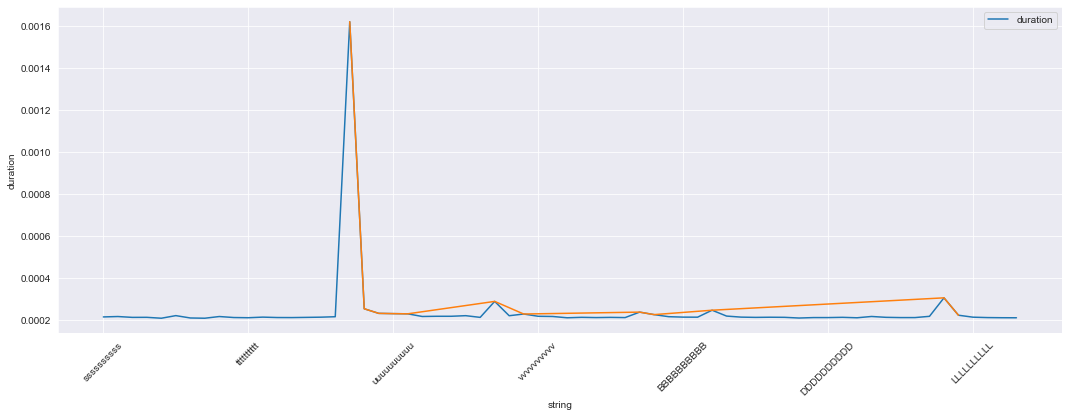

In [13]:
ax = df.plot(figsize=(18,6))
df[df['duration']> .000222]['duration'].plot(figsize=(18,6))
# not mapping strings to duration correctly
plt.xticks(rotation=45)
ax.set_xticklabels(df[df['duration']> .000222]['string'])
#ax.set_xticklabels(df.string.to_list())
# not working as I expected
# ax.set_xlabel(df.string.to_list())
ax.set_xlabel('string')
ax.set_ylabel('duration')

**a histogram shows off the distributions**

Most of the count returns immediately, but you can see on the right where the longest returns are.

<AxesSubplot:xlabel='duration', ylabel='Density'>

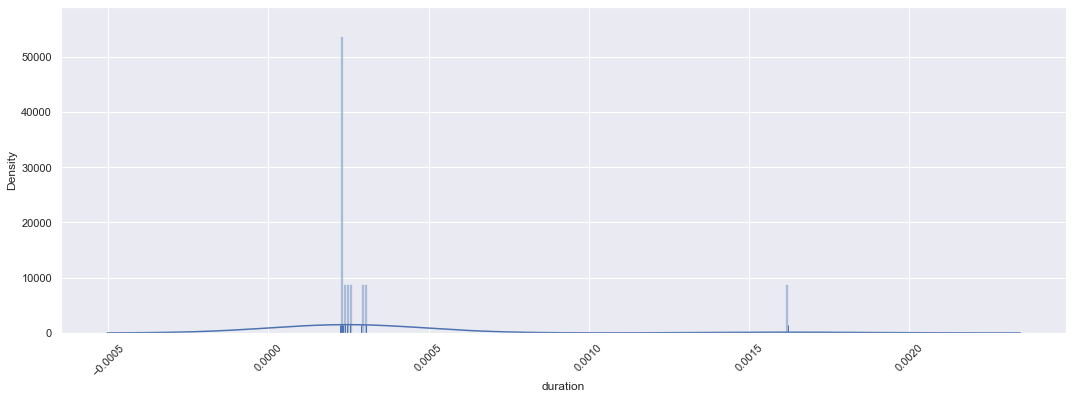

In [14]:
# a histogram shows off how obvious a good match is, compared to jitter
sns.set(rc={'figure.figsize':(18,6)})
plt.xticks(rotation=45)
sns.distplot(df[df['duration']> .000222]['duration'],bins=150, rug=True, kde=True)

## example of brute force strcmp analysis attacks 

Here's a dictionary matcher

In [15]:
# get a built-in dictionary
wordsraw = open('/usr/share/dict/words','r').readlines()
[x.strip('\n') for x in wordsraw]
words = [x.strip('\n') for x in wordsraw]

In [16]:
# set our name as 'apple'
name='apple'
# a longer one
name2 = 'unresourcefulness'

**This can take awhile to run**

Just matching 'apple' from a dictionary of english words. Words farther down the alphabet will take longer.


In [17]:
stash2 = {}
print('starting at:', datetime.now())
runstart = attotime.attodatetime.now()
for w in range(0,len(words)):
    start = attotime.attodatetime.now()
    if compare1(words[w], name):
            if compare1(words[w], name):
                if words[w] == name:
                    print('Name is', words[w])
                    break
            else:
                end = attotime.attodatetime.now()
                duration = end - start
                stash2[words[w]] = str(duration)
                print(words[w])
                stub = s
                break
    else:
        end = attotime.attodatetime.now()
        duration = end - start
        stash2[words[w]] = str(duration)
        pass
runend = attotime.attodatetime.now()
print('Finished. Total time:', runend - runstart)

starting at: 2021-07-05 15:45:41.473723
Name is apple
Finished. Total time: 0:00:24.19434690475463867


In [18]:
sorted(stash2.items(),key=lambda x: x[1])[:10]

[('Anchistopoda', '0:00:00.00021600723266602'),
 ('Agib', '0:00:00.00021696090698242'),
 ('Adeona', '0:00:00.00021767616271972'),
 ('Americawards', '0:00:00.00021791458129883'),
 ('Anacreontically', '0:00:00.00021815299987793'),
 ('Africanize', '0:00:00.00021815299987794'),
 ('Aaronitic', '0:00:00.00021886825561523'),
 ('Agapemonite', '0:00:00.00021886825561523'),
 ('Aphrodite', '0:00:00.00021886825561523'),
 ('Akhlame', '0:00:00.00021886825561524')]

### Brute forcing letter by character

using the timing analysis on local alphabet attacks

In [19]:

stash3 = {}
for c in valid_chars:
    stub = c
    for loop in range(0, len(name2)):
        stublist = [stub + l for l in valid_chars]
        for s in stublist:
            start = attotime.attodatetime.now()
            if compare1(s, name2):
                if s == name2:
                    print('Name is', s)
                    break
                else:
                    end = attotime.attodatetime.now()
                    duration = end - start
                    stash3[s] = str(duration)
                    print(s)
                    stub = s
                    break
            else:
                end = attotime.attodatetime.now()
                duration = end - start
                stash3[s] = str(duration)
                pass

un
unr
unre
unres
unreso
unresou
unresour
unresourc
unresource
unresourcef
unresourcefu
unresourceful
unresourcefuln
unresourcefulne
unresourcefulnes
Name is unresourcefulness
Name is unresourcefulness


**The longest returns are at the bottom and correspond to getting closer to the answer**

There is a little jumbling but it's clear that by only focusing on time it clusters better answers together.

In [20]:
# The longest returns are at the bottom and correspond to getting closer to the answer
sorted(stash3.items(), key=lambda x: x[1])[-20:]

[('unresourcefulne', '0:00:00.02023506164550781'),
 ('unresourcefulned', '0:00:00.02031373977661132'),
 ('unresourcefulnesm', '0:00:00.02043700218200684'),
 ('unresourcefulnesl', '0:00:00.02053403854370117'),
 ('unresourcefulnesn', '0:00:00.02061986923217774'),
 ('unresourcefulnesh', '0:00:00.02070784568786622'),
 ('unresourcefulneb', '0:00:00.02071785926818848'),
 ('unresourcefulnec', '0:00:00.02073884010314942'),
 ('unresourcefulnesf', '0:00:00.02083563804626465'),
 ('unresourcefulnea', '0:00:00.02091598510742188'),
 ('unresourcefulnesb', '0:00:00.02103519439697266'),
 ('unresourcefulnesj', '0:00:00.0210881233215332'),
 ('unresourcefulnesi', '0:00:00.02119660377502441'),
 ('unresourcefulnesg', '0:00:00.02123785018920899'),
 ('unresourcefulnese', '0:00:00.02157807350158691'),
 ('unresourcefulnesp', '0:00:00.02175784111022949'),
 ('unresourcefulnesd', '0:00:00.02190899848937988'),
 ('unresourcefulneso', '0:00:00.02203226089477539'),
 ('unresourcefulnesq', '0:00:00.02204012870788574'),


**and a modified dictionary word**

In [21]:
name='orang00t4_n'
stash4 = {}
for c in valid_chars:
    stub = c
    for loop in range(0, len(name)):
        stublist = [stub + l for l in valid_chars]
        for s in stublist:
            start = attotime.attodatetime.now()
            if compare1(s, name):
                if s == name:
                    print('Name is', s)
                    break
                else:
                    end = attotime.attodatetime.now()
                    duration = end - start
                    stash4[s] = str(duration)
                    print(s)
                    stub = s
                    break
            else:
                end = attotime.attodatetime.now()
                duration = end - start
                stash4[s] = str(duration)
                pass
            

or
ora
oran
orang
orang0
orang00
orang00t
orang00t4
orang00t4_
Name is orang00t4_n
Name is orang00t4_n


In [22]:
sorted(stash4.items(), key=lambda x: x[1])[-20:]

[('orang00t46', '0:00:00.01255202293395996'),
 ('orang00t47', '0:00:00.0125722885131836'),
 ('orang00t4_d', '0:00:00.01261806488037109'),
 ('orang00t44', '0:00:00.0126950740814209'),
 ('orang00t4_b', '0:00:00.01271724700927735'),
 ('orang00t43', '0:00:00.01273226737976074'),
 ('orang00t4_c', '0:00:00.01273703575134278'),
 ('orang00t4_g', '0:00:00.01283621788024903'),
 ('orang00t4c', '0:00:00.01292276382446289'),
 ('orang00t4_k', '0:00:00.01300191879272461'),
 ('orang00t45', '0:00:00.01302099227905273'),
 ('orang00t4_e', '0:00:00.01309609413146973'),
 ('orang00t4_j', '0:00:00.0131840705871582'),
 ('orang00t4_m', '0:00:00.01326990127563476'),
 ('orang00t4_l', '0:00:00.013275146484375'),
 ('orang00t4_h', '0:00:00.01332497596740723'),
 ('orang00t4_i', '0:00:00.01337075233459472'),
 ('orang00t4_a', '0:00:00.01343297958374023'),
 ('orang00t4_f', '0:00:00.01364302635192871'),
 ('orang00t4_', '0:00:00.01391100883483887')]

## Testing the time difference with our long string


This will take slightly longer for a 41 character string, but trivial on a modern laptop.


mysecret = 'rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUiQ'

In [26]:
print('starting at:', datetime.now())
runstart = attotime.attodatetime.now()
stash5 = {}
for c in valid_chars:
    stub = c
    for loop in range(0, len(mysecret)):
        stublist = [stub + l for l in valid_chars]
        for s in stublist:
            start = attotime.attodatetime.now()
            if compare1(s, mysecret):
                if s == mysecret:
                    print('Name is', s)
                    break
                else:
                    end = attotime.attodatetime.now()
                    duration = end - start
                    stash5[s] = str(duration)
                    print(s)
                    stub = s
                    break
            else:
                end = attotime.attodatetime.now()
                duration = end - start
                stash5[s] = str(duration)
                pass
runend = attotime.attodatetime.now()
print('Finished. Total time:', runend - runstart)

starting at: 2021-07-05 15:54:01.095566
rM
rMA
rMAw
rMAwz
rMAwzI
rMAwzI_
rMAwzI_5
rMAwzI_52
rMAwzI_52t
rMAwzI_52tV
rMAwzI_52tVS
rMAwzI_52tVSv
rMAwzI_52tVSvg
rMAwzI_52tVSvgK
rMAwzI_52tVSvgKz
rMAwzI_52tVSvgKzR
rMAwzI_52tVSvgKzRo
rMAwzI_52tVSvgKzRo3
rMAwzI_52tVSvgKzRo3P
rMAwzI_52tVSvgKzRo3PJ
rMAwzI_52tVSvgKzRo3PJ0
rMAwzI_52tVSvgKzRo3PJ0G
rMAwzI_52tVSvgKzRo3PJ0G7
rMAwzI_52tVSvgKzRo3PJ0G7_
rMAwzI_52tVSvgKzRo3PJ0G7_D
rMAwzI_52tVSvgKzRo3PJ0G7_Da
rMAwzI_52tVSvgKzRo3PJ0G7_Dan
rMAwzI_52tVSvgKzRo3PJ0G7_Danw
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7j
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jl
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jla
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6v
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vT
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTk
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkO
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOU
rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUi
Name is rMAwzI_52

In [27]:
sorted(stash5.items(), key=lambda x: x[1])[:5]

[('Se', '0:00:00.00020885467529297'),
 ('uS', '0:00:00.00020933151245117'),
 ('fV', '0:00:00.00020980834960937'),
 ('T2', '0:00:00.00020980834960937'),
 ('2i', '0:00:00.00020980834960937')]

In [28]:
sorted(stash5.items(), key=lambda x: x[1])[-20:]

[('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUf', '0:00:00.05510401725769043'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUiE', '0:00:00.05525302886962891'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUiy', '0:00:00.05527281761169434'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUim', '0:00:00.05531096458435058'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUiA', '0:00:00.05566596984863281'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUit', '0:00:00.05573201179504394'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUic', '0:00:00.05579710006713867'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUiP', '0:00:00.05579900741577149'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUid', '0:00:00.05587410926818848'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUia', '0:00:00.05602025985717774'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUh', '0:00:00.05602192878723144'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUif', '0:00:00.05605888366699219'),
 ('rMAwzI_52tVSvgKzRo3PJ0G7_Danw7jlaZ-6vTkOUiB', '0:00

### How would this compare to hash comparison?

This will start will the dictionary word 'apple'.

In [40]:
def comparehash(token, secret):
    """
    we're going to use the old md5 hash to simplify the demonstration
    """
    htoken, hsecret = hashlib.md5(token.encode('utf-8')), hashlib.md5(secret.encode('utf-8'))
    one, two = list(htoken.hexdigest()), list(hsecret.hexdigest())
    for x in range(0,len(one)):
        if one[x] == two[x]:
            time.sleep(.001)
            pass
        else:
            return False
    return True

In [42]:
totals=[]
for loop in range(1000):
    stash10 = {}
    for l in valid_chars:
        mystr = l *10
        start = attotime.attodatetime.now()
        comparehash(mystr, mysecret)
        end = attotime.attodatetime.now()
        duration = end - start
        stash10[mystr] = str(duration)

In [43]:
sorted(stash10.items(), key=lambda x: x[1])[-10:]

[('cccccccccc', '0:00:00.00022721290588379'),
 ('UUUUUUUUUU', '0:00:00.00023722648620605'),
 ('llllllllll', '0:00:00.00023889541625976'),
 ('kkkkkkkkkk', '0:00:00.0002439022064209'),
 ('TTTTTTTTTT', '0:00:00.00024580955505371'),
 ('bbbbbbbbbb', '0:00:00.00025177001953125'),
 ('iiiiiiiiii', '0:00:00.00025582313537597'),
 ('vvvvvvvvvv', '0:00:00.00026488304138184'),
 ('jjjjjjjjjj', '0:00:00.00033926963806153'),
 ('hhhhhhhhhh', '0:00:00.00164484977722168')]

In [44]:
df10 = pd.DataFrame(stash10.items())

In [45]:
df10.columns = ['string', 'duration']

In [46]:
df10['duration'] = df10['duration'].apply(fixtimes)

**It's easy to see how much flatter the response times are**

Text(0, 0.5, 'duration')

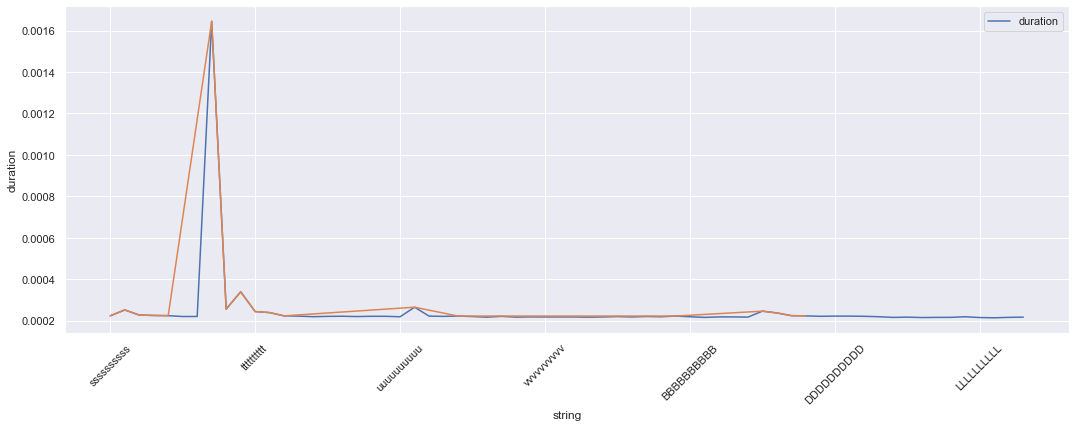

In [47]:
ax = df10.plot(figsize=(18,6))
df10[df10['duration']> .000222]['duration'].plot(figsize=(18,6))
# not mapping strings to duration correctly
plt.xticks(rotation=45)
ax.set_xticklabels(df[df['duration']> .000222]['string'])
#ax.set_xticklabels(df.string.to_list())
# not working as I expected
# ax.set_xlabel(df.string.to_list())
ax.set_xlabel('string')
ax.set_ylabel('duration')

<AxesSubplot:xlabel='duration', ylabel='Density'>

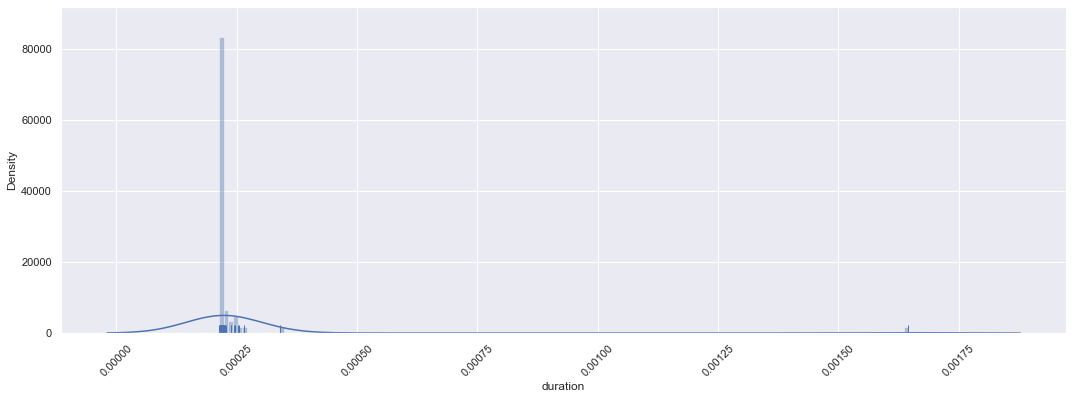

In [48]:
sns.set(rc={'figure.figsize':(18,6)})
plt.xticks(rotation=45)
sns.distplot(df10['duration'],bins=150, rug=True, kde=True)